In [11]:
# Environment Setup and Data Loading

# In this step, we import all required libraries and load the Icecat product dataset.
# The dataset contains hierarchical category paths which will later be used for
# taxonomy construction and evaluation.


In [12]:
import os
import json
import hashlib
import random
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from anytree import Node, RenderTree
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_json("icecat_data_train.json")
df.head(5)

,Brand,BrandInfo.BrandLocalName,BrandInfo.BrandLogo,BrandInfo.BrandName,BrandLogo,BrandPartCode,BulletPoints,Category.CategoryID,Category.Name.Language,Category.Name.Value,...,ProductSeries.Language,ProductSeries.Value,BulletPoints.BulletPointsId,BulletPoints.Language,BulletPoints.Updated,BulletPoints.Values,VirtualCategory,SummaryDescription,pathlist_ids,pathlist_names
1072689,ASUS,,https://images.icecat.biz/img/brand/thumb/161_...,ASUS,https://images.icecat.biz/img/brand/thumb/161_...,K31CD-IT049T,[],153,EN,PCs/Workstations,...,None,None,NaN,None,None,None,"[{'VirtualCategoryID': 195, 'UNCATID': '431718...",NaN,2833>150>153,Computers & Electronics>Computers>PCs/Workstat...
906402,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,686915-A41,[],2509,EN,Notebook Spare Parts,...,None,None,NaN,None,None,None,None,NaN,2833>150>8355>2509,Computers & Electronics>Computers>Notebook Par...
411281,C2G,,https://images.icecat.biz/img/brand/thumb/2834...,C2G,https://images.icecat.biz/img/brand/thumb/2834...,37745,[],953,EN,Fibre Optic Cables,...,None,None,NaN,None,None,None,None,NaN,2833>830>953,Computers & Electronics>Computer Cables>Fibre ...
425903,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,FA889AA#AC3,[],8194,EN,Handheld Mobile Computer Spare Parts,...,None,None,NaN,None,None,None,None,NaN,2833>150>8194,Computers & Electronics>Computers>Handheld Mob...
1047582,Lenovo,,https://images.icecat.biz/img/brand/thumb/728_...,Lenovo,https://images.icecat.biz/img/brand/thumb/728_...,109559U,[],153,EN,PCs/Workstations,...,None,None,NaN,None,None,None,"[{'VirtualCategoryID': 194, 'UNCATID': '431718...",NaN,2833>150>153,Computers & Electronics>Computers>PCs/Workstat...


In [14]:
## Extraction of Target Taxonomy Levels (A–B–C)

# To evaluate clustering quality later, we extract the first three levels of the
# original taxonomy (A > B > C). These serve as proxy ground-truth labels for
# purity and impurity evaluation at C and B levels.


In [15]:
# Extracting A–B–C and Level-4 (Ground Truth Aid)
def split_path(path):
    if not isinstance(path, str):
        return []
    parts = [p.strip() for p in path.split(">") if p.strip()]
    return parts

df["num_levels"] = df["pathlist_names"].apply(lambda x: len(split_path(x)))

print("Counts BEFORE cleaning:")
print(df["num_levels"].value_counts().sort_index())

Counts BEFORE cleaning:
num_levels
3    289865
4    200037
Name: count, dtype: int64


In [16]:
import pandas as pd

def make_3_and_4(path):
    parts = split_path(path)

    # default
    path_3 = None
    level_4 = None

    if len(parts) >= 3:
        path_3 = " > ".join(parts[:3])   # A > B > C
    if len(parts) >= 4:
        level_4 = parts[3]               # D (4th level)

    return pd.Series({"path_3": path_3, "level_4": level_4})

df[["path_3", "level_4"]] = df["pathlist_names"].apply(make_3_and_4)

print(df[["pathlist_names", "path_3", "level_4"]].head(10))


                                            pathlist_names  \
1072689  Computers & Electronics>Computers>PCs/Workstat...   
906402   Computers & Electronics>Computers>Notebook Par...   
411281   Computers & Electronics>Computer Cables>Fibre ...   
425903   Computers & Electronics>Computers>Handheld Mob...   
1047582  Computers & Electronics>Computers>PCs/Workstat...   
904910   Computers & Electronics>Computers>Notebook Par...   
157385   Computers & Electronics>Software>Software Lice...   
934548   Computers & Electronics>Computers>Notebook Par...   
876762   Computers & Electronics>Computers>Notebook Par...   
397028   Computers & Electronics>Telecom & Navigation>M...   

                                                    path_3  \
1072689  Computers & Electronics > Computers > PCs/Work...   
906402   Computers & Electronics > Computers > Notebook...   
411281   Computers & Electronics > Computer Cables > Fi...   
425903   Computers & Electronics > Computers > Handheld...   
1047582

In [17]:
print("Rows:", len(df))
print("Unique num_levels (original):")
print(df["num_levels"].value_counts().sort_index())

print("\nCheck how many have a 4th level stored:")
print(df["level_4"].notna().sum(), "rows with level_4")


Rows: 489902
Unique num_levels (original):
num_levels
3    289865
4    200037
Name: count, dtype: int64

Check how many have a 4th level stored:
200037 rows with level_4


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489902 entries, 1072689 to 1008771
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Brand                                       489902 non-null  object 
 1   BrandInfo.BrandLocalName                    489902 non-null  object 
 2   BrandInfo.BrandLogo                         488765 non-null  object 
 3   BrandInfo.BrandName                         489902 non-null  object 
 4   BrandLogo                                   488765 non-null  object 
 5   BrandPartCode                               489902 non-null  object 
 6   BulletPoints                                455119 non-null  object 
 7   Category.CategoryID                         489902 non-null  int64  
 8   Category.Name.Language                      489902 non-null  object 
 9   Category.Name.Value                         489902 non-null  object 

In [19]:
# ##  Explicit Extraction of A-, B-, and C-Level Categories

# To standardize the taxonomy structure, we construct a new column (`path_3`)
# containing only the first three hierarchical levels (A > B > C) extracted
# from the original category paths. This ensures a consistent three-level
# representation across all products.

# If a product contains a fourth-level category, it is stored separately in
# the `level_4` column. Products without a fourth-level category are assigned
# a null value. This separation allows us to preserve fine-grained category
# information while focusing the clustering and evaluation pipeline on the
# A-, B-, and C-level hierarchy.

# The extracted A-, B-, and C-level labels serve as proxy ground truth for
# subsequent purity and impurity evaluation.


In [20]:
# Extract A, B, C from path_3
df[["A", "B", "C"]] = (
    df["path_3"]
    .str.split(">", expand=True)
    .apply(lambda col: col.str.strip())
)


In [21]:
df.head()

,Brand,BrandInfo.BrandLocalName,BrandInfo.BrandLogo,BrandInfo.BrandName,BrandLogo,BrandPartCode,BulletPoints,Category.CategoryID,Category.Name.Language,Category.Name.Value,...,VirtualCategory,SummaryDescription,pathlist_ids,pathlist_names,num_levels,path_3,level_4,A,B,C
1072689,ASUS,,https://images.icecat.biz/img/brand/thumb/161_...,ASUS,https://images.icecat.biz/img/brand/thumb/161_...,K31CD-IT049T,[],153,EN,PCs/Workstations,...,"[{'VirtualCategoryID': 195, 'UNCATID': '431718...",NaN,2833>150>153,Computers & Electronics>Computers>PCs/Workstat...,3,Computers & Electronics > Computers > PCs/Work...,None,Computers & Electronics,Computers,PCs/Workstations
906402,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,686915-A41,[],2509,EN,Notebook Spare Parts,...,None,NaN,2833>150>8355>2509,Computers & Electronics>Computers>Notebook Par...,4,Computers & Electronics > Computers > Notebook...,Notebook Spare Parts,Computers & Electronics,Computers,Notebook Parts & Accessories
411281,C2G,,https://images.icecat.biz/img/brand/thumb/2834...,C2G,https://images.icecat.biz/img/brand/thumb/2834...,37745,[],953,EN,Fibre Optic Cables,...,None,NaN,2833>830>953,Computers & Electronics>Computer Cables>Fibre ...,3,Computers & Electronics > Computer Cables > Fi...,None,Computers & Electronics,Computer Cables,Fibre Optic Cables
425903,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,FA889AA#AC3,[],8194,EN,Handheld Mobile Computer Spare Parts,...,None,NaN,2833>150>8194,Computers & Electronics>Computers>Handheld Mob...,3,Computers & Electronics > Computers > Handheld...,None,Computers & Electronics,Computers,Handheld Mobile Computer Spare Parts
1047582,Lenovo,,https://images.icecat.biz/img/brand/thumb/728_...,Lenovo,https://images.icecat.biz/img/brand/thumb/728_...,109559U,[],153,EN,PCs/Workstations,...,"[{'VirtualCategoryID': 194, 'UNCATID': '431718...",NaN,2833>150>153,Computers & Electronics>Computers>PCs/Workstat...,3,Computers & Electronics > Computers > PCs/Work...,None,Computers & Electronics,Computers,PCs/Workstations


In [22]:
#  Taxonomy Level Cardinality Analysis

# We analyze the number of unique categories at each taxonomy level. The results
# highlight severe class imbalance, motivating unsupervised clustering at the
# C-level, constrained clustering at the B-level, and semantic naming only at
# the A-level.


In [23]:
# Basic Stats
print("Total products:", len(df))
print("Unique A-level:", df["A"].nunique())
print("Unique B-level:", df["B"].nunique())
print("Unique C-level:", df["C"].nunique())


Total products: 489902
Unique A-level: 1
Unique B-level: 17
Unique C-level: 231


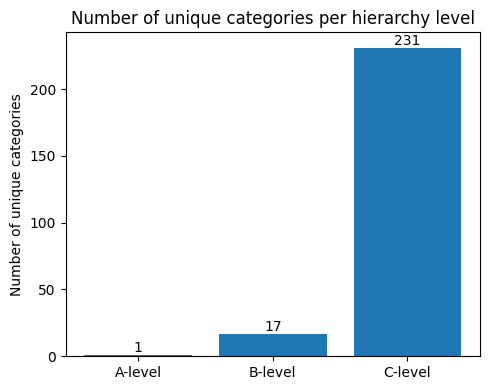

In [24]:
import matplotlib.pyplot as plt

levels = ["A-level", "B-level", "C-level"]
unique_counts = [
    df["A"].nunique(),
    df["B"].nunique(),
    df["C"].nunique()
]

plt.figure(figsize=(5,4))
bars = plt.bar(levels, unique_counts)
plt.ylabel("Number of unique categories")
plt.title("Number of unique categories per hierarchy level")

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


In [25]:
# Distribution Analysis Across Taxonomy Levels

# We examine the distribution of products across B- and C-level categories.
# The C-level shows a strong long-tail distribution, reinforcing the need for
# data-driven clustering and objective purity evaluation before semantic naming.


In [26]:
#Distribution of A / B / C/
print("\nProducts per A-level:")
print(df["A"].value_counts())

print("\nProducts per B-level (top 10):")
print(df["B"].value_counts().head(20))

print("\nProducts per C-level (top 10):")
print(df["C"].value_counts().head(20))

print("\nProducts per C-level (bottom 10):")
print(df["C"].value_counts().tail(10))



Products per A-level:
A
Computers & Electronics    489902
Name: count, dtype: int64

Products per B-level (top 10):
B
Computers                           221663
Printers & Scanners                  36107
Software                             30639
Computer Components                  29880
Warranty & Support                   29108
Data Storage                         25346
TVs & Monitors                       24611
Computer Cables                      20598
Telecom & Navigation                 19208
Batteries & Power Supplies           12306
Data Input Devices                   10514
Consumer Audio & Video Equipment      8499
Projectors                            7795
Photo & Video Equipment               6433
Networking                            5829
Office Electronics                     817
Smart Wearables                        549
Name: count, dtype: int64

Products per C-level (top 10):
C
Notebook Parts & Accessories     97843
Notebooks                        83488
Warranty & S

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_top_categories(series, title, top_n=10):
    counts = series.value_counts().head(top_n)

    colors = cm.tab10(np.linspace(0, 1, len(counts)))

    plt.figure(figsize=(8,4))
    bars = plt.bar(counts.index, counts.values, color=colors)

    plt.ylabel("Number of products")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


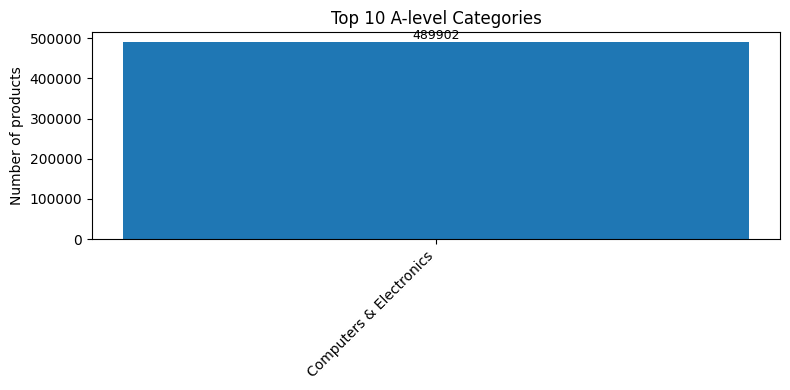

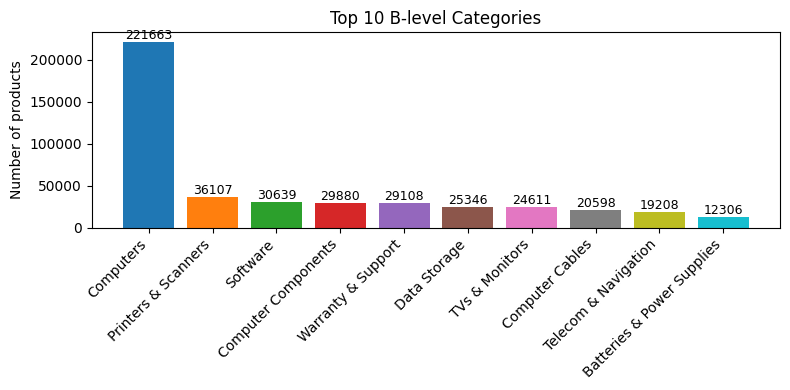

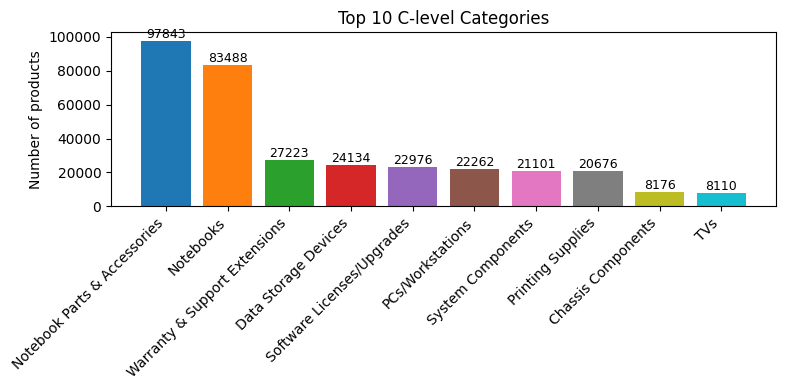

In [28]:
plot_top_categories(df["A"], "Top 10 A-level Categories")
plot_top_categories(df["B"], "Top 10 B-level Categories")
plot_top_categories(df["C"], "Top 10 C-level Categories")


In [29]:
# C-level Imbalance Quantiles
# (This shows how skewed leaf categories are)
prod_per_C = df["C"].value_counts()

print("\nC-level product quantiles:")
print(prod_per_C.quantile([0.1, 0.25, 0.5, 0.75, 0.9]))



C-level product quantiles:
0.10      25.0
0.25      53.0
0.50     173.0
0.75     716.5
0.90    3226.0
Name: count, dtype: float64


In [30]:
# Basic counts
print("Total products:", len(df))
print("Unique A levels:", df["A"].nunique())
print("Unique B levels:", df["B"].nunique())
print("Unique C levels:", df["C"].nunique())

# Compute product counts
prod_A = df["A"].value_counts()
prod_B = df["B"].value_counts()
prod_C = df["C"].value_counts()


Total products: 489902
Unique A levels: 1
Unique B levels: 17
Unique C levels: 231


In [31]:
#  C-Level Imbalance Analysis

# We examine how products are distributed across C-level categories.
# The results show that a few categories contain many products, while many
# categories have very few products. This strong imbalance explains why
# clustering is needed to reorganize C-level categories more effectively.


In [32]:
# Identify problematic A/B/C categories
# Very large categories (top 10)
print("\n🔥 TOP 10 LARGEST C categories:")
print(prod_C.head(10))

# Very small categories (bottom 10)
print("\n❗ BOTTOM 20 SMALLEST C categories:")
print(prod_C.tail(20))

# C categories with < 30 products
weak_C = prod_C[prod_C < 30]
print("\n❗ Weak C categories (<10 products):", len(weak_C))
print(weak_C.head(20))

# B categories with < 3 C children
C_children_per_B = df.groupby("B")["C"].nunique()
weak_B = C_children_per_B[C_children_per_B < 3]

print("\n❗ Weak B categories (<3 C children):", len(weak_B))
print(weak_B.head(20))



🔥 TOP 10 LARGEST C categories:
C
Notebook Parts & Accessories     97843
Notebooks                        83488
Warranty & Support Extensions    27223
Data Storage Devices             24134
Software Licenses/Upgrades       22976
PCs/Workstations                 22262
System Components                21101
Printing Supplies                20676
Chassis Components                8176
TVs                               8110
Name: count, dtype: int64

❗ BOTTOM 20 SMALLEST C categories:
C
Touch Pads                                     23
Network Management Devices                     23
Parallel Cables                                22
Car Kits                                       22
KVM Extenders                                  22
Cable Boots                                    22
Remote Power Controllers                       21
Public Address (PA) Systems                    21
Fax Supplies                                   21
Selfie Sticks                                  21
Network Cabl

In [33]:
#Identify dominant categories (too large)
# Very large C categories (skewing the distribution)
dominant_C = prod_C[prod_C > prod_C.quantile(0.95)]

print("\n🔥 Dominant C categories (>95th percentile):", len(dominant_C))
print(dominant_C)



🔥 Dominant C categories (>95th percentile): 12
C
Notebook Parts & Accessories     97843
Notebooks                        83488
Warranty & Support Extensions    27223
Data Storage Devices             24134
Software Licenses/Upgrades       22976
PCs/Workstations                 22262
System Components                21101
Printing Supplies                20676
Chassis Components                8176
TVs                               8110
Keyboards                         7857
Printing Equipment                7140
Name: count, dtype: int64


In [34]:
B_summary = (
    df.groupby(["A", "B"])
      .agg(num_products=("C", "count"),
           num_C=("C", "nunique"))
      .reset_index()
      .sort_values("num_products", ascending=False)
)

print(" B-level imbalance summary:")
print(B_summary.head(20))


 B-level imbalance summary:
                          A                                 B  num_products  \
3   Computers & Electronics                         Computers        221663   
10  Computers & Electronics               Printers & Scanners         36107   
13  Computers & Electronics                          Software         30639   
2   Computers & Electronics               Computer Components         29880   
16  Computers & Electronics                Warranty & Support         29108   
6   Computers & Electronics                      Data Storage         25346   
14  Computers & Electronics                    TVs & Monitors         24611   
1   Computers & Electronics                   Computer Cables         20598   
15  Computers & Electronics              Telecom & Navigation         19208   
0   Computers & Electronics        Batteries & Power Supplies         12306   
5   Computers & Electronics                Data Input Devices         10514   
4   Computers & Electron

In [35]:
# A–B–C Structural Summary

# We summarize the hierarchical structure of the taxonomy by showing how many
# B-level categories exist under the A-level and how many C-level subcategories
# and products belong to each B category. This analysis helps understand the
# imbalance and structure of the original taxonomy before clustering.


In [36]:
def report_AB(df):
    grouped = (
        df.groupby(["A", "B"])
          .agg(
              num_C=("C", "nunique"),
              num_products=("C", "size")
          )
          .reset_index()
    )

    for a in grouped["A"].unique():
        print(f"\nA: {a}")
        print("="*80)
        temp = grouped[grouped["A"] == a]
        for _, row in temp.iterrows():
            print(f"  B: {row['B']}")
            print(f"    #C-level subcategories: {row['num_C']}")
            print(f"    #products (total under this B): {row['num_products']}")


In [37]:
report_AB(df)


A: Computers & Electronics
  B: Batteries & Power Supplies
    #C-level subcategories: 12
    #products (total under this B): 12306
  B: Computer Cables
    #C-level subcategories: 34
    #products (total under this B): 20598
  B: Computer Components
    #C-level subcategories: 5
    #products (total under this B): 29880
  B: Computers
    #C-level subcategories: 24
    #products (total under this B): 221663
  B: Consumer Audio & Video Equipment
    #C-level subcategories: 31
    #products (total under this B): 8499
  B: Data Input Devices
    #C-level subcategories: 11
    #products (total under this B): 10514
  B: Data Storage
    #C-level subcategories: 2
    #products (total under this B): 25346
  B: Networking
    #C-level subcategories: 30
    #products (total under this B): 5829
  B: Office Electronics
    #C-level subcategories: 7
    #products (total under this B): 817
  B: Photo & Video Equipment
    #C-level subcategories: 3
    #products (total under this B): 6433
  B: Pri

In [38]:
from anytree import Node, RenderTree

def build_AB_tree(df):
    grouped = (
        df.groupby(["A", "B"])
          .agg(
              num_C=("C", "nunique"),
              num_products=("C", "size")
          )
          .reset_index()
    )

    roots = {}

    for _, row in grouped.iterrows():
        A, B = row["A"], row["B"]

        if A not in roots:
            roots[A] = Node(f"A: {A}")

        Node(
            f"B: {B} | C-subcats: {row['num_C']} | Products: {row['num_products']}",
            parent=roots[A]
        )

    # Print trees
    for root in roots.values():
        for pre, _, node in RenderTree(root):
            print(f"{pre}{node.name}")
        print("\n" + "-"*80 + "\n")

# Run
build_AB_tree(df)


A: Computers & Electronics
├── B: Batteries & Power Supplies | C-subcats: 12 | Products: 12306
├── B: Computer Cables | C-subcats: 34 | Products: 20598
├── B: Computer Components | C-subcats: 5 | Products: 29880
├── B: Computers | C-subcats: 24 | Products: 221663
├── B: Consumer Audio & Video Equipment | C-subcats: 31 | Products: 8499
├── B: Data Input Devices | C-subcats: 11 | Products: 10514
├── B: Data Storage | C-subcats: 2 | Products: 25346
├── B: Networking | C-subcats: 30 | Products: 5829
├── B: Office Electronics | C-subcats: 7 | Products: 817
├── B: Photo & Video Equipment | C-subcats: 3 | Products: 6433
├── B: Printers & Scanners | C-subcats: 5 | Products: 36107
├── B: Projectors | C-subcats: 8 | Products: 7795
├── B: Smart Wearables | C-subcats: 5 | Products: 549
├── B: Software | C-subcats: 10 | Products: 30639
├── B: TVs & Monitors | C-subcats: 21 | Products: 24611
├── B: Telecom & Navigation | C-subcats: 18 | Products: 19208
└── B: Warranty & Support | C-subcats: 5 | Prod

In [39]:
# Detailed A–B–C Category Breakdown

# We display the complete A–B–C hierarchy from the original taxonomy.
# For each B-level category, all associated C-level categories and their
# product counts are listed. This helps visualize the original structure
# and confirms the presence of imbalance at the C level.


In [40]:
def report_ABC(df):
    grouped = (
        df.groupby(["A", "B", "C"])
          .size()
          .reset_index(name="num_products")
    )

    for a in grouped["A"].unique():
        print(f"\nA: {a}")
        print("="*80)
        tempA = grouped[grouped["A"] == a]

        for b in tempA["B"].unique():
            print(f"  B: {b}")
            tempB = tempA[tempA["B"] == b]

            for _, row in tempB.iterrows():
                print(f"    C: {row['C']}  ({row['num_products']} products)")


In [41]:
report_ABC(df)



A: Computers & Electronics
  B: Batteries & Power Supplies
    C: Battery Chargers  (479 products)
    C: Household Batteries  (1256 products)
    C: Notebook Power Tips  (56 products)
    C: Portable Device Management Carts & Cabinets  (19 products)
    C: Power Adapters & Inverters  (4728 products)
    C: Power Banks  (702 products)
    C: Power Distribution Units (PDUs)  (1150 products)
    C: Power Supply Units  (1140 products)
    C: UPS Batteries  (402 products)
    C: UPS Battery Cabinets  (79 products)
    C: Uninterruptible Power Supplies (UPSs)  (2249 products)
    C: Uninterruptible Power Supplies (UPSs) Accessories  (46 products)
  B: Computer Cables
    C: Audio Cables  (653 products)
    C: Cable Boots  (22 products)
    C: Cable Interface/Gender Adapters  (1906 products)
    C: Cable Protectors  (52 products)
    C: Cable Splitters or Combiners  (19 products)
    C: Coaxial Cables  (299 products)
    C: Component (YPbPr) Video Cables  (104 products)
    C: Composite Vid

In [42]:
# def report_ABC_products(df):
#     for a in df["A"].unique():
#         print(f"\nA: {a}")
#         print("="*80)
#         dfA = df[df["A"] == a]

#         for b in dfA["B"].unique():
#             print(f"  B: {b}")
#             dfB = dfA[dfA["B"] == b]

#             for c in dfB["C"].unique():
#                 dfC = dfB[dfB["C"] == c]
#                 print(f"    C: {c}  ({len(dfC)} products)")
                
#                 # show top 10 product codes
#                 for code in dfC["ProductName"].fillna("").head(10):
#                     print(f"        • {code}")


In [43]:
# report_ABC_products(df)

In [44]:
# Compute metrics
products_per_AB = df.groupby(["A", "B"]).size()
C_children_per_AB = df.groupby(["A", "B"])["C"].nunique()

# Combine
ab_summary = pd.DataFrame({
    "products_in_AB": products_per_AB,
    "n_C_children": C_children_per_AB
})

# Sort by product count descending (like your example)
ab_summary = ab_summary.sort_values("products_in_AB", ascending=False).head(10)

print(ab_summary)


                                                    products_in_AB  \
A                       B                                            
Computers & Electronics Computers                           221663   
                        Printers & Scanners                  36107   
                        Software                             30639   
                        Computer Components                  29880   
                        Warranty & Support                   29108   
                        Data Storage                         25346   
                        TVs & Monitors                       24611   
                        Computer Cables                      20598   
                        Telecom & Navigation                 19208   
                        Batteries & Power Supplies           12306   

                                                    n_C_children  
A                       B                                         
Computers & Electronics C

In [45]:
prod_per_C = df["C"].value_counts()
prod_per_C


C
Notebook Parts & Accessories     97843
Notebooks                        83488
Warranty & Support Extensions    27223
Data Storage Devices             24134
Software Licenses/Upgrades       22976
                                 ...  
ISDN Access Devices                 17
Numeric Keypads                     17
AV Conferencing Bridges             17
Cassette Players                    16
Smart TV Boxes                      16
Name: count, Length: 231, dtype: int64

In [46]:
# Handling C-Level Imbalance Using Thresholds

# To reduce extreme imbalance at the C level, we analyze how many products and
# categories would be removed under different minimum size thresholds.
# This analysis shows the trade-off between data retention and category quality.
# Based on this, we select a minimum threshold (e.g., 100 products) to remove
# very small C categories while keeping most of the data.


In [47]:
import pandas as pd

# df must already contain columns: A, B, C
# (your 290k cleaned taxonomy dataframe)

def removal_summary(df, thresholds=[10,20,30,40,50,70,100,150,200]):
    results = []

    c_counts = df['C'].value_counts()

    for t in thresholds:
        # C categories kept
        valid_C = c_counts[c_counts >= t].index
        
        # rows kept
        kept_rows = df[df['C'].isin(valid_C)]
        
        # rows removed
        removed_rows = len(df) - len(kept_rows)

        # number of C categories eliminated
        removed_categories = (c_counts < t).sum()

        results.append({
            "Threshold": f"< {t}",
            "Total Rows": len(df),
            "Rows Removed": removed_rows,
            "Rows Removed (%)": round((removed_rows/len(df))*100, 2),
            "C Categories Removed": removed_categories,
            "C Categories Kept": len(valid_C)
        })
    
    return pd.DataFrame(results)

summary_table = removal_summary(df)
summary_table


,Threshold,Total Rows,Rows Removed,Rows Removed (%),C Categories Removed,C Categories Kept
0,< 10,489902,0,0.00,0,231
1,< 20,489902,140,0.03,8,223
2,< 30,489902,661,0.13,30,201
3,< 40,489902,1234,0.25,46,185
4,< 50,489902,1680,0.34,56,175
5,< 70,489902,2444,0.50,69,162
6,< 100,489902,3809,0.78,85,146
7,< 150,489902,6992,1.43,111,120
8,< 200,489902,8009,1.63,117,114


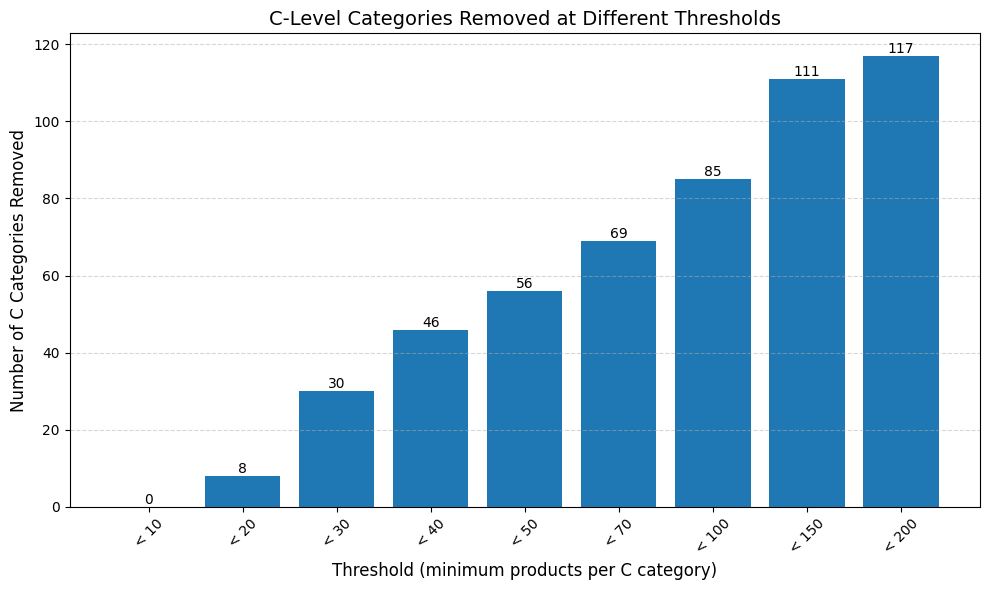

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

bars = plt.bar(
    summary_table["Threshold"],
    summary_table["C Categories Removed"]
)

plt.title("C-Level Categories Removed at Different Thresholds", fontsize=14)
plt.xlabel("Threshold (minimum products per C category)", fontsize=12)
plt.ylabel("Number of C Categories Removed", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


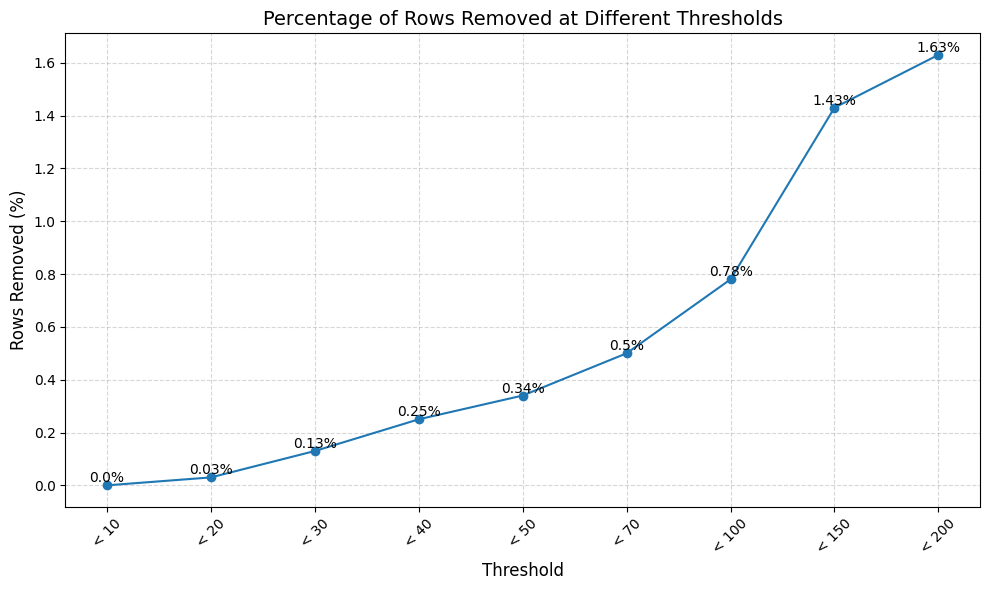

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(
    summary_table["Threshold"],
    summary_table["Rows Removed (%)"],
    marker='o'
)

plt.title("Percentage of Rows Removed at Different Thresholds", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Rows Removed (%)", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Add data labels
for x, y in zip(summary_table["Threshold"], summary_table["Rows Removed (%)"]):
    plt.text(
        x,
        y,
        f"{y}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [50]:
##  Threshold Impact Visualization

# This figure shows how increasing the minimum product threshold affects the data.
# The left plot shows how many C-level categories are removed, while the right plot
# shows the percentage of products removed. These plots help select a threshold
# that reduces noise while keeping most of the data.


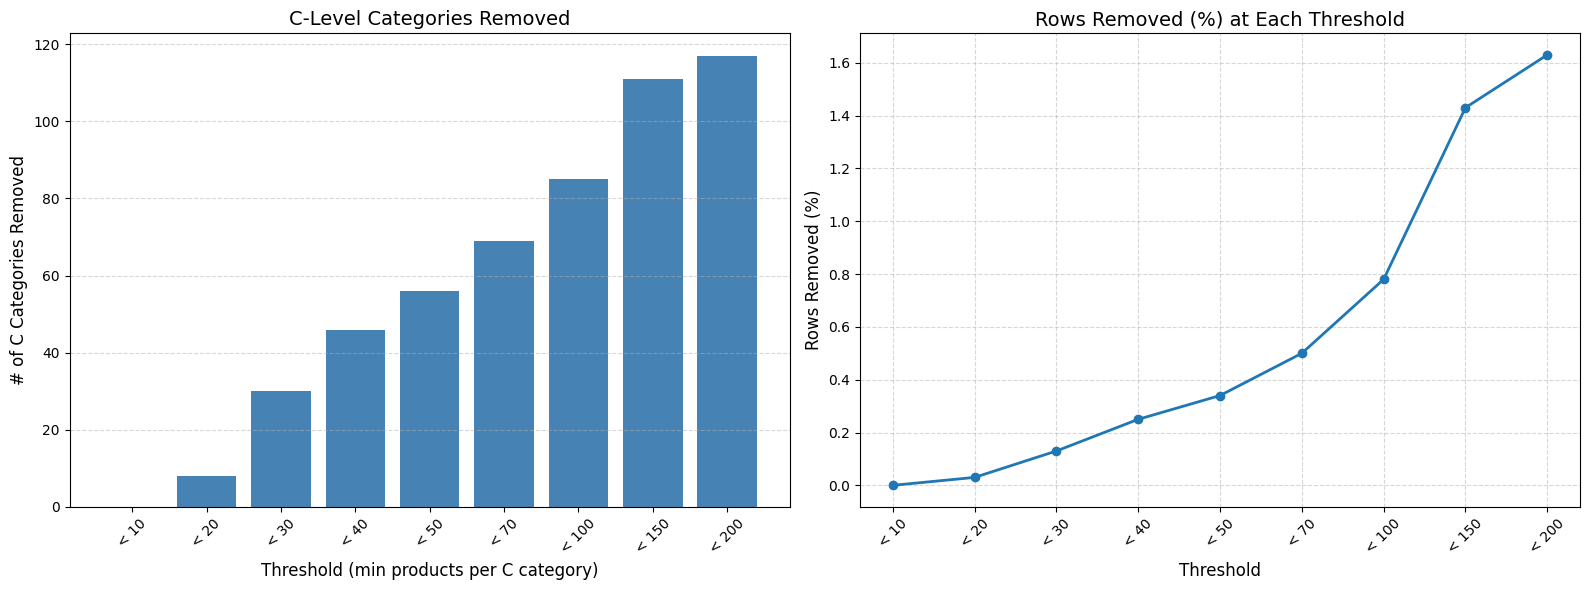

In [51]:
#Combined 2-Panel Visualization (C Categories Removed + Rows Removed%)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Panel 1: C Categories Removed ---
axes[0].bar(summary_table["Threshold"], summary_table["C Categories Removed"], color='steelblue')
axes[0].set_title("C-Level Categories Removed", fontsize=14)
axes[0].set_xlabel("Threshold (min products per C category)", fontsize=12)
axes[0].set_ylabel("# of C Categories Removed", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Panel 2: Rows Removed Percentage ---
axes[1].plot(summary_table["Threshold"], summary_table["Rows Removed (%)"], marker='o', linewidth=2)
axes[1].set_title("Rows Removed (%) at Each Threshold", fontsize=14)
axes[1].set_xlabel("Threshold", fontsize=12)
axes[1].set_ylabel("Rows Removed (%)", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [52]:
## C-Level Size Statistics

# We analyze the size of C-level categories using basic statistics and percentiles.
# The results show a strong imbalance, with many small categories and a few very
# large ones. This analysis supports selecting minimum and maximum size thresholds
# to filter noisy and overly dominant C categories before clustering.


In [53]:
import pandas as pd

# df must contain the C column
c_counts = df["C"].value_counts()

print("Total products:", len(df))
print("Total C-level categories:", c_counts.shape[0])

# --- 1. Basic statistics ---
average_size = c_counts.mean()
median_size = c_counts.median()

print("\nAverage C-category size:", round(average_size, 2))
print("Median C-category size:", median_size)

# --- 2. Percentiles ---
percentiles = c_counts.quantile([0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
print("\nPercentiles (category size):")
print(percentiles)

# --- 3. Show smallest & largest categories ---
print("\nSmallest 10 C categories:")
print(c_counts.nsmallest(10))

print("\nLargest 10 C categories:")
print(c_counts.nlargest(10))

# --- 4. Histogram bucket values (optional) ---
bins = [0, 10, 20, 50, 100, 200, 500, 1000, 5000, 100000]
hist = pd.cut(c_counts, bins=bins).value_counts().sort_index()

print("\nHistogram of C-category sizes:")
print(hist)


Total products: 489902
Total C-level categories: 231

Average C-category size: 2120.79
Median C-category size: 173.0

Percentiles (category size):
0.10      25.0
0.25      53.0
0.50     173.0
0.75     716.5
0.90    3226.0
0.95    7048.0
Name: count, dtype: float64

Smallest 10 C categories:
C
Cassette Players                               16
Smart TV Boxes                                 16
ISDN Access Devices                            17
Numeric Keypads                                17
AV Conferencing Bridges                        17
Cable Splitters or Combiners                   19
Portable Device Management Carts & Cabinets    19
All-in-One PC/Workstation Mounts & Stands      19
Paper Shredders                                20
Remote Power Controllers                       21
Name: count, dtype: int64

Largest 10 C categories:
C
Notebook Parts & Accessories     97843
Notebooks                        83488
Warranty & Support Extensions    27223
Data Storage Devices             24

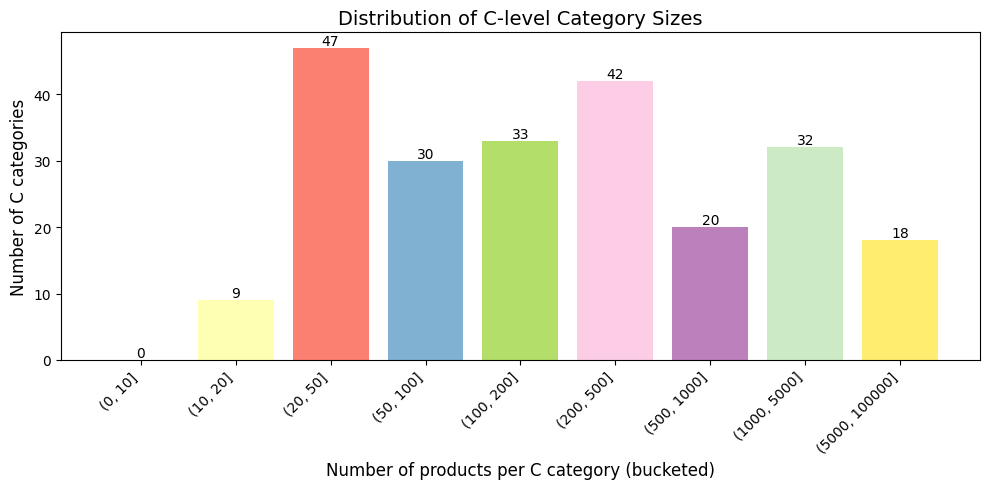

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Prepare data
bucket_labels = hist.index.astype(str)
counts = hist.values

colors = cm.Set3(np.linspace(0, 1, len(counts)))

plt.figure(figsize=(10,5))
bars = plt.bar(bucket_labels, counts, color=colors)

plt.title("Distribution of C-level Category Sizes", fontsize=14)
plt.xlabel("Number of products per C category (bucketed)", fontsize=12)
plt.ylabel("Number of C categories", fontsize=12)

plt.xticks(rotation=45, ha="right")

# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [55]:
# Average C-category size = ~2121 products
# → On average, each C-level category contains about 2,120 products.

# Median C-category size = 173 products
# → Half of the C categories have 173 or fewer products.
# → The distribution is highly skewed because a few huge categories (like “Notebooks”, “Notebook Parts & Accessories”) pull the average upward.

# The real center of your taxonomy is ~173 products per C-category.
# Categories with <50 products are clearly far below normal and should be removed.

In [56]:
# Size Range (products per C-category)	Number of C-categories
# (0, 10 products]	0 categories
# (10, 20 products]	9 categories
# (20, 50]	47 categories
# (50, 100]	30 categories
# (100, 200]	33 categories
# (200, 500]	42 categories
# (500, 1000]	20 categories
# (1000, 5000]	32 categories
# (5000, 100000]	18 categories

In [57]:
# [10, 20] → 9 categories
# → 9 C-level categories have between 11 and 20 products

# (100, 200] → 33 categories
# → 33 C categories have between 101 and 200 products

In [58]:
# We analyze how removing small C-level categories affects both C- and B-level
# structure. The results show that for moderate thresholds, weak C categories are
# removed while all 17 B categories remain intact. This analysis helps select a
# minimum C-level size that cleans the data without losing B-level categories.

In [59]:
import pandas as pd

def removal_summary_with_B(df, thresholds=[10,20,30,40,50,70,100,150,173,200,500,800,1000]):
    results = []
    
    # Count C and B category sizes
    c_counts = df['C'].value_counts()
    b_counts = df['B'].value_counts()

    for t in thresholds:
        # Keep only C categories with >= t items
        valid_C = c_counts[c_counts >= t].index

        # Keep rows matching valid C
        kept_rows_df = df[df['C'].isin(valid_C)]
        
        # Rows removed
        removed_rows = len(df) - len(kept_rows_df)

        # C categories removed
        removed_C = (c_counts < t).sum()
        kept_C = len(valid_C)

        # Now compute B categories kept after removing weak C categories
        kept_B = kept_rows_df['B'].nunique()
        removed_B = df['B'].nunique() - kept_B

        results.append({
            "Threshold": f"< {t}",
            "Total Rows": len(df),
            "Rows Removed": removed_rows,
            "Rows Removed (%)": round((removed_rows/len(df))*100, 2),
            "C Categories Removed": removed_C,
            "C Categories Kept": kept_C,
            "B Categories Removed": removed_B,
            "B Categories Kept": kept_B,
        })
    
    return pd.DataFrame(results)

summary_table_BC = removal_summary_with_B(df)
summary_table_BC


,Threshold,Total Rows,Rows Removed,Rows Removed (%),C Categories Removed,C Categories Kept,B Categories Removed,B Categories Kept
0,< 10,489902,0,0.00,0,231,0,17
1,< 20,489902,140,0.03,8,223,0,17
2,< 30,489902,661,0.13,30,201,0,17
3,< 40,489902,1234,0.25,46,185,0,17
4,< 50,489902,1680,0.34,56,175,0,17
5,< 70,489902,2444,0.50,69,162,0,17
6,< 100,489902,3809,0.78,85,146,0,17
7,< 150,489902,6992,1.43,111,120,0,17
8,< 173,489902,7637,1.56,115,116,0,17
9,< 200,489902,8009,1.63,117,114,0,17


In [60]:
# Rows removed: 1680 out of 489,902
# Rows removed %: 0.34% (almost nothing)
# This means you are not losing meaningful data, only long-tail noise.

# Identifying Removed C-Level Categories

# We list the exact C-level categories removed at different minimum size thresholds.
# These categories contain very few products and are unstable for embeddings,
# clustering, and LLM-based naming. Removing them reduces noise while preserving
# almost all meaningful data.

# It removes exactly the weak/unstable C-categories
#for eaxmple 
# At <50:
# 56 C-categories removed
# 175 C-categories kept
# The removed categories are the ones with <50 samples, which are extremely weak for:
# embeddings
# HDBSCAN clustering
# LLM naming
# These tiny categories cause instability and bad purity.



In [61]:
#Which C categories are removed at thresholds 50, 60, 70, 80, 100
import pandas as pd

def removed_C_categories(df, thresholds=[50, 60, 70, 80, 100]):
    """
    For each threshold T, list all C categories with <T products,
    along with their product counts.
    """
    
    c_counts = df['C'].value_counts()
    results = {}

    for t in thresholds:
        removed = c_counts[c_counts < t].sort_values()
        results[f"< {t}"] = removed
    
    return results


# --- RUN IT ---
thresholds = [50, 60, 70, 80, 100]
removed_dict = removed_C_categories(df, thresholds)

# --- PRINT CLEAN OUTPUT ---
for th, categories in removed_dict.items():
    print("="*80)
    print(f"C categories REMOVED at threshold {th}:")
    print(f"(Count = {len(categories)})")
    print("-"*80)
    print(categories)
    print("\n")


C categories REMOVED at threshold < 50:
(Count = 56)
--------------------------------------------------------------------------------
C
Cassette Players                                        16
Smart TV Boxes                                          16
ISDN Access Devices                                     17
AV Conferencing Bridges                                 17
Numeric Keypads                                         17
Cable Splitters or Combiners                            19
Portable Device Management Carts & Cabinets             19
All-in-One PC/Workstation Mounts & Stands               19
Paper Shredders                                         20
Fax Supplies                                            21
Selfie Sticks                                           21
Network Cable Testers                                   21
Remote Power Controllers                                21
Public Address (PA) Systems                             21
Car Kits                              

In [62]:
# We analyze how the removed C-level categories (<50 products) are distributed
# across B-level groups. The results show that weak C categories are concentrated
# in specific B categories, such as Networking. This confirms that C-level
# filtering removes long-tail noise without uniformly affecting all B categories

#analysis shows that 56 C-level categories have fewer than 50 products.
# These are the long-tail, rare, and unstable categories in the Icecat dataset.

# Networking is a B-level category, and it contains 12 C-level subcategories that each have fewer than 50 products.

In [63]:
# Which C categories are removed at <50
# How those C categories are distributed across their B parents
import pandas as pd

def removed_C_with_B(df, threshold=50):
    """
    Returns:
    1) A dataframe of removed C categories (<threshold) with product counts.
    2) A dataframe showing how these removed C categories distribute across B-level groups.
    """
    # Count category sizes
    c_counts = df["C"].value_counts()

    # Identify removed C categories (< threshold)
    removed_C = c_counts[c_counts < threshold]
    
    # Subset original df to only these removed categories
    removed_df = df[df["C"].isin(removed_C.index)][["A", "B", "C"]]

    # Count how many C categories removed per B category
    B_distribution = (
        removed_df.groupby("B")["C"]
        .nunique()               # number of C categories removed in each B
        .reset_index()
        .rename(columns={"C": "Removed_C_Count"})
        .sort_values("Removed_C_Count", ascending=False)
    )

    return removed_C, B_distribution


# ---- RUN IT ----
removed_C_50, B_dist_50 = removed_C_with_B(df, threshold=50)

print("============================================")
print("C CATEGORIES REMOVED AT THRESHOLD <50")
print("============================================")
print(f"TOTAL REMOVED: {len(removed_C_50)}\n")
print(removed_C_50.sort_values())

print("\n\n============================================")
print("B-LEVEL DISTRIBUTION OF REMOVED C CATEGORIES (<50)")
print("============================================")
print(B_dist_50)


C CATEGORIES REMOVED AT THRESHOLD <50
TOTAL REMOVED: 56

C
Cassette Players                                        16
Smart TV Boxes                                          16
ISDN Access Devices                                     17
AV Conferencing Bridges                                 17
Numeric Keypads                                         17
Cable Splitters or Combiners                            19
Portable Device Management Carts & Cabinets             19
All-in-One PC/Workstation Mounts & Stands               19
Paper Shredders                                         20
Fax Supplies                                            21
Selfie Sticks                                           21
Network Cable Testers                                   21
Remote Power Controllers                                21
Public Address (PA) Systems                             21
Car Kits                                                22
Parallel Cables                                         

In [64]:
## Applying Minimum C-Level Size Filter

# Based on the imbalance analysis, we filter out C-level categories with fewer
# than 100 products. This removes long-tail noise while retaining most of the
# dataset and all B-level categories. The filtered dataset is used for
# embedding generation and clustering.


In [65]:
import pandas as pd

# Step 1.1: Count products per C category
c_counts = df["C"].value_counts()

# Step 1.2: Keep only C categories with >= 100 products
valid_C = c_counts[c_counts >= 100].index

df_min100 = df[df["C"].isin(valid_C)].copy()

print("Original rows:", len(df))
print("Rows after min 100 filter:", len(df_min100))
print("Original C categories:", df["C"].nunique())
print("C categories kept (>=100):", df_min100["C"].nunique())


Original rows: 489902
Rows after min 100 filter: 486093
Original C categories: 231
C categories kept (>=100): 146


In [66]:
# Capping Maximum Samples per C Category

# To prevent large C-level categories from dominating the embedding space,
# we limit each C category to a maximum of 600 products. This balances the
# dataset while preserving all retained C categories. The resulting data
# is more suitable for embedding generation and clustering.


In [67]:
# For every C category, keep at most 600 products
df_min100_max600 = (
    df_min100
    .groupby("C", group_keys=False)
    .head(600)     # keeps first 600 rows per C
    .reset_index(drop=True)
)

print("Rows after max 600 per C:", len(df_min100_max600))
print("C categories after max 600:", df_min100_max600["C"].nunique())


Rows after max 600 per C: 59946
C categories after max 600: 146


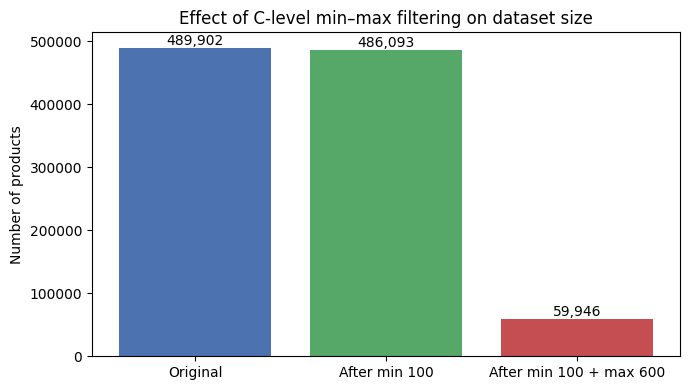

In [68]:
import matplotlib.pyplot as plt

labels = ["Original", "After min 100", "After min 100 + max 600"]
values = [
    len(df),
    len(df_min100),
    len(df_min100_max600)
]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values, color=["#4C72B0", "#55A868", "#C44E52"])

plt.ylabel("Number of products")
plt.title("Effect of C-level min–max filtering on dataset size")

# Data labels
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{h:,}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


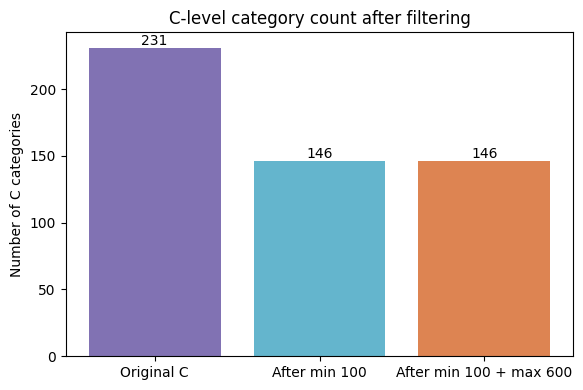

In [69]:
labels = ["Original C", "After min 100", "After min 100 + max 600"]
values = [
    df["C"].nunique(),
    df_min100["C"].nunique(),
    df_min100_max600["C"].nunique()
]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=["#8172B3", "#64B5CD", "#DD8452"])

plt.ylabel("Number of C categories")
plt.title("C-level category count after filtering")

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [70]:
#  Verification of C-Level Size Constraints

# We visualize the remaining A–B–C structure after applying minimum and maximum
# C-level size constraints. The output confirms that all C categories contain at
# least 100 and at most 600 products. This step serves as a final sanity check
# before embedding generation and clustering.

In [71]:
# 🌳 Tree View of B → C Categories With Product Counts
# Count remaining products per C
c_counts_final = df_min100_max600["C"].value_counts()

# Merge counts back to dataframe
df_tree = (
    df_min100_max600[["A", "B", "C"]]
    .drop_duplicates()
    .copy()
)

df_tree["count"] = df_tree["C"].map(c_counts_final)

# Sort for readability
df_tree = df_tree.sort_values(["B", "C"])


In [72]:
# Step 1: Count C-level products after min100/max600 filtering
c_counts_final = df_min100_max600["C"].value_counts()

# Step 2: Build unique A-B-C combinations
df_tree = (
    df_min100_max600[["A", "B", "C"]]
    .drop_duplicates()
    .copy()
)

df_tree["count"] = df_tree["C"].map(c_counts_final)

# Step 3: Sort for clean printing
df_tree = df_tree.sort_values(["A", "B", "C"])


In [73]:
current_a = None
current_b = None

for _, row in df_tree.iterrows():
    a = row["A"]
    b = row["B"]
    c = row["C"]
    cnt = row["count"]
    
    # Print A-level
    if a != current_a:
        print(f"\n🟦 A: {a}")
        current_a = a
        current_b = None
    
    # Print B-level
    if b != current_b:
        print(f"  🔷 B: {b}")
        current_b = b
    
    # Print C-level
    print(f"        └── C: {c}   ({cnt} products)")



🟦 A: Computers & Electronics
  🔷 B: Batteries & Power Supplies
        └── C: Battery Chargers   (479 products)
        └── C: Household Batteries   (600 products)
        └── C: Power Adapters & Inverters   (600 products)
        └── C: Power Banks   (600 products)
        └── C: Power Distribution Units (PDUs)   (600 products)
        └── C: Power Supply Units   (600 products)
        └── C: UPS Batteries   (402 products)
        └── C: Uninterruptible Power Supplies (UPSs)   (600 products)
  🔷 B: Computer Cables
        └── C: Audio Cables   (600 products)
        └── C: Cable Interface/Gender Adapters   (600 products)
        └── C: Coaxial Cables   (299 products)
        └── C: Component (YPbPr) Video Cables   (104 products)
        └── C: Composite Video Cables   (106 products)
        └── C: DVI Cables   (202 products)
        └── C: DisplayPort Cables   (221 products)
        └── C: Fibre Optic Cables   (600 products)
        └── C: HDMI Cables   (600 products)
        └── C: 

In [74]:
df_min100_max600.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 51 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Brand                                       59946 non-null  object 
 1   BrandInfo.BrandLocalName                    59946 non-null  object 
 2   BrandInfo.BrandLogo                         59716 non-null  object 
 3   BrandInfo.BrandName                         59946 non-null  object 
 4   BrandLogo                                   59716 non-null  object 
 5   BrandPartCode                               59946 non-null  object 
 6   BulletPoints                                54892 non-null  object 
 7   Category.CategoryID                         59946 non-null  int64  
 8   Category.Name.Language                      59946 non-null  object 
 9   Category.Name.Value                         59946 non-null  object 
 10  Descriptio

In [75]:
df_min100_max600[['ProductName',"BrandPartCode","Brand","Description.LongDesc","Description.LongProductName"]]

,ProductName,BrandPartCode,Brand,Description.LongDesc,Description.LongProductName
0,K31CD-IT049T,K31CD-IT049T,ASUS,<b>Smart Multimedia Performance</b><br>\nVivoP...,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA..."
1,686915-A41,686915-A41,HP,,Keyboard in midnight black finish with backlig...
2,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,37745,C2G,Get the performance you demand at a price that...,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...
3,C30,109559U,Lenovo,The C30 builds on its award-winning design as ...,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ..."
4,659501-BB1,659501-BB1,HP,,Keyboard in ash black for use in Israel (inclu...
...,...,...,...,...,...
59941,ZoneFlex P300,210-APOP,DELL,<b>Outdoor 2x2:2 5GHz 802.11ac point-to-point/...,Entry-Level 802.11ac 5GHZ Outdoor Access Point
59942,MP3 Player 256MB with SD Slot,49200,Verbatim,"- Skip-free music playback for MP3, WMA and WA...",MP3 Player 256MB with SD Slot
59943,FA2016,FA2016,ACT,- Extendable tray<br>\n- Good cable entry on t...,Patchpanel for assembled MTP®-MPO cassettes
59944,t610,C1C06UT,HP,"<b>Advanced technology, high-end deployment</b...","AMD Dual-Core T56N APU 1.65 GHz, AMD Radeon HD..."


In [76]:

# We select only relevant textual fields to generate semantic embeddings.
# Category labels (A, B, C) & path_3 are retained only for evaluation and not used
# as input features. This ensures that clustering is based purely on
# product semantics and avoids label leakage.

In [77]:
import pandas as pd

# Use the filtered df (min≥100, max≤600 per C)
df = df_min100_max600

cols_needed = [
    # "Brand",
    # "ProductName",
    "Description.LongProductName",
    "SummaryDescription.LongSummaryDescription",
    "Description.LongDesc",
    "A", "B", "C",
    "path_3"   # for later evaluation
]

df_clean = df[cols_needed].copy()
print(len(df_clean), "rows in df_clean")
df_clean.head(3)


59946 rows in df_clean


,Description.LongProductName,SummaryDescription.LongSummaryDescription,Description.LongDesc,A,B,C,path_3
0,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",ASUS K31CD-IT049T. Processor frequency: 3.4 GH...,<b>Smart Multimedia Performance</b><br>\nVivoP...,Computers & Electronics,Computers,PCs/Workstations,Computers & Electronics > Computers > PCs/Work...
1,Keyboard in midnight black finish with backlig...,HP 686915-A41. Type: Keyboard. Keyboard langua...,,Computers & Electronics,Computers,Notebook Parts & Accessories,Computers & Electronics > Computers > Notebook...
2,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,C2G 1m ST/SC Plenum-Rated 9/125 Duplex Single-...,Get the performance you demand at a price that...,Computers & Electronics,Computer Cables,Fibre Optic Cables,Computers & Electronics > Computer Cables > Fi...


In [78]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Description.LongProductName                53152 non-null  object
 1   SummaryDescription.LongSummaryDescription  59946 non-null  object
 2   Description.LongDesc                       53152 non-null  object
 3   A                                          59946 non-null  object
 4   B                                          59946 non-null  object
 5   C                                          59946 non-null  object
 6   path_3                                     59946 non-null  object
dtypes: object(7)
memory usage: 3.2+ MB


In [79]:
## Text Construction and Cleaning

# We combine the selected textual fields into a single metadata text per product.
# Basic cleaning is applied to remove HTML tags and normalize spacing.
# The cleaned text is used as input for embedding generation.


In [80]:
def build_metadata(row):
    parts = []

    # if pd.notna(row["Brand"]):
    #     parts.append(row["Brand"])
        
    # if pd.notna(row["ProductName"]):
    #     parts.append(row["ProductName"])

    if pd.notna(row["Description.LongProductName"]):
        parts.append(row["Description.LongProductName"])

    if pd.notna(row["SummaryDescription.LongSummaryDescription"]):
        parts.append(row["SummaryDescription.LongSummaryDescription"])

    if pd.notna(row["Description.LongDesc"]):
        parts.append(row["Description.LongDesc"])

    return " ".join(parts)

df_clean["metadata_text"] = df_clean.apply(build_metadata, axis=1)
df_clean["metadata_text"].head(3)


0    Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...
1    Keyboard in midnight black finish with backlig...
2    1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...
Name: metadata_text, dtype: object

In [81]:
# Length BEFORE cleaning
df_clean["meta_len_raw"] = df_clean["metadata_text"].apply(lambda x: len(str(x)))


In [82]:
import re

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = re.sub(r"<[^>]+>", " ", t)   # remove HTML tags
    t = re.sub(r"\s+", " ", t)       # collapse spaces
    t = t.replace("\xa0", " ")       # non-breaking space
    return t.strip()

df_clean["metadata_text_clean"] = df_clean["metadata_text"].apply(clean_text)

# length stats
df_clean["meta_len"] = df_clean["metadata_text_clean"].apply(lambda x: len(str(x)))
print(df_clean["meta_len"].describe())


count    59946.000000
mean      1141.452607
std       1360.684835
min          2.000000
25%        332.000000
50%        748.000000
75%       1412.000000
max      27286.000000
Name: meta_len, dtype: float64


In [83]:
df_clean

,Description.LongProductName,SummaryDescription.LongSummaryDescription,Description.LongDesc,A,B,C,path_3,metadata_text,meta_len_raw,metadata_text_clean,meta_len
0,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",ASUS K31CD-IT049T. Processor frequency: 3.4 GH...,<b>Smart Multimedia Performance</b><br>\nVivoP...,Computers & Electronics,Computers,PCs/Workstations,Computers & Electronics > Computers > PCs/Work...,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",3784,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",3626
1,Keyboard in midnight black finish with backlig...,HP 686915-A41. Type: Keyboard. Keyboard langua...,,Computers & Electronics,Computers,Notebook Parts & Accessories,Computers & Electronics > Computers > Notebook...,Keyboard in midnight black finish with backlig...,275,Keyboard in midnight black finish with backlig...,274
2,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,C2G 1m ST/SC Plenum-Rated 9/125 Duplex Single-...,Get the performance you demand at a price that...,Computers & Electronics,Computer Cables,Fibre Optic Cables,Computers & Electronics > Computer Cables > Fi...,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,1946,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,1758
3,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ...",Lenovo ThinkStation C30. Processor frequency: ...,The C30 builds on its award-winning design as ...,Computers & Electronics,Computers,PCs/Workstations,Computers & Electronics > Computers > PCs/Work...,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ...",2943,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ...",2886
4,Keyboard in ash black for use in Israel (inclu...,HP 659501-BB1. Type: Keyboard. Keyboard langua...,,Computers & Electronics,Computers,Notebook Parts & Accessories,Computers & Electronics > Computers > Notebook...,Keyboard in ash black for use in Israel (inclu...,177,Keyboard in ash black for use in Israel (inclu...,176
...,...,...,...,...,...,...,...,...,...,...,...
59941,Entry-Level 802.11ac 5GHZ Outdoor Access Point,DELL ZoneFlex P300. Maximum data transfer rate...,<b>Outdoor 2x2:2 5GHz 802.11ac point-to-point/...,Computers & Electronics,Networking,WLAN Access Points,Computers & Electronics > Networking > WLAN Ac...,Entry-Level 802.11ac 5GHZ Outdoor Access Point...,2141,Entry-Level 802.11ac 5GHZ Outdoor Access Point...,2035
59942,MP3 Player 256MB with SD Slot,Verbatim MP3 Player 256MB with SD Slot. Voice ...,"- Skip-free music playback for MP3, WMA and WA...",Computers & Electronics,Consumer Audio & Video Equipment,MP3/MP4 Players,Computers & Electronics > Consumer Audio & Vid...,MP3 Player 256MB with SD Slot Verbatim MP3 Pla...,523,MP3 Player 256MB with SD Slot Verbatim MP3 Pla...,498
59943,Patchpanel for assembled MTP®-MPO cassettes,"ACT FA2016. Product colour: Black, Material: M...",- Extendable tray<br>\n- Good cable entry on t...,Computers & Electronics,Networking,Patch Panels,Computers & Electronics > Networking > Patch P...,Patchpanel for assembled MTP®-MPO cassettes AC...,179,Patchpanel for assembled MTP®-MPO cassettes AC...,171
59944,"AMD Dual-Core T56N APU 1.65 GHz, AMD Radeon HD...","HP t610. Processor frequency: 1.65 GHz, Proces...","<b>Advanced technology, high-end deployment</b...",Computers & Electronics,Computers,Thin Clients,Computers & Electronics > Computers > Thin Cli...,"AMD Dual-Core T56N APU 1.65 GHz, AMD Radeon HD...",3376,"AMD Dual-Core T56N APU 1.65 GHz, AMD Radeon HD...",3221


In [84]:
df_clean['meta_len'].max()

np.int64(27286)

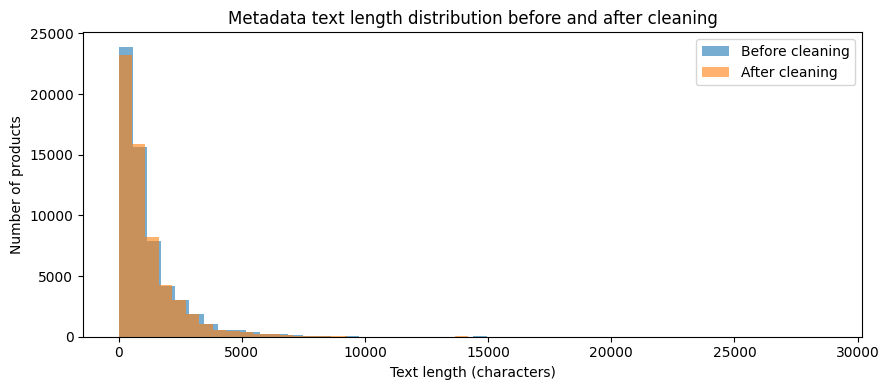

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))

plt.hist(
    df_clean["meta_len_raw"],
    bins=50,
    alpha=0.6,
    label="Before cleaning"
)

plt.hist(
    df_clean["meta_len"],
    bins=50,
    alpha=0.6,
    label="After cleaning"
)

plt.xlabel("Text length (characters)")
plt.ylabel("Number of products")
plt.title("Metadata text length distribution before and after cleaning")
plt.legend()

plt.tight_layout()
plt.show()


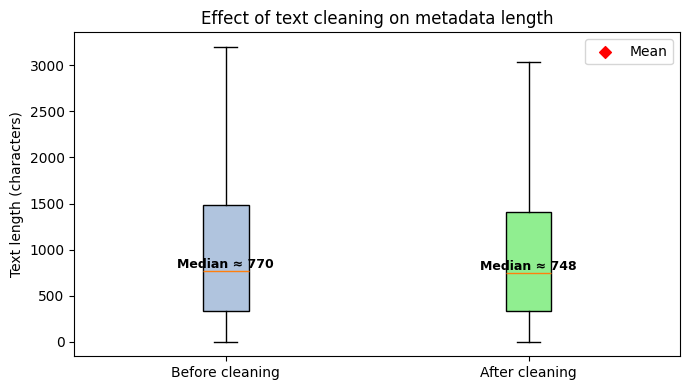

In [86]:
import numpy as np
import matplotlib.pyplot as plt

before = df_clean["meta_len_raw"]
after = df_clean["meta_len"]

plt.figure(figsize=(7,4))

bp = plt.boxplot(
    [before, after],
    labels=["Before cleaning", "After cleaning"],
    showfliers=False,
    patch_artist=True
)

# Colors
colors = ["#B0C4DE", "#90EE90"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

# Mean markers
means = [before.mean(), after.mean()]
plt.scatter([1, 2], means, color="red", marker="D", label="Mean")

# Median labels
medians = [np.median(before), np.median(after)]
for i, median in enumerate(medians, start=1):
    plt.text(
        i,
        median,
        f"Median ≈ {int(median)}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.ylabel("Text length (characters)")
plt.title("Effect of text cleaning on metadata length")
plt.legend()

plt.tight_layout()
plt.show()


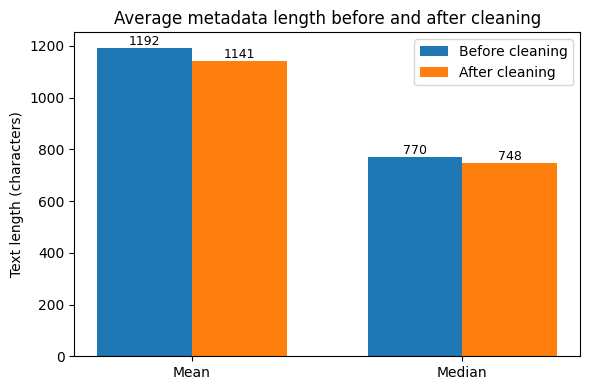

In [87]:
import numpy as np

stats_labels = ["Mean", "Median"]
before_stats = [
    df_clean["meta_len_raw"].mean(),
    df_clean["meta_len_raw"].median()
]
after_stats = [
    df_clean["meta_len"].mean(),
    df_clean["meta_len"].median()
]

x = np.arange(len(stats_labels))
width = 0.35

plt.figure(figsize=(6,4))
bars1 = plt.bar(x - width/2, before_stats, width, label="Before cleaning")
bars2 = plt.bar(x + width/2, after_stats, width, label="After cleaning")

plt.xticks(x, stats_labels)
plt.ylabel("Text length (characters)")
plt.title("Average metadata length before and after cleaning")
plt.legend()

# Data labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()


In [88]:
#  Embedding Generation and Dimensionality Reduction

# We generate semantic embeddings from the cleaned product text using a
# SentenceTransformer model. The embeddings are then reduced using UMAP to
# preserve semantic structure while making them suitable for clustering.
# These reduced embeddings are used for C-level clustering.


In [89]:
import torch
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# st_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
st_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)
# st_model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1", device=device)


embeddings = st_model.encode(
    df_clean["metadata_text_clean"].fillna("").tolist(),
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings shape:", embeddings.shape)


Using device: cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Embeddings shape: (59946, 768)


In [90]:
from umap import UMAP

umap_model = UMAP(
    n_neighbors=15,        # local structure
    min_dist=0.0,          # tight clusters
    n_components=10,       # enough for clustering
    metric="cosine",       # best for normalized embeddings
    random_state=42
)

reduced = umap_model.fit_transform(embeddings)
print("Reduced shape:", reduced.shape)   # (59946, 15) approx


Reduced shape: (59946, 10)


In [91]:
# Each dot = one product
# Distance between dots ≈ semantic similarity

# The figure visualizes a two-dimensional UMAP projection of sentence-level product embeddings generated from cleaned textual metadata.
#     Each point represents a product, and spatial proximity reflects semantic similarity. 
#     The presence of dense regions and distinct sub-structures indicates that the embedding space captures meaningful semantic patterns prior to clustering. 
#     Isolated points correspond to products with unique or sparse descriptions and are expected to be treated as noise by density-based clustering methods.

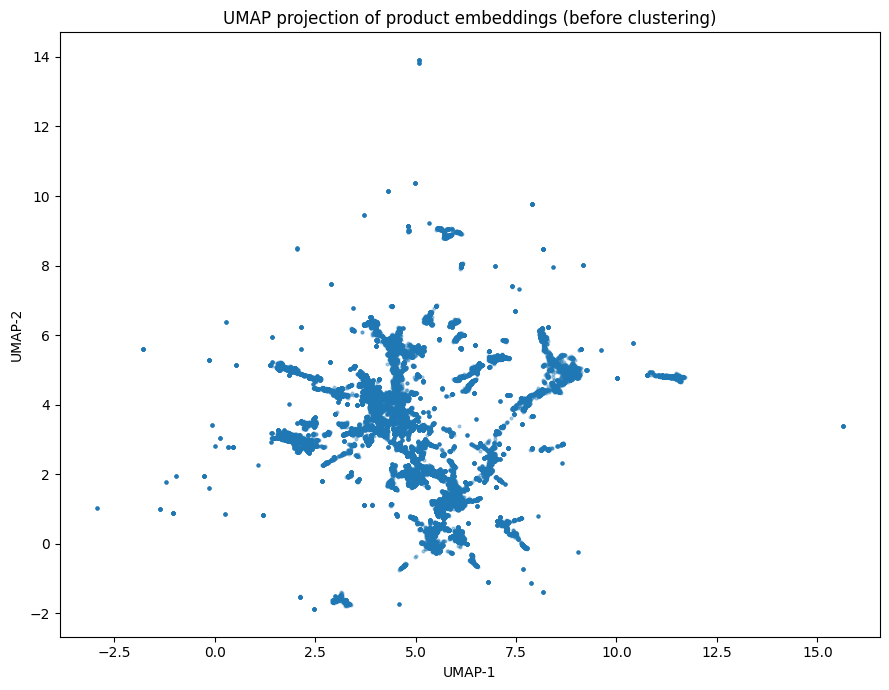

In [92]:
plt.figure(figsize=(9,7))
plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    s=4,
    alpha=0.35,
    color="#1f77b4"
)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP projection of product embeddings (before clustering)")
plt.tight_layout()
plt.show()


In [93]:
# What this plot shows
# Each hexagon represents a region in embedding space
# Color intensity = how many products fall into that region
# Darker = high semantic density

# Dark central zones
# → Large groups of products with very similar descriptions
# → Typical, common product types (e.g., mainstream electronics)

# Lighter surrounding regions
# → Less frequent or more specialized products

# Sparse outer areas / isolated patches
# → Rare products or highly specific descriptions
# → Likely candidates for noise or small clusters in OPTICS

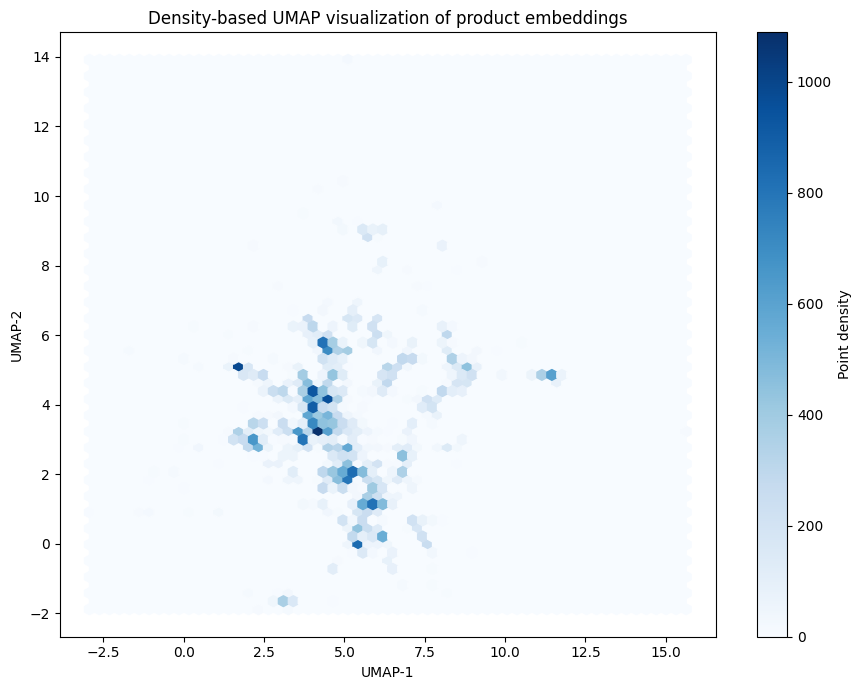

In [94]:
plt.figure(figsize=(9,7))
plt.hexbin(
    reduced[:, 0],
    reduced[:, 1],
    gridsize=60,
    cmap="Blues"
)

plt.colorbar(label="Point density")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Density-based UMAP visualization of product embeddings")
plt.tight_layout()
plt.show()


In [95]:
#  C-Level Clustering Using OPTICS

# We apply OPTICS clustering on the UMAP-reduced embeddings to discover
# data-driven C-level clusters. OPTICS is chosen to handle varying cluster
# densities and long-tail structures without fixing the number of clusters.
# The resulting cluster assignments are used for purity evaluation.


In [96]:
from sklearn.cluster import OPTICS

# OPTICS on UMAP-reduced embeddings
optics = OPTICS(
    min_samples=15,        # like density smoothness
    min_cluster_size=100,   # similar to your HDBSCAN setting
    xi=0.05,               # how aggressively to split clusters
    metric="euclidean"     # UMAP space → euclidean
)

optics_labels = optics.fit_predict(reduced)

df_clean["optics_cluster_id"] = optics_labels

print("Unique OPTICS labels:", sorted(set(optics_labels)))


Unique OPTICS labels: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int6

In [97]:
# OPTICS Clustering on UMAP-Reduced Embeddings.

# The figure shows the result of OPTICS clustering applied to the UMAP-reduced embedding space. Dense semantic regions are grouped into clusters,
#     while sparse or ambiguous products are assigned to a noise class. 
#     This behavior allows the model to adapt to varying cluster densities and prevents the formation of spurious clusters, 
#     making OPTICS suitable for real-world product data.

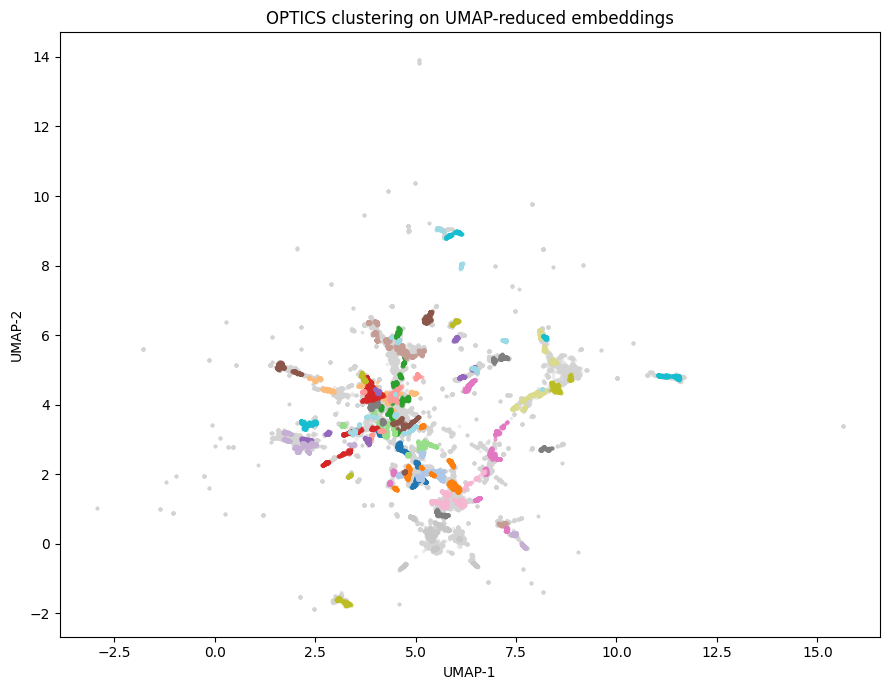

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

labels = df_clean["optics_cluster_id"].values
unique_labels = np.unique(labels)

plt.figure(figsize=(9,7))

# Colormap (skip noise)
colors = cm.tab20(np.linspace(0, 1, len(unique_labels)))

color_idx = 0
for lab in unique_labels:
    mask = labels == lab

    if lab == -1:
        plt.scatter(
            reduced[mask, 0],
            reduced[mask, 1],
            c="lightgray",
            s=3,
            alpha=0.3,
            label="Noise"
        )
    else:
        plt.scatter(
            reduced[mask, 0],
            reduced[mask, 1],
            color=colors[color_idx],
            s=4,
            alpha=0.6
        )
        color_idx += 1

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("OPTICS clustering on UMAP-reduced embeddings")
plt.tight_layout()
plt.show()


In [99]:


# 🔹 X-axis: Ordered points
# Products are reordered by OPTICS
# Points belonging to the same cluster appear next to each other

# 🔹 Y-axis: Reachability distance
# Low bar → point lies in a dense region
# High bar → point is far from dense regions

# 🔹 Valleys (many short bars together)
# Represent clusters
# Products are very similar to each other

# 🔹 Tall spikes

# Represent gaps between clusters
# Or outliers / noise

# 🔹 Gray bars
# Points labeled as noise (-1) by OPTICS

# plot:

# Most bars are very close to zero
# → many products form dense semantic groups

# Several isolated tall spikes
# → clear separations between clusters

# Noise points are interspersed, not dominating
# → clustering is stable, not over-fragmented

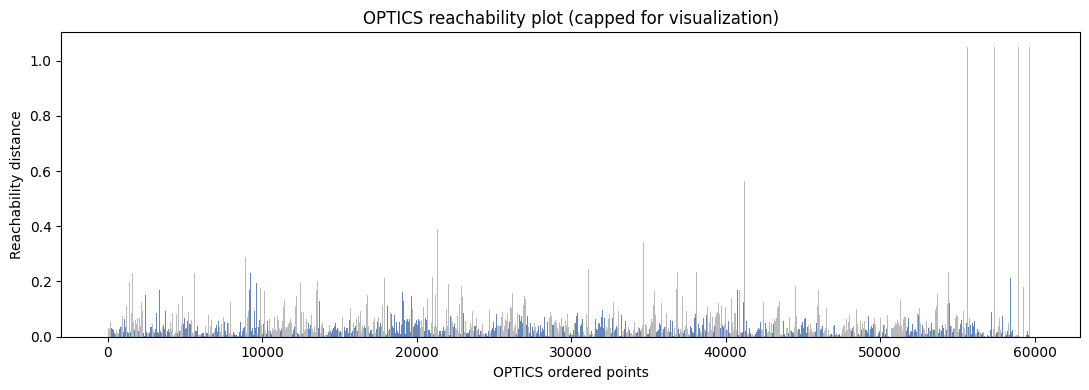

In [100]:
import numpy as np
import matplotlib.pyplot as plt

space = np.arange(len(optics.reachability_))
reachability = optics.reachability_[optics.ordering_]
labels_ord = optics.labels_[optics.ordering_]

# Cap extreme values for readability
reach_cap = np.percentile(reachability, 99)
reachability_plot = np.clip(reachability, 0, reach_cap)

colors = [
    "#B0B0B0" if lab == -1 else "#4C72B0"
    for lab in labels_ord
]

plt.figure(figsize=(11,4))
plt.bar(
    space,
    reachability_plot,
    color=colors,
    width=1.0,
    alpha=0.85
)

plt.ylabel("Reachability distance")
plt.xlabel("OPTICS ordered points")
plt.title("OPTICS reachability plot (capped for visualization)")

plt.tight_layout()
plt.show()


In [101]:
df_clean.head(5)

,Description.LongProductName,SummaryDescription.LongSummaryDescription,Description.LongDesc,A,B,C,path_3,metadata_text,meta_len_raw,metadata_text_clean,meta_len,optics_cluster_id
0,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",ASUS K31CD-IT049T. Processor frequency: 3.4 GH...,<b>Smart Multimedia Performance</b><br>\nVivoP...,Computers & Electronics,Computers,PCs/Workstations,Computers & Electronics > Computers > PCs/Work...,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",3784,"Intel Core i7-6700 (8M Cache, 3.4GHz), 16GB RA...",3626,-1
1,Keyboard in midnight black finish with backlig...,HP 686915-A41. Type: Keyboard. Keyboard langua...,,Computers & Electronics,Computers,Notebook Parts & Accessories,Computers & Electronics > Computers > Notebook...,Keyboard in midnight black finish with backlig...,275,Keyboard in midnight black finish with backlig...,274,45
2,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,C2G 1m ST/SC Plenum-Rated 9/125 Duplex Single-...,Get the performance you demand at a price that...,Computers & Electronics,Computer Cables,Fibre Optic Cables,Computers & Electronics > Computer Cables > Fi...,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,1946,1m ST/SC Plenum-Rated 9/125 Duplex Single-Mode...,1758,111
3,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ...",Lenovo ThinkStation C30. Processor frequency: ...,The C30 builds on its award-winning design as ...,Computers & Electronics,Computers,PCs/Workstations,Computers & Electronics > Computers > PCs/Work...,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ...",2943,"Intel Xeon E5-2620 (15M Cache, 2.00 GHz, 7.20 ...",2886,-1
4,Keyboard in ash black for use in Israel (inclu...,HP 659501-BB1. Type: Keyboard. Keyboard langua...,,Computers & Electronics,Computers,Notebook Parts & Accessories,Computers & Electronics > Computers > Notebook...,Keyboard in ash black for use in Israel (inclu...,177,Keyboard in ash black for use in Israel (inclu...,176,45


In [102]:
import pandas as pd
import numpy as np

# --------------------------------------------------
# Function: Detailed purity computation
# --------------------------------------------------
def compute_cluster_purity_detailed(df, cluster_col, label_col):
    """
    Computes detailed purity statistics for each cluster.
    Returns:
      - DataFrame with per-cluster stats
      - Overall weighted purity
      - Overall impurity
    """
    cluster_stats = []
    total_points = len(df)

    for cluster_id, cluster_df in df.groupby(cluster_col):
        cluster_size = len(cluster_df)

        label_counts = cluster_df[label_col].value_counts()

        dominant_label = label_counts.index[0]
        dominant_count = label_counts.iloc[0]

        wrong_count = cluster_size - dominant_count
        top3 = label_counts.head(3).to_dict()

        purity = dominant_count / cluster_size

        cluster_stats.append({
            "cluster_id": cluster_id,
            "cluster_size": cluster_size,
            "dominant_C": dominant_label,
            "dominant_C_count": dominant_count,
            "wrong_products": wrong_count,
            "top3_C_distribution": top3,
            "purity": purity
        })

    purity_df = pd.DataFrame(cluster_stats)

    overall_purity = np.sum(
        purity_df["purity"] * purity_df["cluster_size"]
    ) / total_points

    overall_impurity = 1 - overall_purity

    return purity_df.sort_values("purity"), overall_purity, overall_impurity


# # ==================================================
# # 1️⃣ PURITY WITH NOISE INCLUDED
# # ==================================================
# c_purity_with_noise, purity_with_noise, impurity_with_noise = (
#     compute_cluster_purity_detailed(
#         df_clean,
#         cluster_col="optics_cluster_id",
#         label_col="C"
#     )
# )

# print("===== C-LEVEL PURITY (WITH NOISE) =====")
# print("Overall Purity:", round(purity_with_noise, 4))
# print("Overall Impurity:", round(impurity_with_noise, 4))
# print("\nLowest-purity clusters:")
# print(c_purity_with_noise.head(5))


# ==================================================
# 2️⃣ PURITY  (cluster_id = -1 removed)
# ==================================================
df_no_noise = df_clean[df_clean["optics_cluster_id"] != -1].copy()

# print("\nNoise rows removed:", len(df_clean) - len(df_no_noise))
# print("Rows used (no noise):", len(df_no_noise))

c_purity_no_noise, purity_no_noise, impurity_no_noise = (
    compute_cluster_purity_detailed(
        df_no_noise,
        cluster_col="optics_cluster_id",
        label_col="C"
    )
)

print("\n===== C-LEVEL PURITY (WITHOUT NOISE) =====")
print("Overall Purity:", round(purity_no_noise, 4))
print("Overall Impurity:", round(impurity_no_noise, 4))
print("\nLowest-purity clusters (no noise):")
print(c_purity_no_noise.head(5))



===== C-LEVEL PURITY (WITHOUT NOISE) =====
Overall Purity: 0.8311
Overall Impurity: 0.1689

Lowest-purity clusters (no noise):
    cluster_id  cluster_size              dominant_C  dominant_C_count  \
37          37           100  Flat Panel Accessories                17   
36          36           113             Stylus Pens                21   
56          56           105             HDMI Cables                26   
65          65           475    Video Cable Adapters               154   
1            1           107        PCs/Workstations                38   

    wrong_products                                top3_C_distribution  \
37              83  {'Flat Panel Accessories': 17, 'Mouse Pads': 1...   
36              92  {'Stylus Pens': 21, 'Smartwatch Accessories': ...   
56              79  {'HDMI Cables': 26, 'VGA Cables': 12, 'Interna...   
65             321  {'Video Cable Adapters': 154, 'DisplayPort Cab...   
1               69  {'PCs/Workstations': 38, 'Notebooks': 33, 

In [103]:
# --------------------------------------------------
# Detailed per-cluster reporting
# --------------------------------------------------

# Remove noise points
df_no_noise = df_clean[df_clean["optics_cluster_id"] != -1].copy()

# print("Total rows (no noise):", len(df_no_noise))
# print("Number of clusters (no noise):", df_no_noise["optics_cluster_id"].nunique())


def print_cluster_details(df, cluster_col, label_col, top_k=3):
    """
    Prints detailed statistics for each cluster:
    - cluster id
    - cluster size
    - dominant C category
    - dominant C count
    - wrong product count
    - top-k C categories
    - purity
    """
    for cluster_id, cluster_df in df.groupby(cluster_col):
        cluster_size = len(cluster_df)

        label_counts = cluster_df[label_col].value_counts()

        dominant_c = label_counts.index[0]
        dominant_count = label_counts.iloc[0]

        wrong_count = cluster_size - dominant_count
        purity = dominant_count / cluster_size

        print("\n" + "=" * 80)
        print(f"Cluster ID: {cluster_id}")
        print(f"Cluster size: {cluster_size}")
        print(f"Dominant C category: {dominant_c}")
        print(f"Dominant C count: {dominant_count}")
        print(f"Wrong products count: {wrong_count}")
        print(f"Purity: {purity:.4f}")
        print(f"Top-{top_k} C categories:")

        for c_name, cnt in label_counts.head(top_k).items():
            print(f"  - {c_name}: {cnt}")

    print("\n" + "=" * 80)


# ---- RUN IT ----
print_cluster_details(
    df_no_noise,
    cluster_col="optics_cluster_id",
    label_col="C",
    top_k=3
)



Cluster ID: 0
Cluster size: 129
Dominant C category: Notebooks
Dominant C count: 73
Wrong products count: 56
Purity: 0.5659
Top-3 C categories:
  - Notebooks: 73
  - All-in-One PCs/Workstations: 36
  - PCs/Workstations: 15

Cluster ID: 1
Cluster size: 107
Dominant C category: PCs/Workstations
Dominant C count: 38
Wrong products count: 69
Purity: 0.3551
Top-3 C categories:
  - PCs/Workstations: 38
  - Notebooks: 33
  - All-in-One PCs/Workstations: 30

Cluster ID: 2
Cluster size: 157
Dominant C category: All-in-One PCs/Workstations
Dominant C count: 78
Wrong products count: 79
Purity: 0.4968
Top-3 C categories:
  - All-in-One PCs/Workstations: 78
  - Notebooks: 63
  - PCs/Workstations: 15

Cluster ID: 3
Cluster size: 116
Dominant C category: PCs/Workstations
Dominant C count: 76
Wrong products count: 40
Purity: 0.6552
Top-3 C categories:
  - PCs/Workstations: 76
  - All-in-One PCs/Workstations: 37
  - PC/Workstation Barebones: 2

Cluster ID: 4
Cluster size: 101
Dominant C category: PCs/

In [104]:
#top 10 pure clusters

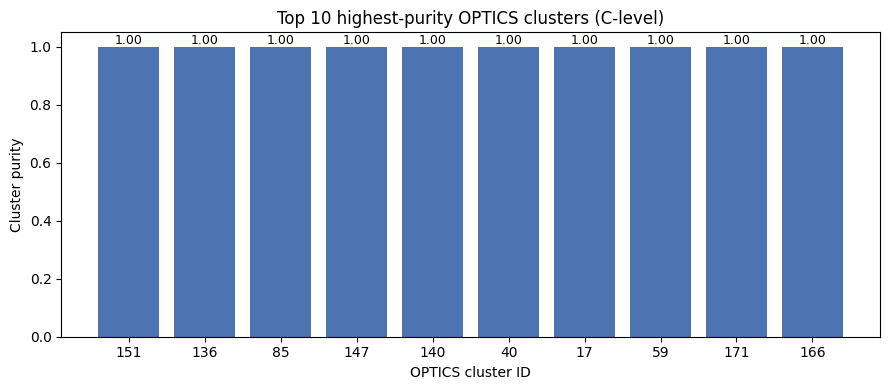

In [105]:
import matplotlib.pyplot as plt

top_k = 10
top_pure = c_purity_no_noise.sort_values("purity", ascending=False).head(top_k)

plt.figure(figsize=(9,4))
bars = plt.bar(
    top_pure["cluster_id"].astype(str),
    top_pure["purity"],
    color="#4C72B0"
)

plt.xlabel("OPTICS cluster ID")
plt.ylabel("Cluster purity")
plt.title(f"Top {top_k} highest-purity OPTICS clusters (C-level)")
plt.ylim(0, 1.05)

# Data labels
for bar, purity in zip(bars, top_pure["purity"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        purity,
        f"{purity:.2f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [106]:
#bottom 10 clusters with lowest purity

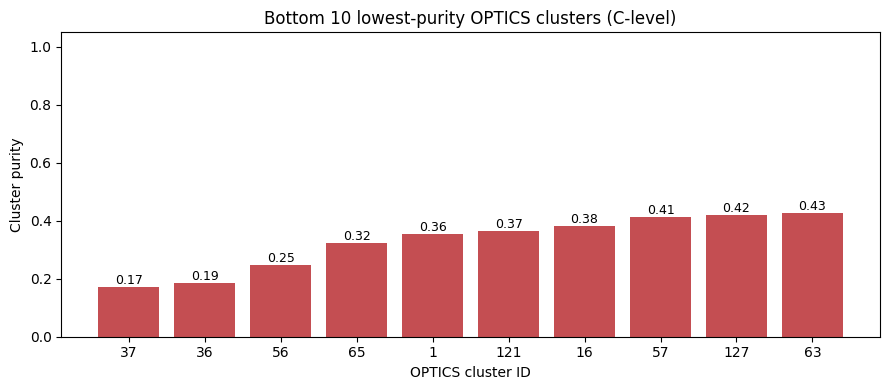

In [107]:
bottom_k = 10
bottom_pure = c_purity_no_noise.sort_values("purity").head(bottom_k)

plt.figure(figsize=(9,4))
bars = plt.bar(
    bottom_pure["cluster_id"].astype(str),
    bottom_pure["purity"],
    color="#C44E52"
)

plt.xlabel("OPTICS cluster ID")
plt.ylabel("Cluster purity")
plt.title(f"Bottom {bottom_k} lowest-purity OPTICS clusters (C-level)")
plt.ylim(0, 1.05)

for bar, purity in zip(bars, bottom_pure["purity"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        purity,
        f"{purity:.2f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [108]:
# --------------------------------------------------
# Choose the cluster you want to inspect
# --------------------------------------------------
cluster_id_to_view = 25

cluster_data = df_no_noise[
    df_no_noise["optics_cluster_id"] == cluster_id_to_view
]

print("Cluster ID:", cluster_id_to_view)
print("Number of products:", len(cluster_data))


# --------------------------------------------------
# Compute purity details for THIS cluster only
# --------------------------------------------------
label_counts = cluster_data["C"].value_counts()

dominant_c = label_counts.index[0]
dominant_c_count = label_counts.iloc[0]

cluster_size = len(cluster_data)
wrong_products = cluster_size - dominant_c_count

purity = dominant_c_count / cluster_size
impurity = 1 - purity

print("\n--- Cluster Quality Summary ---")
print("Dominant C category:", dominant_c)
print("Dominant C count:", dominant_c_count)
print("Wrong products:", wrong_products)
print("Purity:", round(purity, 4))
print("Impurity:", round(impurity, 4))

print("\nTop 3 C categories in this cluster:")
print(label_counts.head(3))


# --------------------------------------------------
# Display sample rows from the cluster
# --------------------------------------------------
cluster_data[
    [
        "optics_cluster_id",
        "C",
        "metadata_text_clean",
        "A",
        "B"
    ]
].head(20)


Cluster ID: 25
Number of products: 118

--- Cluster Quality Summary ---
Dominant C category: Thin Clients
Dominant C count: 116
Wrong products: 2
Purity: 0.9831
Impurity: 0.0169

Top 3 C categories in this cluster:
C
Thin Clients           116
Notebooks                1
Networking Software      1
Name: count, dtype: int64


,optics_cluster_id,C,metadata_text_clean,A,B
1878,25,Thin Clients,HP t510 Flexible Thin Client (ENERGY STAR) Bundle,Computers & Electronics,Computers
3618,25,Notebooks,Stream - 14-ds0100nr HP Stream - 14-ds0100nr S...,Computers & Electronics,Computers
11300,25,Networking Software,HP ThinPro for PC Converter,Computers & Electronics,Software
11541,25,Thin Clients,Neoware e140 Thin Client HP Neoware e140 Thin ...,Computers & Electronics,Computers
12144,25,Thin Clients,"Intel Atom N280 (1.66 GHz), 2GB DDR3 SDRAM, 4G...",Computers & Electronics,Computers
15159,25,Thin Clients,HP t5565 Thin Client HP t5565. Processor frequ...,Computers & Electronics,Computers
15383,25,Thin Clients,"AMD GX-415GA (2M Cache, 1.5 GHz), 4GB DDR3L, 1...",Computers & Electronics,Computers
16095,25,Thin Clients,"AMD GX-217GA (1M Cache, 1.65 GHz), 4GB DDR3L, ...",Computers & Electronics,Computers
17042,25,Thin Clients,"AMD RX-427BB (2.7GHz, 4MB), 8GB (2 x 4GB) DDR3...",Computers & Electronics,Computers
17187,25,Thin Clients,mt40 Mobile Thin Client HP mt40 Mobile Thin Cl...,Computers & Electronics,Computers


In [109]:
import numpy as np

labels = df_clean["optics_cluster_id"].values

Unique_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Total clusters formed:", Unique_clusters)


Total clusters formed: 184


In [110]:
#Count clusters properly (excluding noise)
cluster_sizes = pd.Series(labels[labels != -1]).value_counts()
cluster_sizes.head(10)


62     663
102    634
64     554
49     547
65     475
51     394
82     389
118    365
172    355
155    315
Name: count, dtype: int64

In [111]:
#Full summary statistics of cluster sizes
cluster_sizes.describe()


count    184.000000
mean     152.630435
std       89.263803
min      100.000000
25%      110.750000
50%      122.000000
75%      151.500000
max      663.000000
Name: count, dtype: float64

In [112]:
df_clean[df_clean["optics_cluster_id"] == 45][[
    # "ProductName",
    # "Brand",
    "C",
    "B",
    "metadata_text_clean"
]].head(20)


,C,B,metadata_text_clean
1,Notebook Parts & Accessories,Computers,Keyboard in midnight black finish with backlig...
4,Notebook Parts & Accessories,Computers,Keyboard in ash black for use in Israel (inclu...
13,Notebook Parts & Accessories,Computers,Top Cover & Keyboard (Italy) HP Top Cover & Ke...
61,Notebook Parts & Accessories,Computers,"Keyboard (Greek), Black DELL N8YN. Type: Keybo..."
66,Notebook Parts & Accessories,Computers,UPPER CASE W/TP KB(ITALIAN) BACKLIGHT BLACK Ac...
226,Notebook Parts & Accessories,Computers,"Keyboard, Spanish, 85-Key, Black Acer KB.I110A..."
230,Notebook Parts & Accessories,Computers,Keyboard/top cover in natural silver finish (i...
279,Notebook Parts & Accessories,Computers,"Keyboard (Spanish), Black HP 699930-071. Type:..."
325,Notebook Parts & Accessories,Computers,"Keyboard (German), Black HP 500637-041. Type: ..."
337,Notebook Parts & Accessories,Computers,"Keyboard (USA), White Acer KB.INT00.706. Type:..."


In [113]:
#list all cluster and their sizes
df_clean["optics_cluster_id"].value_counts()


optics_cluster_id
-1      31862
 62       663
 102      634
 64       554
 49       547
        ...  
 101      100
 37       100
 136      100
 163      100
 68       100
Name: count, Length: 185, dtype: int64

In [114]:
cluster_id = 10   # ← choose any cluster

cluster_products = df_clean[df_clean["optics_cluster_id"] == cluster_id][[
    # "ProductName", "Brand", "C", "B", "metadata_text_clean"
     "C", "B", "metadata_text_clean"
]]

cluster_products


,C,B,metadata_text_clean
751,Chassis Components,Computer Components,"EdgeReady™ Micro Data Center - 21U, 3 kVA UPS,..."
996,Data Storage Devices,Data Storage,"7200GB, up to 24x 6.35 cm (2.5"") SAS/SSD, RAID..."
1261,Servers,Computers,"Intel Xeon E5-2620 v4, 8GB (DDR4), 300GB (SAS)..."
1378,PCs/Workstations,Computers,"Intel Xeon E3-1220 V2 3.1GHz, 8GB DDR3 1600MHz..."
7608,System Components,Computer Components,Intel DA 10 GbE Dual Port Server Adapter Optic...
...,...,...,...
40123,Servers,Computers,"PowerEdge T430 - 16*2.5"", Intel Xeon E5-2620v3..."
40243,Servers,Computers,"Intel Xeon E5-2620 v3, 32GB (DDR4), 8 x 6.35 c..."
40435,Servers,Computers,"1U, Intel Xeon E5-2620 v3 (15M Cache, 2.40 GHz..."
40893,Servers,Computers,"Intel Xeon E3-1270 v3 (8M Cache, 3.50 GHz), 4G..."


In [115]:
cluster_id = 25   # ← choose any cluster

cluster_products = df_clean[df_clean["optics_cluster_id"] == cluster_id][[
    # "ProductName", "Brand", "C", "B", "metadata_text_clean"
    "C", "B", "metadata_text_clean"
]]

cluster_products

,C,B,metadata_text_clean
1878,Thin Clients,Computers,HP t510 Flexible Thin Client (ENERGY STAR) Bundle
3618,Notebooks,Computers,Stream - 14-ds0100nr HP Stream - 14-ds0100nr S...
11300,Networking Software,Software,HP ThinPro for PC Converter
11541,Thin Clients,Computers,Neoware e140 Thin Client HP Neoware e140 Thin ...
12144,Thin Clients,Computers,"Intel Atom N280 (1.66 GHz), 2GB DDR3 SDRAM, 4G..."
...,...,...,...
58949,Thin Clients,Computers,"AMD GX-415GA (2M Cache, 1.65 GHz), 4GB DDR3L, ..."
59093,Thin Clients,Computers,"t5545 Thin Client VIA Eden 1 GHz, 512 MB Flash..."
59681,Thin Clients,Computers,HP t740 Thin Client
59744,Thin Clients,Computers,st5742 Streaming Client HP st5742 Streaming Cl...


In [116]:
#Top 20 Clusters by Size (with sample products)
cluster_counts = df_clean["optics_cluster_id"].value_counts()

print("===== TOP 20 BIGGEST CLUSTERS =====")
for cid in cluster_counts.head(20).index:
    size = cluster_counts[cid]
    samples = df_clean[df_clean["optics_cluster_id"] == cid]["C"].head(5).tolist()
    print(f"\n🔷 Cluster {cid}  (size={size})")
    for s in samples:
        print("   •", s)


===== TOP 20 BIGGEST CLUSTERS =====

🔷 Cluster -1  (size=31862)
   • PCs/Workstations
   • PCs/Workstations
   • Software Licenses/Upgrades
   • UPS Batteries
   • Data Storage Devices

🔷 Cluster 62  (size=663)
   • System Components
   • Cable Interface/Gender Adapters
   • Coaxial Cables
   • Audio Cables
   • Audio Cables

🔷 Cluster 102  (size=634)
   • Power Adapters & Inverters
   • Mobile Device Chargers
   • Mobile Device Chargers
   • Mobile Device Chargers
   • Mobile Device Chargers

🔷 Cluster 64  (size=554)
   • HDMI Cables
   • HDMI Cables
   • HDMI Cables
   • HDMI Cables
   • HDMI Cables

🔷 Cluster 49  (size=547)
   • Mice
   • Mice
   • Mice
   • Mice
   • Mice

🔷 Cluster 65  (size=475)
   • Cable Interface/Gender Adapters
   • Video Cable Adapters
   • Cable Interface/Gender Adapters
   • DisplayPort Cables
   • Video Cable Adapters

🔷 Cluster 51  (size=394)
   • Cable Interface/Gender Adapters
   • Cable Interface/Gender Adapters
   • Mice
   • Interface Components
   

In [117]:
#Smallest 20 Clusters (with sample products)
print("===== SMALLEST 20 CLUSTERS =====")
for cid in cluster_counts.tail(20).index:
    size = cluster_counts[cid]
    samples = df_clean[df_clean["optics_cluster_id"] == cid]["C"].head(5).tolist()
    print(f"\n🔸 Cluster {cid}  (size={size})")
    for s in samples:
        print("   •", s)


===== SMALLEST 20 CLUSTERS =====

🔸 Cluster 88  (size=103)
   • TVs
   • TVs
   • Hospitality TVs
   • Hospitality TVs
   • Hospitality TVs

🔸 Cluster 181  (size=103)
   • Notebook Parts & Accessories
   • Notebook Parts & Accessories
   • Projector Accessories
   • Flat Panel Spare Parts
   • Projector Accessories

🔸 Cluster 133  (size=103)
   • Network Media Converters
   • Chassis Components
   • Network Media Converters
   • Network Media Converters
   • Network Media Converters

🔸 Cluster 162  (size=103)
   • Home Audio Sets
   • Home Audio Sets
   • Home Audio Sets
   • Home Audio Sets
   • Home Audio Sets

🔸 Cluster 146  (size=103)
   • Photographic Filmmaking Supplies
   • Photographic Filmmaking Supplies
   • Photographic Filmmaking Supplies
   • Photographic Filmmaking Supplies
   • Printing Media

🔸 Cluster 59  (size=103)
   • Networking Cables
   • Networking Cables
   • Networking Cables
   • Networking Cables
   • Networking Cables

🔸 Cluster 166  (size=102)
   • Radios
 

In [118]:
# Compare Discovered Clusters to Original C Categories
cluster_c_overlap = (
    df_clean.groupby("optics_cluster_id")["C"]
    .nunique()
    .sort_values()
)

cluster_c_overlap.head(20)   # clusters that are very pure


optics_cluster_id
17     1
40     1
59     1
85     1
147    1
151    1
136    1
140    1
171    1
166    1
174    1
108    2
41     2
93     2
71     2
48     2
137    2
135    2
142    2
168    2
Name: C, dtype: int64

In [119]:
cluster_c_overlap.tail(20)
# Clusters containing many C categories (impure)

optics_cluster_id
 127      9
 132      9
 139      9
 155      9
 112      9
 94      10
 72      10
 82      10
 69      11
 65      11
 34      11
 51      15
 35      16
 57      16
 56      18
 102     19
 36      23
 62      24
 37      27
-1      144
Name: C, dtype: int64

In [120]:
optics_cluster_id = 61   # ← choose any cluster

cluster_products = df_clean[df_clean["optics_cluster_id"] == optics_cluster_id][[
    "SummaryDescription.LongSummaryDescription", "C", "B", "metadata_text_clean"
]]

cluster_products
#Means Cluster 61 contains ONLY products from one original Icecat category.

,SummaryDescription.LongSummaryDescription,C,B,metadata_text_clean
1647,C2G PC/Video (UXGA) Runner Cable. Cable length...,Coaxial Cables,Computer Cables,PC/Video (UXGA) Runner Cable - Use in systems ...
6703,C2G 0.5m Rapidrun HD15/RCA Cable. Cable length...,Video Cable Adapters,Computer Cables,0.5m Rapidrun HD15/RCA Cable C2G 0.5m Rapidrun...
9245,"C2G 50ft RapidRun. Cable length: 15.24 m, Conn...",Video Cable Adapters,Computer Cables,50ft RapidRun Multi-Format All-In-One Runner C...
12627,C2G RapidRun 15 Pin (Yellow) Coupler Male/Male...,Cable Interface/Gender Adapters,Computer Cables,RapidRun 15 Pin (Yellow) Coupler Male/Male C2G...
14072,C2G 50ft RapidRun™ Digital Runner Cable. Cable...,Coaxial Cables,Computer Cables,50ft RapidRun™ Digital Runner Cable - High Spe...
...,...,...,...,...
56969,"C2G RapidRun Multimedia Runner, 75ft. Cable le...",Coaxial Cables,Computer Cables,"RapidRun Multimedia Runner, 75ft C2G RapidRun ..."
57372,C2G RapidRun™ Multimedia Runner - Plenum Rated...,Coaxial Cables,Computer Cables,RapidRun™ Multimedia Runner - Plenum Rated 100...
57885,"C2G RapidRun Multimedia Runner, 25ft. Cable le...",Coaxial Cables,Computer Cables,"RapidRun Multimedia Runner, 25ft C2G RapidRun ..."
58296,"C2G 125ft RapidRun. Cable length: 38.1 m, Conn...",Coaxial Cables,Computer Cables,"125ft RapidRun Multi-Format Runner Cable, CMG-..."


In [121]:
# Cluster Structure Visualization Using Tree Representation

# We visualize the discovered C-level clusters using a tree structure to
# manually inspect their contents. Each cluster node contains representative
# products along with their original B and C labels. This qualitative check
# helps verify semantic coherence before proceeding to LLM-based cluster naming.

In [122]:
from anytree import Node, RenderTree

root = Node("ROOT")

# Create a main node for each cluster
cluster_nodes = {}
for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue
    cluster_nodes[cid] = Node(f"Cluster {cid}", parent=root)

# Add product nodes under each cluster with B and C levels
for cid, node in cluster_nodes.items():
    subset = df_clean[df_clean["optics_cluster_id"] == cid].head(10)

    for _, row in subset.iterrows():
        product_label = f"{row['C']}  (B: {row['B']}, C: {row['C']})"
        Node(product_label, parent=node)

# Print the full tree
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")


ROOT
├── Cluster 0
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── PCs/Workstations  (B: Computers, C: PCs/Workstations)
│   ├── PCs/Workstations  (B: Computers, C: PCs/Workstations)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   └── Notebooks  (B: Computers, C: Notebooks)
├── Cluster 1
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   ├── Notebooks  (B: Computers, C: Notebooks)
│   └── Notebooks  (B: Comp

In [123]:
labels = df_clean["optics_cluster_id"]
real_clusters = set(labels)
print("All cluster labels:", real_clusters)
print("Number of clusters excluding noise:", len(real_clusters - {-1}))


All cluster labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, -1}
Number of clusters excluding noise: 184


In [124]:
labels = df_clean["optics_cluster_id"]

# Ensure we exclude noise correctly
valid_cluster_ids = [cid for cid in labels.unique() if cid != -1]

len(valid_cluster_ids)


184

In [125]:
#  C-Level Cluster Purity Summary

# We summarize C-level clustering quality by computing cluster size, dominant
# original C category, and purity for each non-noise cluster. Clusters with a
# single C category represent perfectly pure clusters, while clusters containing
# multiple C categories indicate semantic overlap. This analysis guides the
# selection of clusters for LLM-based naming.


In [126]:
# Number of products per cluster
cluster_sizes = (
    df_clean[df_clean["optics_cluster_id"] != -1]
    .groupby("optics_cluster_id")
    .size()
)

# Number of unique C categories per cluster
cluster_c_overlap = (
    df_clean[df_clean["optics_cluster_id"] != -1]
    .groupby("optics_cluster_id")["C"]
    .nunique()
)

# Dominant (most common) C-category in each cluster
dominant_c = (
    df_clean[df_clean["optics_cluster_id"] != -1]
    .groupby("optics_cluster_id")["C"]
    .agg(lambda x: x.value_counts().idxmax())
)

# Count of dominant C-category
dominant_c_count = (
    df_clean[df_clean["optics_cluster_id"] != -1]
    .groupby(["optics_cluster_id", "C"])
    .size()
    .groupby("optics_cluster_id")
    .max()
)

# Purity % = items in dominant C / cluster size
purity_percent = (dominant_c_count / cluster_sizes * 100).round(2)

# Final purity table
purity_table = pd.DataFrame({
    "Cluster Size": cluster_sizes,
    "Unique C Categories": cluster_c_overlap,
    "Dominant C Category": dominant_c,
    "Dominant C Count": dominant_c_count,
    "Purity %": purity_percent
}).sort_values("Unique C Categories")

purity_table


,Cluster Size,Unique C Categories,Dominant C Category,Dominant C Count,Purity %
optics_cluster_id,,,,,
17,116,1,Tablets,116,100.00
40,106,1,Camera Accessories,106,100.00
59,103,1,Networking Cables,103,100.00
85,121,1,TVs,121,100.00
147,101,1,Printing Media,101,100.00
...,...,...,...,...,...
56,105,18,HDMI Cables,26,24.76
102,634,19,Mobile Device Chargers,519,81.86
36,113,23,Stylus Pens,21,18.58


In [127]:
purity_table.sort_values("Purity %", ascending=False).head(20)
#top cluster pruities

,Cluster Size,Unique C Categories,Dominant C Category,Dominant C Count,Purity %
optics_cluster_id,,,,,
17,116,1,Tablets,116,100.00
40,106,1,Camera Accessories,106,100.00
59,103,1,Networking Cables,103,100.00
85,121,1,TVs,121,100.00
147,101,1,Printing Media,101,100.00
151,108,1,Projector Lamps,108,100.00
136,100,1,Display Privacy Filters,100,100.00
140,126,1,Print & Scan Accessories,126,100.00
174,133,1,Calculators,133,100.00


In [128]:
pure_clusters = purity_table[purity_table["Unique C Categories"] == 1]
pure_clusters
#clusters with 100% purity

,Cluster Size,Unique C Categories,Dominant C Category,Dominant C Count,Purity %
optics_cluster_id,,,,,
17,116,1,Tablets,116,100.0
40,106,1,Camera Accessories,106,100.0
59,103,1,Networking Cables,103,100.0
85,121,1,TVs,121,100.0
147,101,1,Printing Media,101,100.0
151,108,1,Projector Lamps,108,100.0
136,100,1,Display Privacy Filters,100,100.0
140,126,1,Print & Scan Accessories,126,100.0
174,133,1,Calculators,133,100.0


In [129]:
purity_table.sort_values("Purity %", ascending=False).tail(20)
#top cluster pruities

,Cluster Size,Unique C Categories,Dominant C Category,Dominant C Count,Purity %
optics_cluster_id,,,,,
52,107,6,Cable Interface/Gender Adapters,54,50.47
5,117,4,Notebooks,59,50.43
2,157,4,All-in-One PCs/Workstations,78,49.68
28,235,4,Warranty & Support Extensions,114,48.51
34,128,11,Mobile Phone Spare Parts,62,48.44
19,159,7,Mobile Phones,76,47.80
61,107,3,Coaxial Cables,51,47.66
94,121,10,Wireless Routers,56,46.28
18,117,7,Smartphones,53,45.30


In [130]:
impure_clusters = purity_table[purity_table["Unique C Categories"] >= 5]
impure_clusters
# *impure clusters

,Cluster Size,Unique C Categories,Dominant C Category,Dominant C Count,Purity %
optics_cluster_id,,,,,
119,105,5,Projector Mounts,89,84.76
116,117,5,Power Supply Units,111,94.87
104,153,5,Power Adapters & Inverters,146,95.42
126,129,5,Flat Panel Desk Mounts,89,68.99
96,101,5,PowerLine Network Adapters,91,90.10
...,...,...,...,...,...
56,105,18,HDMI Cables,26,24.76
102,634,19,Mobile Device Chargers,519,81.86
36,113,23,Stylus Pens,21,18.58


In [131]:
# Cluster Size and Text Diversity Verification

# We analyze both the total number of products and the number of unique product
# descriptions within each cluster. This helps verify that clusters are not driven
# by duplicated content and that they contain sufficient semantic diversity.
# Noise points are reported separately for clarity.

In [132]:
cluster_unique_counts = (
    df_clean
    .groupby("optics_cluster_id")["SummaryDescription.LongSummaryDescription"]
    .nunique()                # count unique product names
    .sort_index()
)

for cid, size in cluster_unique_counts.items():
    if cid == -1:
        print(f"Noise points: {size} unique products")
    else:
        print(f"Cluster {cid}: {size} unique products")


Noise points: 31787 unique products
Cluster 0: 129 unique products
Cluster 1: 107 unique products
Cluster 2: 157 unique products
Cluster 3: 116 unique products
Cluster 4: 101 unique products
Cluster 5: 117 unique products
Cluster 6: 107 unique products
Cluster 7: 107 unique products
Cluster 8: 112 unique products
Cluster 9: 114 unique products
Cluster 10: 128 unique products
Cluster 11: 163 unique products
Cluster 12: 157 unique products
Cluster 13: 194 unique products
Cluster 14: 165 unique products
Cluster 15: 146 unique products
Cluster 16: 220 unique products
Cluster 17: 116 unique products
Cluster 18: 117 unique products
Cluster 19: 159 unique products
Cluster 20: 204 unique products
Cluster 21: 106 unique products
Cluster 22: 207 unique products
Cluster 23: 136 unique products
Cluster 24: 125 unique products
Cluster 25: 116 unique products
Cluster 26: 101 unique products
Cluster 27: 252 unique products
Cluster 28: 235 unique products
Cluster 29: 118 unique products
Cluster 30: 12

In [133]:
cluster_sizes = df_clean["optics_cluster_id"].value_counts().sort_index()

for cid, size in cluster_sizes.items():
    if cid == -1:
        print(f"Noise points: {size}")
    else:
        print(f"Cluster {cid}: {size} products")


Noise points: 31862
Cluster 0: 129 products
Cluster 1: 107 products
Cluster 2: 157 products
Cluster 3: 116 products
Cluster 4: 101 products
Cluster 5: 117 products
Cluster 6: 108 products
Cluster 7: 107 products
Cluster 8: 113 products
Cluster 9: 114 products
Cluster 10: 128 products
Cluster 11: 163 products
Cluster 12: 157 products
Cluster 13: 194 products
Cluster 14: 165 products
Cluster 15: 146 products
Cluster 16: 220 products
Cluster 17: 116 products
Cluster 18: 117 products
Cluster 19: 159 products
Cluster 20: 205 products
Cluster 21: 106 products
Cluster 22: 208 products
Cluster 23: 136 products
Cluster 24: 125 products
Cluster 25: 118 products
Cluster 26: 101 products
Cluster 27: 252 products
Cluster 28: 235 products
Cluster 29: 118 products
Cluster 30: 128 products
Cluster 31: 147 products
Cluster 32: 101 products
Cluster 33: 118 products
Cluster 34: 128 products
Cluster 35: 264 products
Cluster 36: 113 products
Cluster 37: 100 products
Cluster 38: 130 products
Cluster 39: 123

In [134]:
cluster_purity = {}

for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue
        
    subset = df_clean[df_clean["optics_cluster_id"] == cid]
    purity = subset["C"].value_counts().max() / len(subset)
    cluster_purity[cid] = purity

sorted(cluster_purity.items(), key=lambda x: x[1])


[(np.int64(37), np.float64(0.17)),
 (np.int64(36), np.float64(0.18584070796460178)),
 (np.int64(56), np.float64(0.24761904761904763)),
 (np.int64(65), np.float64(0.32421052631578945)),
 (np.int64(1), np.float64(0.35514018691588783)),
 (np.int64(121), np.float64(0.36607142857142855)),
 (np.int64(16), np.float64(0.38181818181818183)),
 (np.int64(57), np.float64(0.4117647058823529)),
 (np.int64(127), np.float64(0.42063492063492064)),
 (np.int64(63), np.float64(0.42657342657342656)),
 (np.int64(13), np.float64(0.4381443298969072)),
 (np.int64(18), np.float64(0.452991452991453)),
 (np.int64(94), np.float64(0.4628099173553719)),
 (np.int64(61), np.float64(0.4766355140186916)),
 (np.int64(19), np.float64(0.4779874213836478)),
 (np.int64(34), np.float64(0.484375)),
 (np.int64(28), np.float64(0.4851063829787234)),
 (np.int64(2), np.float64(0.4968152866242038)),
 (np.int64(5), np.float64(0.5042735042735043)),
 (np.int64(52), np.float64(0.5046728971962616)),
 (np.int64(169), np.float64(0.52258064

In [135]:
#worst and good performing clusters
cluster_quality = []

for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue
    
    subset = df_clean[df_clean["optics_cluster_id"] == cid]
    cluster_size = len(subset)
    
    c_counts = subset["C"].value_counts()
    dominant_c = c_counts.idxmax()
    dominant_count = c_counts.max()
    
    purity = dominant_count / cluster_size
    
    cluster_quality.append({
        "cluster_id": cid,
        "cluster_size": cluster_size,
        "dominant_C": dominant_c,
        "dominant_count": dominant_count,
        "purity": purity
    })

cluster_quality_df = pd.DataFrame(cluster_quality)


In [136]:
worst_clusters = cluster_quality_df.sort_values("purity").head(10)
print("📉 WORST-PERFORMING CLUSTERS (lowest purity):")
worst_clusters


📉 WORST-PERFORMING CLUSTERS (lowest purity):


,cluster_id,cluster_size,dominant_C,dominant_count,purity
37,37,100,Flat Panel Accessories,17,0.170000
36,36,113,Stylus Pens,21,0.185841
56,56,105,HDMI Cables,26,0.247619
65,65,475,Video Cable Adapters,154,0.324211
1,1,107,PCs/Workstations,38,0.355140
121,121,112,Projector Mount Accessories,41,0.366071
16,16,220,All-in-One PCs/Workstations,84,0.381818
57,57,136,Serial Cables,56,0.411765
127,127,126,Projector Mount Accessories,53,0.420635
63,63,143,Audio Cables,61,0.426573


In [137]:
best_clusters = cluster_quality_df.sort_values("purity", ascending=False).head(10)
print("📈 BEST-PERFORMING CLUSTERS (highest purity):")
best_clusters


📈 BEST-PERFORMING CLUSTERS (highest purity):


,cluster_id,cluster_size,dominant_C,dominant_count,purity
17,17,116,Tablets,116,1.0
40,40,106,Camera Accessories,106,1.0
140,140,126,Print & Scan Accessories,126,1.0
136,136,100,Display Privacy Filters,100,1.0
171,171,107,Telephony Equipment,107,1.0
174,174,133,Calculators,133,1.0
85,85,121,TVs,121,1.0
59,59,103,Networking Cables,103,1.0
147,147,101,Printing Media,101,1.0
151,151,108,Projector Lamps,108,1.0


In [138]:
cluster_quality = []

for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue
    
    subset = df_clean[df_clean["optics_cluster_id"] == cid]
    cluster_size = len(subset)
    
    c_counts = subset["C"].value_counts()
    dominant_c = c_counts.idxmax()
    dominant_count = c_counts.max()
    
    purity = dominant_count / cluster_size
    
    cluster_quality.append({
        "cluster_id": cid,
        "purity": purity,
        "cluster_size": cluster_size,
        "dominant_C": dominant_c
    })

cluster_quality_df = pd.DataFrame(cluster_quality)


In [139]:
# Cluster Purity Distribution Analysis

# We group C-level clusters into purity ranges to summarize clustering quality.
# This distribution provides a high-level view of how many clusters are highly
# pure versus mixed. The analysis helps select reliable clusters for LLM-based
# naming and further taxonomy construction.

# 90–100% → very clean clusters (ideal for C-level naming)

# 60–90% → mostly clean, minor overlap

# <50% → mixed clusters, likely semantic overlap or candidates for B-level abstraction

In [140]:
def purity_bucket(p):
    if p >= 0.90:
        return "90–100%"
    elif p >= 0.80:
        return "80–90%"
    elif p >= 0.70:
        return "70–80%"
    elif p >= 0.60:
        return "60–70%"
    elif p >= 0.50:
        return "50–60%"
    elif p >= 0.40:
        return "40–50%"
    elif p >= 0.30:
        return "30–40%"
    elif p >= 0.20:
        return "20–30%"
    else:
        return "<20%"


In [141]:
cluster_quality_df["purity_range"] = cluster_quality_df["purity"].apply(purity_bucket)


In [142]:
purity_summary = cluster_quality_df["purity_range"].value_counts().sort_index()
print(purity_summary)


purity_range
20–30%       1
30–40%       4
40–50%      11
50–60%      12
60–70%      10
70–80%      11
80–90%      28
90–100%    105
<20%         2
Name: count, dtype: int64


In [143]:
# C-Level Cluster Quality Assessment

# We evaluate C-level clusters by measuring purity, dominant categories, and
# misclustered products. Clusters are grouped into quality ranges to provide a
# high-level summary of clustering performance. The results show that most
# clusters achieve high purity, validating the effectiveness of the clustering
# approach.


In [144]:
# -----------------------------------------------------------
# 1. Compute purity & wrong product details per cluster
# -----------------------------------------------------------
cluster_stats = []

for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue

    subset = df_clean[df_clean["optics_cluster_id"] == cid]
    size = len(subset)

    # Dominant C
    c_counts = subset["C"].value_counts()
    dominant_c = c_counts.idxmax()
    dominant_count = c_counts.max()

    # Purity
    purity = dominant_count / size

    # Wrong products
    wrong = subset[subset["C"] != dominant_c]
    wrong_count = len(wrong)
    wrong_pct = wrong_count / size * 100

    # Right products
    right_count = size - wrong_count
    right_pct = right_count / size * 100

    cluster_stats.append({
        "cluster_id": cid,
        "cluster_size": size,
        "dominant_C": dominant_c,
        "purity": purity,
        "wrong_count": wrong_count,
        "wrong_pct": wrong_pct,
        "right_count": right_count,
        "right_pct": right_pct,
        "wrong_products_preview": wrong[["SummaryDescription.LongSummaryDescription", "C"]].head(5).to_dict("records")
    })

cluster_stats_df = pd.DataFrame(cluster_stats)

# -----------------------------------------------------------
# 2. Create Purity Buckets (your requested buckets)
# -----------------------------------------------------------
def purity_bucket(p):
    if p >= 0.90:
        return "90–100% (Excellent)"
    elif p >= 0.80:
        return "80–90% (Very Good)"
    elif p >= 0.70:
        return "70–80% (Good)"
    elif p >= 0.60:
        return "60–70% (Moderate)"
    elif p >= 0.50:
        return "50–60% (Weak)"
    elif p >= 0.40:
        return "40–50% (Poor)"
    elif p >= 0.30:
        return "30–40% (Very Poor)"
    elif p >= 0.20:
        return "20–30% (Bad)"
    else:
        return "<20% (Terrible)"

cluster_stats_df["purity_range"] = cluster_stats_df["purity"].apply(purity_bucket)

# -----------------------------------------------------------
# 3. Summary: How many clusters in each purity range?
# -----------------------------------------------------------
purity_summary = cluster_stats_df["purity_range"].value_counts().sort_index()
print("=== CLUSTER QUALITY DISTRIBUTION ===")
print(purity_summary)

# -----------------------------------------------------------
# 4. Show best & worst clusters with full details
# -----------------------------------------------------------
best_clusters = cluster_stats_df.sort_values("purity", ascending=False).head(10)
worst_clusters = cluster_stats_df.sort_values("purity").head(10)

print("\n\n=== TOP 10 BEST CLUSTERS (90–100% ideally) ===")
print(best_clusters[[
    "cluster_id", "purity", "cluster_size",
    "dominant_C", "wrong_count", "wrong_pct"
]])

print("\n\n=== TOP 10 WORST CLUSTERS (<60% ideally) ===")
print(worst_clusters[[
    "cluster_id", "purity", "cluster_size",
    "dominant_C", "wrong_count", "wrong_pct"
]])

# -----------------------------------------------------------
# 5. OPTIONAL: Print full detailed stats table
# -----------------------------------------------------------
# cluster_stats_df


=== CLUSTER QUALITY DISTRIBUTION ===
purity_range
20–30% (Bad)             1
30–40% (Very Poor)       4
40–50% (Poor)           11
50–60% (Weak)           12
60–70% (Moderate)       10
70–80% (Good)           11
80–90% (Very Good)      28
90–100% (Excellent)    105
<20% (Terrible)          2
Name: count, dtype: int64


=== TOP 10 BEST CLUSTERS (90–100% ideally) ===
     cluster_id  purity  cluster_size                dominant_C  wrong_count  \
17           17     1.0           116                   Tablets            0   
40           40     1.0           106        Camera Accessories            0   
140         140     1.0           126  Print & Scan Accessories            0   
136         136     1.0           100   Display Privacy Filters            0   
171         171     1.0           107       Telephony Equipment            0   
174         174     1.0           133               Calculators            0   
85           85     1.0           121                       TVs         

In [145]:
# Cluster  Analysis

# We perform a detailed inspection of each C-level cluster by reporting its
# dominant category, purity, and misclustered products. This analysis reveals
# that most errors arise from semantically similar categories rather than random
# mixing. The findings guide decisions for C-level naming and B-level abstraction.

In [146]:
# =========================================================
# FULL DETAILED CLUSTER REPORT (LIKE YOUR EXAMPLE)
# =========================================================

for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue

    subset = df_clean[df_clean["optics_cluster_id"] == cid]
    size = len(subset)

    # Dominant C-level
    c_counts = subset["C"].value_counts()
    dominant_c = c_counts.idxmax()
    dominant_count = c_counts.max()

    # Purity metrics
    purity = dominant_count / size * 100
    wrong = subset[subset["C"] != dominant_c]
    wrong_count = len(wrong)
    wrong_pct = wrong_count / size * 100
    right_count = size - wrong_count
    right_pct = right_count / size * 100

    # Print header
    print("\n" + "="*80)
    print(f"Cluster {cid}")
    print(f"Total products      : {size}")
    print(f"Dominant C category : {dominant_c} ({dominant_count} items)")
    print(f"Purity              : {purity:.2f}%")
    print(f"Right products      : {right_count} ({right_pct:.2f}%)")
    print(f"Wrong products      : {wrong_count} ({wrong_pct:.2f}%)")

    # Top 3 C categories
    print("\nTop 3 C categories:")
    print(c_counts.head(3).to_string())

    # Wrong product examples
    print("\nExample wrong assignments:")
    print(wrong[[ "B", "C"]].head(10).to_string(index=False))



Cluster 0
Total products      : 129
Dominant C category : Notebooks (73 items)
Purity              : 56.59%
Right products      : 73 (56.59%)
Wrong products      : 56 (43.41%)

Top 3 C categories:
C
Notebooks                      73
All-in-One PCs/Workstations    36
PCs/Workstations               15

Example wrong assignments:
        B                           C
Computers            PCs/Workstations
Computers            PCs/Workstations
Computers            PCs/Workstations
Computers All-in-One PCs/Workstations
Computers            PCs/Workstations
Computers            PCs/Workstations
Computers All-in-One PCs/Workstations
Computers All-in-One PCs/Workstations
Computers All-in-One PCs/Workstations
Computers            PCs/Workstations

Cluster 1
Total products      : 107
Dominant C category : PCs/Workstations (38 items)
Purity              : 35.51%
Right products      : 38 (35.51%)
Wrong products      : 69 (64.49%)

Top 3 C categories:
C
PCs/Workstations               38
Notebooks  

In [147]:
import matplotlib.pyplot as plt

def plot_right_wrong(cluster_id):
    subset = df_clean[df_clean["optics_cluster_id"] == cluster_id]
    size = len(subset)

    c_counts = subset["C"].value_counts()
    dominant_c = c_counts.idxmax()
    dominant_count = c_counts.max()

    wrong_count = size - dominant_count

    labels = ["Correct (dominant C)", "Incorrect (other C)"]
    values = [dominant_count, wrong_count]
    colors = ["#55A868", "#C44E52"]

    plt.figure(figsize=(4,4))
    bars = plt.bar(labels, values, color=colors)

    plt.title(f"Cluster {cluster_id} – Purity Breakdown")
    plt.ylabel("Number of products")

    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h,
            f"{h}",
            ha="center",
            va="bottom"
        )

    plt.tight_layout()
    plt.show()


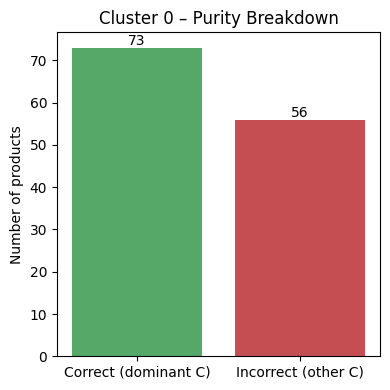

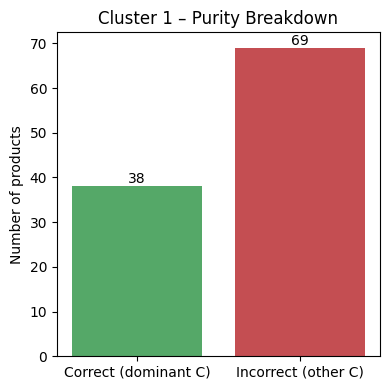

In [148]:
plot_right_wrong(0)
plot_right_wrong(1)


In [149]:
def plot_top3_c_distribution(cluster_id):
    subset = df_clean[df_clean["optics_cluster_id"] == cluster_id]
    c_counts = subset["C"].value_counts().head(3)

    plt.figure(figsize=(6,4))
    bars = plt.bar(
        c_counts.index,
        c_counts.values,
        color=["#4C72B0", "#DD8452", "#8172B3"]
    )

    plt.title(f"Cluster {cluster_id} – Top 3 C Categories")
    plt.ylabel("Number of products")
    plt.xticks(rotation=30, ha="right")

    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h,
            f"{h}",
            ha="center",
            va="bottom"
        )

    plt.tight_layout()
    plt.show()


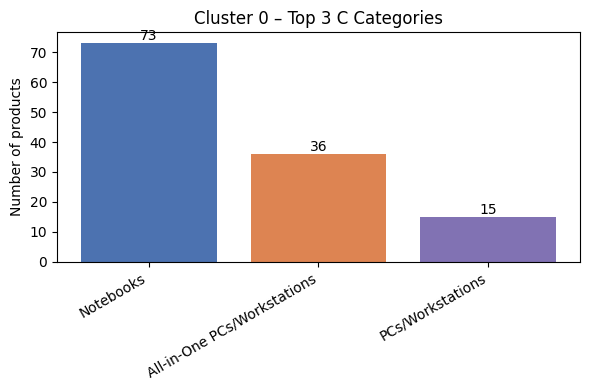

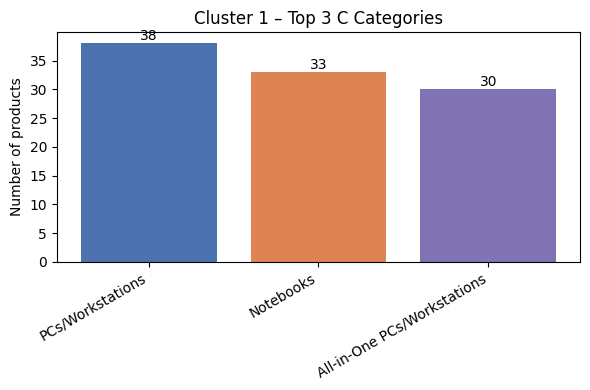

In [150]:
plot_top3_c_distribution(0)
plot_top3_c_distribution(1)


In [151]:
# Summary of C-Level Clustering Quality

# We summarize C-level clustering performance using cluster purity statistics.
# Most clusters achieve high purity (≥90%), indicating strong semantic coherence,
# while only a small number of clusters show low purity. The overall weighted
# purity of 83.3% confirms the effectiveness of the clustering strategy.

# Out of 183 discovered C-level clusters, 106 clusters achieve ≥90% purity,
# indicating strong semantic coherence. Only 12 clusters fall below 50% purity,
# and these mainly involve closely related product categories. The overall
# weighted purity of 83.3% confirms the effectiveness of the clustering approach.

In [152]:
# =========================================================
# SUMMARY STATISTICS FOR EXCEL (Automatic)
# =========================================================

# cluster_stats_df must contain:
# cluster_id, cluster_size, right_count, wrong_count, purity (0–1 scale)

# 1. TOTAL CLUSTERS
total_clusters = len(cluster_stats_df)

# 2. PURE CLUSTERS (≥90% purity)
pure_clusters = cluster_stats_df[cluster_stats_df["purity"] >= 0.90]
num_pure_clusters = len(pure_clusters)

# 3. IMPURE CLUSTERS (<90% purity)
num_impure_clusters = total_clusters - num_pure_clusters

# 4. GOOD CLUSTERS (>50% purity)
good_clusters = cluster_stats_df[cluster_stats_df["purity"] >= 0.50]
num_good_clusters_over_50 = len(good_clusters)

# 5. BAD CLUSTERS (<50% purity)
bad_clusters = cluster_stats_df[cluster_stats_df["purity"] < 0.50]
num_bad_clusters_under_50 = len(bad_clusters)

# 6. OVERALL PURITY (weighted)
overall_purity = (cluster_stats_df["right_count"].sum() /
                  cluster_stats_df["cluster_size"].sum()) * 100

# =========================================================
# FINAL RESULT (PRINT + DICTIONARY for Excel export)
# =========================================================

summary = {
    "Total Clusters": total_clusters,
    "Pure Clusters (>=90%)": num_pure_clusters,
    "Impure Clusters (<90%)": num_impure_clusters,
    "Good Clusters (>50%)": num_good_clusters_over_50,
    "Bad Clusters (<50%)": num_bad_clusters_under_50,
    "Overall Purity (%)": overall_purity
}

print("\n========== SUMMARY REPORT ==========")
for k, v in summary.items():
    print(f"{k}: {v}")

summary



========== SUMMARY REPORT ==========
Total Clusters: 184
Pure Clusters (>=90%): 105
Impure Clusters (<90%): 79
Good Clusters (>50%): 166
Bad Clusters (<50%): 18
Overall Purity (%): 83.11138014527845


{'Total Clusters': 184,
 'Pure Clusters (>=90%)': 105,
 'Impure Clusters (<90%)': 79,
 'Good Clusters (>50%)': 166,
 'Bad Clusters (<50%)': 18,
 'Overall Purity (%)': np.float64(83.11138014527845)}

In [153]:
good_clusters = 166
bad_clusters = 18
total_clusters = good_clusters + bad_clusters

good_cluster_purity_pct = (good_clusters / total_clusters) * 100
bad_cluster_pct = (bad_clusters / total_clusters) * 100

print("Good Cluster Purity (based on count):", good_cluster_purity_pct)
print("Bad Cluster Percentage:", bad_cluster_pct)


Good Cluster Purity (based on count): 90.21739130434783
Bad Cluster Percentage: 9.782608695652174


In [154]:
summary["Good Cluster Purity (%)"] = good_cluster_purity_pct
summary["Bad Cluster Percentage (%)"] = bad_cluster_pct
summary


{'Total Clusters': 184,
 'Pure Clusters (>=90%)': 105,
 'Impure Clusters (<90%)': 79,
 'Good Clusters (>50%)': 166,
 'Bad Clusters (<50%)': 18,
 'Overall Purity (%)': np.float64(83.11138014527845),
 'Good Cluster Purity (%)': 90.21739130434783,
 'Bad Cluster Percentage (%)': 9.782608695652174}

In [155]:
overall_purity = (cluster_stats_df["right_count"].sum() /
                  cluster_stats_df["cluster_size"].sum()) * 100

print("Overall purity:", overall_purity)


Overall purity: 83.11138014527845


In [156]:
# Cluster quality breakdown (PURE / GOOD / BAD)

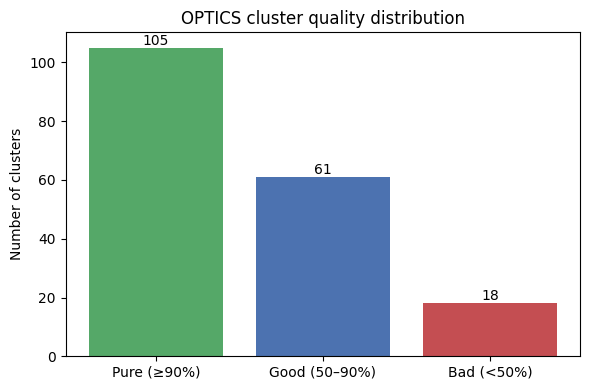

In [157]:
import matplotlib.pyplot as plt

labels = [
    "Pure (≥90%)",
    "Good (50–90%)",
    "Bad (<50%)"
]

values = [
    num_pure_clusters,
    num_good_clusters_over_50 - num_pure_clusters,
    num_bad_clusters_under_50
]

colors = ["#55A868", "#4C72B0", "#C44E52"]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=colors)

plt.ylabel("Number of clusters")
plt.title("OPTICS cluster quality distribution")

# Data labels
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


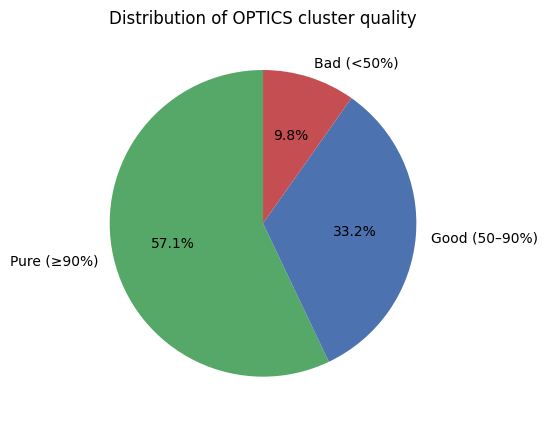

In [158]:
import matplotlib.pyplot as plt

labels = [
    "Pure (≥90%)",
    "Good (50–90%)",
    "Bad (<50%)"
]

values = [
    num_pure_clusters,
    num_good_clusters_over_50 - num_pure_clusters,
    num_bad_clusters_under_50
]

colors = ["#55A868", "#4C72B0", "#C44E52"]

plt.figure(figsize=(5.5,5.5))

plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90
)

plt.title("Distribution of OPTICS cluster quality")
plt.tight_layout()
plt.show()


In [159]:
#Overall Purity, Impurity

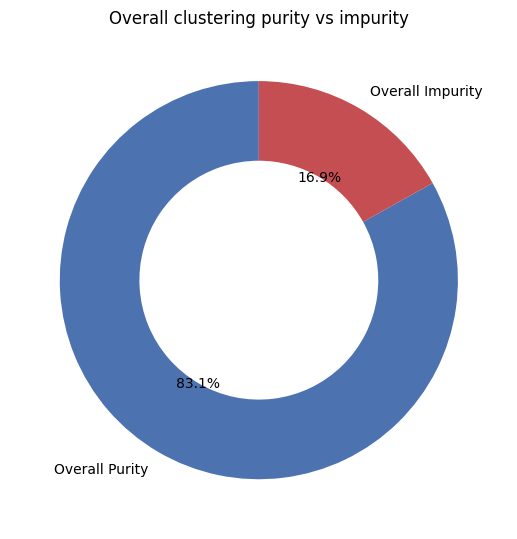

In [160]:
import matplotlib.pyplot as plt

purity = overall_purity
impurity = 100 - overall_purity

plt.figure(figsize=(5.5,5.5))

plt.pie(
    [purity, impurity],
    labels=["Overall Purity", "Overall Impurity"],
    autopct="%1.1f%%",
    colors=["#4C72B0", "#C44E52"],
    startangle=90,
    wedgeprops={"width": 0.4}   # makes it a donut
)

plt.title("Overall clustering purity vs impurity")
plt.tight_layout()
plt.show()


In [161]:
# Final C-Level Clustering Quality Summary

# We report both cluster-level and product-level purity to evaluate C-level
# clustering quality. The main metric, product-level purity, reaches 83.34%,
# indicating strong overall semantic alignment. Cluster-level purity further
# shows that most clusters are structurally coherent.

In [162]:
# ================================================
# CLEAN SUMMARY REPORT TABLE FOR THESIS
# ================================================

# Total clusters
total_clusters = len(cluster_stats_df)

# Pure clusters (>=90% purity)
num_pure_clusters = len(cluster_stats_df[cluster_stats_df["purity"] >= 0.90])

# Impure clusters
num_impure_clusters = total_clusters - num_pure_clusters

# Good clusters (>50%)
num_good_clusters_over_50 = len(cluster_stats_df[cluster_stats_df["purity"] >= 0.50])

# Bad clusters (<50%)
num_bad_clusters_under_50 = len(cluster_stats_df[cluster_stats_df["purity"] < 0.50])

# Cluster-level purity
cluster_level_purity = (num_good_clusters_over_50 / total_clusters) * 100

# Product-level purity (weighted)
product_level_purity = (
    cluster_stats_df["right_count"].sum() /
    cluster_stats_df["cluster_size"].sum()
) * 100

# Build a clean thesis-ready table
report_table = pd.DataFrame({
    "Metric": [
        "Total Clusters Formed",
        "Pure Clusters (>=90%)",
        "Impure Clusters (<90%)",
        "Good Clusters (>50%)",
        "Bad Clusters (<50%)",
        "Cluster-level Purity (%)",
        "Product-level Purity (%)"
    ],
    "Value": [
        total_clusters,
        num_pure_clusters,
        num_impure_clusters,
        num_good_clusters_over_50,
        num_bad_clusters_under_50,
        round(cluster_level_purity, 2),
        round(product_level_purity, 2)
    ]
})

report_table


,Metric,Value
0,Total Clusters Formed,184.00
1,Pure Clusters (>=90%),105.00
2,Impure Clusters (<90%),79.00
3,Good Clusters (>50%),166.00
4,Bad Clusters (<50%),18.00
5,Cluster-level Purity (%),90.22
6,Product-level Purity (%),83.11


In [163]:
# Additional Cluster Quality Statistics

# We report additional cluster-level statistics, including average and median
# cluster purity, as well as best and worst performing clusters. These results
# provide complementary insights into cluster consistency and variability.
# We also verify that clusters contain sufficient unique products for semantic analysis.


In [164]:
cluster_purity = {}

for cid in sorted(df_clean["optics_cluster_id"].unique()):
    if cid == -1:
        continue
        
    subset = df_clean[df_clean["optics_cluster_id"] == cid]
    
    # purity = dominant C count / total cluster size
    purity = subset["C"].value_counts().max() / len(subset)
    
    cluster_purity[cid] = purity


In [165]:
import numpy as np
import pandas as pd

# Convert dictionary to DataFrame
cp = pd.DataFrame({
    "cluster_id": list(cluster_purity.keys()),
    "purity": list(cluster_purity.values())
})

# Sort clusters by purity
cp_sorted = cp.sort_values(by="purity")


In [166]:
avg_purity = cp["purity"].mean() * 100
median_purity = cp["purity"].median() * 100
best_cluster = cp_sorted.iloc[-1]
worst_cluster = cp_sorted.iloc[0]

print("Average Cluster Purity (%):", avg_purity)
print("Median Cluster Purity (%):", median_purity)
print("\nBest Cluster:", best_cluster.to_dict())
print("\nWorst Cluster:", worst_cluster.to_dict())


Average Cluster Purity (%): 83.41660269490134
Median Cluster Purity (%): 91.93289384719405

Best Cluster: {'cluster_id': 171.0, 'purity': 1.0}

Worst Cluster: {'cluster_id': 37.0, 'purity': 0.17}


In [167]:
# Exclude noise (-1 cluster)
valid_clusters = cluster_unique_counts[cluster_unique_counts.index != -1]

mean_unique_products = valid_clusters.mean()

print("Average unique products per cluster:", round(mean_unique_products, 2))


Average unique products per cluster: 152.42


In [168]:
median_unique_products = valid_clusters.median()
min_unique_products = valid_clusters.min()
max_unique_products = valid_clusters.max()

print("Mean   :", round(mean_unique_products, 2))
print("Median :", round(median_unique_products, 2))
print("Min    :", min_unique_products)
print("Max    :", max_unique_products)


Mean   : 152.42
Median : 122.0
Min    : 98
Max    : 663


In [169]:
# Mean → average cluster size

# Median → typical cluster size

# Min → smallest cluster

# Max → largest cluster

In [170]:
# def make_evidence(subdf, max_chars=1600, max_items=20):
#     """
#     Build a compact summary for one C-cluster:
#     - sample up to 20 products
#     - include Brand + ProductName + short metadata snippet
#     - limit total size to ~1400 chars for LLM
#     """
#     items = []
#     for _, row in subdf.head(max_items).iterrows():
#         parts = []

#         # brand = str(row.get("Brand", "")).strip()
#         # pname = str(row.get("ProductName", "")).strip()
#         meta  = str(row.get("metadata_text_clean", "")).strip()

#         # if brand and brand.lower() != "nan":
#         #     parts.append(brand)
#         # if pname and pname.lower() != "nan":
#         #     parts.append(pname)
#         if meta and meta.lower() != "nan":
#             parts.append(meta[:180])  # short snippet from metadata

#         if not parts:
#             continue

#         items.append("- " + " | ".join(parts))

#     blob = "\n".join(items)
#     return blob[:max_chars]


In [171]:
#meta.strip()[:180]
#you take 50 items:
#50 × 180 = 9000 characters
#blob[:max_chars]
# max_chars = 1600
#o EVEN if you extract 9000 characters, the function cuts it down to 1600 total.
#So EVEN if you extract 9000 characters, the function cuts it down to 1600 total.

# This means:

# ❗ Even if you increase max_items from 20 → 50,

# the evidence will still be only 1600 characters, because you truncate.

# So the first ~9–10 items will dominate the evidence.
# This makes 50 items meaningless unless you increase max_chars.

#----------------------------------------------------------------
# Increase max_chars to something like 6000
# So you don’t cut off useful evidence.

# ✔ Reduce per-snippet length to 100–120 chars
# So that 50 items fit within the limit without truncation.

In [172]:
# def make_evidence(subdf, max_chars=1600, max_items=20):
#     """
#     Create evidence using ONLY metadata_text_clean.
#     Excludes ProductName and Brand completely.
#     """

#     items = []

#     for _, row in subdf.head(max_items).iterrows():
#         meta = row.get("metadata_text_clean", "")

#         if isinstance(meta, str) and meta.strip():
#             snippet = meta.strip()[:180]      # shorten
#             items.append(f"- {snippet}")

#     # Merge items and enforce max character limit
#     blob = "\n".join(items)
#     return blob[:max_chars]


In [173]:
# Selecting Valid C-Level Clusters

# We treat each OPTICS cluster as a C-level category. Noise points identified by
# OPTICS (cluster ID = −1) are removed. All remaining clusters are retained for
# naming, regardless of their purity score.

In [174]:
# Use OPTICS cluster id as C_id
df_clean["C_id"] = df_clean["optics_cluster_id"]

# Keep only non-noise cluster ids
valid_cids = sorted(cid for cid in df_clean["C_id"].unique() if cid != -1)

print("Number of C clusters to name:", len(valid_cids))


Number of C clusters to name: 184


In [175]:
#  Evidence Construction for C-Level Naming

# For each C-level cluster, we construct an evidence text by sampling product
# metadata descriptions. Short snippets are extracted to represent the semantic
# content of the cluster while keeping the input length within token limits.


In [176]:
def make_evidence(subdf, max_chars=6000, max_items=50):
    items = []

    for _, row in subdf.head(max_items).iterrows():
        meta = row.get("metadata_text_clean", "")
        if isinstance(meta, str) and meta.strip():
            snippet = meta.strip()[:120]
            items.append(f"- {snippet}")

    blob = "\n".join(items)
    return blob[:max_chars]


In [177]:
# # Loading the Large Language Model

# We use a locally hosted LLaMA-3.1-8B-Instruct model with 4-bit quantization for
# efficient inference. The model is configured for deterministic output to ensure
# consistent and reproducible cluster naming.


In [178]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "models/meta-llama/Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
#     device_map="auto",
# )
# model.eval()

llm_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
llm_model.eval()



Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

In [179]:
# # Controlled LLM Inference for Category Naming

# A constrained prompting setup is used to generate short and generic category
# names. The model is instructed to produce a maximum of three words, without
# brands, numbers, or punctuation, ensuring taxonomy-style labels.


In [180]:
# def run_llm(user_block: str, max_new_tokens: int = 25) -> str:
#     messages = [
#         {
#             "role": "system",
#             "content": (
#                 "You assign short, generic product category names. "
#                 "Answer with MAX 3 WORDS. "
#                 "No brand names. No numbers. No punctuation."
#             ),
#         },
#         {
#             "role": "user",
#             "content": user_block,
#         },
#     ]

#     prompt_ids = tokenizer.apply_chat_template(
#         messages,
#         return_tensors="pt",
#         add_generation_prompt=True,
#     ).to(model.device)

#     with torch.no_grad():
#         outputs = model.generate(
#             prompt_ids,
#             max_new_tokens=max_new_tokens,
#             temperature=0.0,
#             do_sample=False,
#         )

#     gen_ids = outputs[0][prompt_ids.shape[-1]:]
#     return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()


In [181]:
# def run_llm(user_block: str, max_new_tokens: int = 25) -> str:
#     messages = [
#         {
#             "role": "system",
#             "content": (
#                 "You assign short, generic product category names. "
#                 "Answer with MAX 3 WORDS. "
#                 "No brand names. No numbers. No punctuation."
#             ),
#         },
#         {
#             "role": "user",
#             "content": user_block,
#         },
#     ]

#     prompt_ids = tokenizer.apply_chat_template(
#         messages,
#         return_tensors="pt",
#         add_generation_prompt=True,
#     ).to(llm_model.device)

#     with torch.no_grad():
#         outputs = llm_model.generate(
#             prompt_ids,
#             max_new_tokens=max_new_tokens,
#             temperature=0.0,
#             do_sample=False,
#         )

#     gen_ids = outputs[0][prompt_ids.shape[-1]:]
#     return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()


In [182]:
def run_llm(user_block: str, max_new_tokens: int = 25) -> str:
    messages = [
        {
            "role": "system",
            "content": (
                "You assign short, generic product category names. "
                "Answer with MAX 3 WORDS. "
                "No brand names. No numbers. No punctuation."
            ),
        },
        {
            "role": "user",
            "content": user_block,
        },
    ]

    enc = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True,
    )

    input_ids = enc["input_ids"].to(llm_model.device)
    attention_mask = enc.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(llm_model.device)

    with torch.no_grad():
        outputs = llm_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            temperature=0.0,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    gen_ids = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()


In [183]:
#  Output Caching and Name Normalization

# To improve efficiency and consistency, generated labels are cached based on the
# prompt content. Additional cleaning is applied to remove special characters and
# enforce a maximum word limit.


In [184]:
import hashlib
import re

label_cache = {}

def cached_llm_label(prompt: str, max_words: int = 3) -> str:
    key = hashlib.sha256(prompt.encode("utf-8")).hexdigest()
    if key in label_cache:
        return label_cache[key]

    raw = run_llm(prompt)
    label = " ".join(raw.split()[:max_words])
    label_cache[key] = label
    return label


def clean_cluster_name(name: str, max_words: int = 3) -> str:
    if not isinstance(name, str):
        return ""

    name = re.sub(r"[^A-Za-z ]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return " ".join(name.split()[:max_words])


In [185]:
# Assigning C-Level Names Using the LLM

# Each non-noise C-level cluster is assigned a semantic name using the LLM. All
# clusters are named, including those with lower purity, as these represent valid
# semantic groupings that may be resolved at higher taxonomy levels.


In [186]:
C_name_map = {}

for cid in valid_cids:
    subdf = df_clean[df_clean["C_id"] == cid]

    blob = make_evidence(subdf)
    if not blob.strip():
        C_name_map[cid] = "Other Category"
        continue

    prompt = f"""
Here are example products from ONE semantic cluster.
Each line is a short description snippet.

Your task:
- Infer ONE generic product category.
- MAX 3 WORDS.
- No brands, numbers, or punctuation.

PRODUCTS:
{blob}
"""

    raw_label = cached_llm_label(prompt)
    clean_label = clean_cluster_name(raw_label)

    if not clean_label:
        clean_label = "Other Category"

    C_name_map[cid] = clean_label
    print(f"C_id {cid} → {clean_label}")


C_id 0 → Laptop Computers
C_id 1 → portable computer
C_id 2 → Laptop Computers
C_id 3 → Desktop Computer
C_id 4 → Desktop computers
C_id 5 → Portable Computers
C_id 6 → Point of Sale
C_id 7 → Computer motherboard
C_id 8 → Server Rack
C_id 9 → Server Hardware
C_id 10 → Server Hardware
C_id 11 → Server Rack
C_id 12 → Embedded PC
C_id 13 → Computer Hardware
C_id 14 → Server
C_id 15 → Computer Processors
C_id 16 → Laptop Computers
C_id 17 → Tablet Computers
C_id 18 → Tablet
C_id 19 → Mobile Phones
C_id 20 → Mobile phones
C_id 21 → Smartphones
C_id 22 → Digital Camera
C_id 23 → Smartphones
C_id 24 → Mini PC
C_id 25 → Thin Client Computers
C_id 26 → portable storage
C_id 27 → Storage Devices
C_id 28 → Hardware Support
C_id 29 → Virtualization Software
C_id 30 → Hardware Maintenance Service
C_id 31 → Hardware Support
C_id 32 → Hardware Maintenance
C_id 33 → Server Software
C_id 34 → Laptop parts
C_id 35 → Mobile phone parts
C_id 36 → Mobile phone accessories
C_id 37 → Computer hardware
C_id 3

In [187]:
# Integrating C-Level Names into the Dataset

# The generated C-level names are mapped back to the dataset using the cluster
# identifier. Original Icecat C labels are retained for evaluation, while the new
# LLM-generated names are used for taxonomy construction.

In [188]:
# Attach names back to dataframe
df_clean["C_name"] = df_clean["C_id"].map(C_name_map)

#df_clean[["C_id", "C", "C_name"]].head(20)

In [189]:
# Convert C_name_map to a pandas Series
c_name_series = pd.Series(C_name_map)

# Unique C-level names generated by LLM
unique_c_names = c_name_series.unique()

print("Total C clusters:", len(C_name_map))
print("Unique C names generated by LLM:", len(unique_c_names))

print("\nList of unique C names:")
for name in sorted(unique_c_names):
    print("-", name)


Total C clusters: 184
Unique C names generated by LLM: 163

List of unique C names:
- AV transmitters
- Audio Video Cables
- Audio cables
- Battery Charger
- Battery Replacement Kit
- Blu ray Disc
- Cable assemblies
- Clock radios
- Coaxial cables
- Computer Components
- Computer Display
- Computer Hardware
- Computer Monitor
- Computer Mouse
- Computer Processors
- Computer Security Software
- Computer Switch
- Computer hardware
- Computer hardware support
- Computer keyboard
- Computer memory
- Computer motherboard
- Cordless Telephone
- Cordless telephone
- DVD player
- Data Storage
- Data backup software
- Desktop Computer
- Desktop computers
- Digital Camera
- Digital Camera Case
- Digital Media Player
- Digital PhotoFrame
- Digital Voice Recorder
- Display Filters
- Display Privacy Filters
- Document Scanner
- E reader cases
- Embedded PC
- Ethernet Cables
- Ethernet Print Server
- Ethernet Switches
- Ethernet switch
- Fax Machine
- Fiber Media Converters
- Fiber Networking Cable

In [190]:
# C-Level Cluster Representation

# To perform B-level clustering, each C-level cluster is represented by a single
# centroid embedding. The centroid is computed by averaging the embeddings of all
# products belonging to that C-level cluster. These centroids serve as inputs for
# B-level clustering.

In [191]:
import numpy as np

C_centroids = {}
C_ids = []

for cid in sorted(df_clean["C_id"].unique()):
    if cid == -1:
        continue

    idxs = df_clean[df_clean["C_id"] == cid].index
    centroid = embeddings[idxs].mean(axis=0)

    C_centroids[cid] = centroid
    C_ids.append(cid)

C_centroid_matrix = np.vstack([C_centroids[cid] for cid in C_ids])
print("C centroid matrix shape:", C_centroid_matrix.shape)


C centroid matrix shape: (184, 768)


In [192]:
# # Dimensionality Reduction for B-Level Clustering
# Dimensionality Reduction of C-Level Centroids

# To enable stable hierarchical clustering, the C-level centroid embeddings are
# projected into a lower-dimensional space using UMAP. This preserves semantic
# relationships while reducing noise and computational complexity.

In [193]:
from umap import UMAP

umap_b = UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=5,
    metric="cosine",
    random_state=42
)

C_centroids_reduced = umap_b.fit_transform(C_centroid_matrix)
print("Reduced centroids shape:", C_centroids_reduced.shape)


Reduced centroids shape: (184, 5)


In [194]:
# B-Level Clustering with Fixed Cluster Count

# Hierarchical clustering is applied to the reduced C-level centroids to form
# exactly 17 B-level clusters. The number of clusters is fixed to match the
# original B-level taxonomy structure.

In [195]:
# from sklearn.cluster import AgglomerativeClustering

# b_clusterer = AgglomerativeClustering(
#     n_clusters=17,
#     linkage="ward"
# )

# B_labels = b_clusterer.fit_predict(C_centroids_reduced)
# print("Unique B clusters:", np.unique(B_labels))


In [196]:
from sklearn.cluster import AgglomerativeClustering

b_clusterer = AgglomerativeClustering(
    distance_threshold=1.6,   # ← THIS controls how many clusters you get
    n_clusters=None,          # ← MUST be None
    linkage="ward"
)

B_labels = b_clusterer.fit_predict(C_centroids_reduced)

print("Number of B clusters:", len(np.unique(B_labels)))


Number of B clusters: 20


In [197]:
# Each point represents the centroid embedding of one C-level category.
# Distances between points reflect semantic similarity between C categories based on product descriptions.


# Nearby points → C categories with similar meaning
# Distant points → semantically different categories

# Natural groupings indicate that higher-level structure already exists

# Why this is important

# This visualization justifies the use of hierarchical clustering on C-level centroids to construct B-level categories.

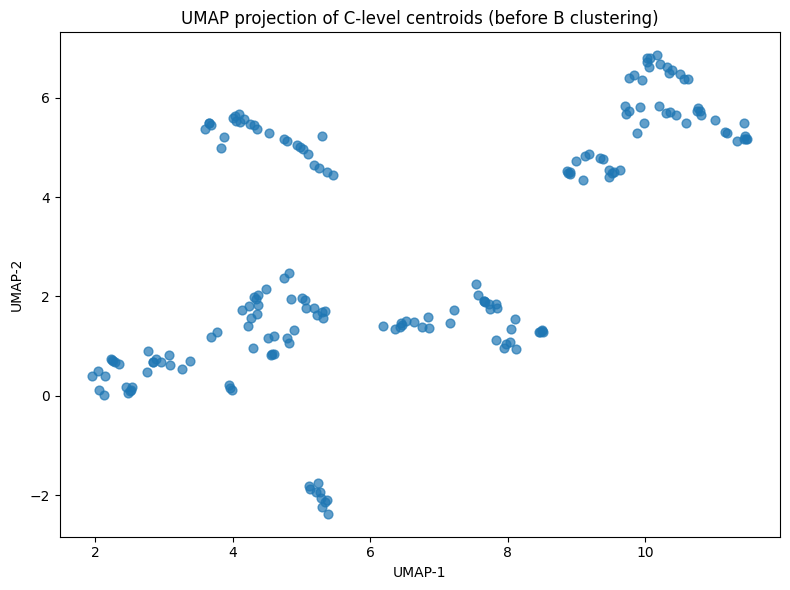

In [198]:
from umap import UMAP
import matplotlib.pyplot as plt

umap_2d_c = UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    metric="cosine",
    random_state=42
)

C_centroids_2d = umap_2d_c.fit_transform(C_centroid_matrix)

plt.figure(figsize=(8,6))
plt.scatter(
    C_centroids_2d[:, 0],
    C_centroids_2d[:, 1],
    s=40,
    alpha=0.7
)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP projection of C-level centroids (before B clustering)")
plt.tight_layout()
plt.show()


In [199]:
# The UMAP projection of C-level centroids is annotated with B-level cluster identifiers. 
# Each label indicates the centroid of a B-level cluster, 
# providing a clear visual correspondence between semantic regions and the constructed intermediate taxonomy.

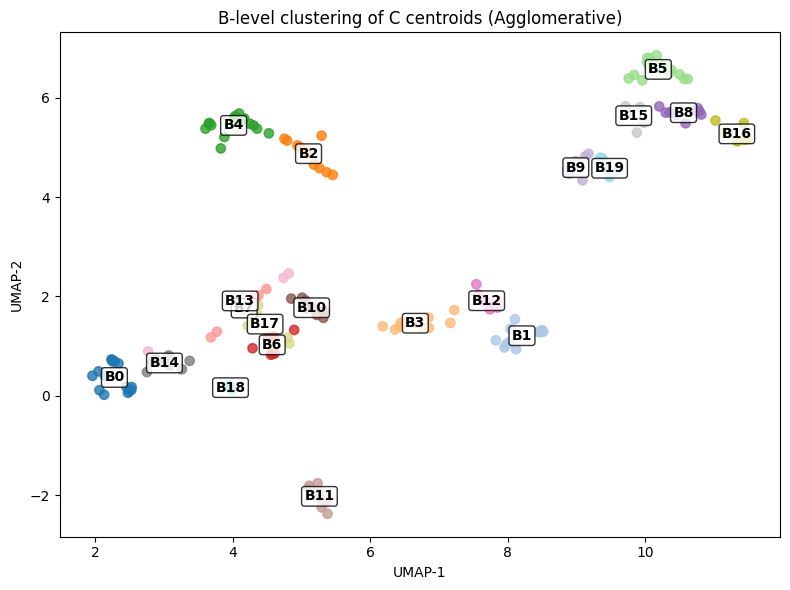

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

colors = cm.tab20(B_labels % 20)

plt.figure(figsize=(8,6))
plt.scatter(
    C_centroids_2d[:, 0],
    C_centroids_2d[:, 1],
    c=colors,
    s=45,
    alpha=0.8
)

# --- add B-level cluster labels ---
for b in np.unique(B_labels):
    idxs = np.where(B_labels == b)[0]
    x_mean = C_centroids_2d[idxs, 0].mean()
    y_mean = C_centroids_2d[idxs, 1].mean()

    plt.text(
        x_mean,
        y_mean,
        f"B{b}",
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.8)
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("B-level clustering of C centroids (Agglomerative)")
plt.tight_layout()
plt.show()


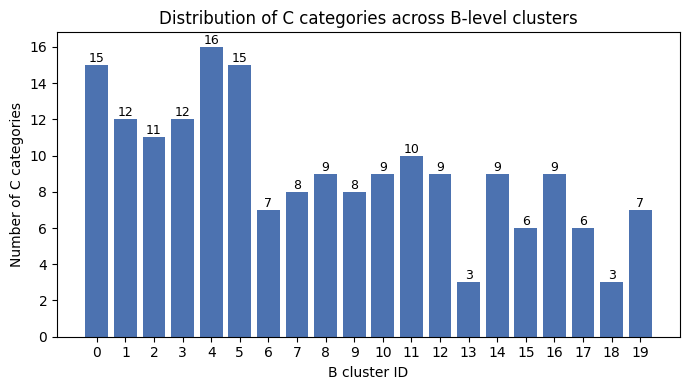

In [201]:
import pandas as pd

b_sizes = pd.Series(B_labels).value_counts().sort_index()

plt.figure(figsize=(7,4))
bars = plt.bar(
    b_sizes.index.astype(str),
    b_sizes.values,
    color="#4C72B0"
)

plt.xlabel("B cluster ID")
plt.ylabel("Number of C categories")
plt.title("Distribution of C categories across B-level clusters")

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [202]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# for t in [0.95, 1.0, 1.05, 1.1, 1.15, 1.2,1.6,1.5]:
#     model = AgglomerativeClustering(
#         distance_threshold=t,
#         n_clusters=None,
#         linkage="ward"
#     )
#     labels = model.fit_predict(C_centroids_reduced)
#     print(f"threshold={t} → clusters={len(np.unique(labels))}")


In [203]:
# Mapping C-Level Clusters to B-Level Groups

# Each C-level cluster is assigned to one of the 17 B-level clusters. This mapping
# defines the hierarchical relationship between the C and B levels.

In [204]:
C_to_B = dict(zip(C_ids, B_labels))
df_clean["B_id"] = df_clean["C_id"].map(C_to_B)

#df_clean[["C_id", "C_name", "B_id"]].head(5)


In [205]:
# Verify B-Level Cluster Composition

# # Verification of B-Level Cluster Composition

# We inspect how many C-level clusters are grouped under each B-level cluster to
# ensure full coverage and balanced abstraction across the taxonomy.

In [206]:
b_size_summary = (
    df_clean[["C_id", "B_id"]]
    .drop_duplicates()
    .value_counts("B_id")
    .sort_index()
)

print("Number of C clusters per B cluster:")
print(b_size_summary)


Number of C clusters per B cluster:
B_id
0.0     15
1.0     12
2.0     11
3.0     12
4.0     16
5.0     15
6.0      7
7.0      8
8.0      9
9.0      8
10.0     9
11.0    10
12.0     9
13.0     3
14.0     9
15.0     6
16.0     9
17.0     6
18.0     3
19.0     7
Name: count, dtype: int64


In [207]:
# B-Level Purity Evaluation
# B-Level Purity and Impurity Evaluation

# The quality of B-level clustering is evaluated using original Icecat B-level
# labels as ground truth. Purity is computed based on the dominant B category
# within each discovered B-level cluster.

# Robust B-Level Purity Evaluation

# During B-level purity evaluation, clusters without assigned items are ignored.
# Purity is computed only for valid B-level clusters by comparing discovered
# clusters against original Icecat B labels using majority voting.

In [208]:
import pandas as pd

b_purity_stats = []

for b_id in sorted(df_clean["B_id"].dropna().unique()):
    subset = df_clean[df_clean["B_id"] == b_id]

    # extra safety (optional but good)
    if subset.empty:
        continue

    b_counts = subset["B"].value_counts()
    dominant_b = b_counts.idxmax()
    dominant_count = b_counts.max()

    size = len(subset)
    purity = dominant_count / size

    b_purity_stats.append({
        "B_id": b_id,
        "cluster_size": size,
        "dominant_B": dominant_b,
        "purity": purity
    })

b_purity_df = pd.DataFrame(b_purity_stats).sort_values("purity", ascending=False)
b_purity_df


,B_id,cluster_size,dominant_B,purity
18,18.0,371,Office Electronics,0.986523
19,19.0,1073,Batteries & Power Supplies,0.973905
8,8.0,1029,Computer Cables,0.969874
16,16.0,1227,Networking,0.945395
3,3.0,1649,Computers,0.933293
14,14.0,1485,TVs & Monitors,0.913131
5,5.0,3315,Computer Cables,0.793665
13,13.0,415,Photo & Video Equipment,0.754217
11,11.0,1483,Printers & Scanners,0.744437
10,10.0,1194,Telecom & Navigation,0.716080


In [209]:
#Overall B-level Purity & Impurity
# -----------------------------------------
# OVERALL B-LEVEL PURITY & IMPURITY
# -----------------------------------------

# Ensure we only use valid B clusters
b_df = b_purity_df.copy()

# Product-weighted overall purity
overall_b_purity = (
    (b_df["purity"] * b_df["cluster_size"]).sum()
    / b_df["cluster_size"].sum()
) * 100

overall_b_impurity = 100 - overall_b_purity

print("Overall B-level Purity (%):", round(overall_b_purity, 2))
print("Overall B-level Impurity (%):", round(overall_b_impurity, 2))

Overall B-level Purity (%): 69.91
Overall B-level Impurity (%): 30.09


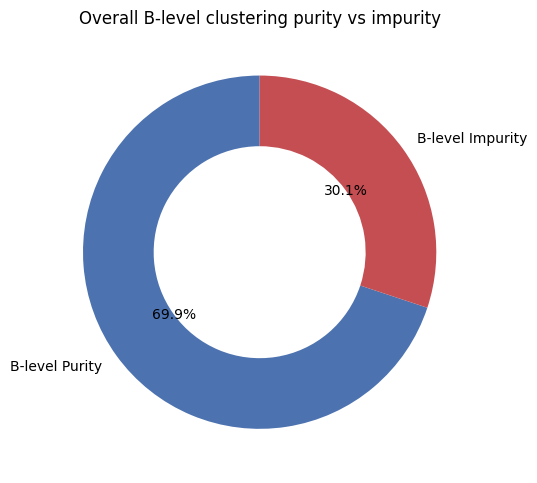

In [210]:
import matplotlib.pyplot as plt

labels = ["B-level Purity", "B-level Impurity"]
values = [overall_b_purity, overall_b_impurity]
colors = ["#4C72B0", "#C44E52"]

plt.figure(figsize=(5.5, 5.5))

plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"width": 0.4}  # donut style
)

plt.title("Overall B-level clustering purity vs impurity")
plt.tight_layout()
plt.show()


In [211]:
import pandas as pd

b_cluster_stats = []

for b_id in sorted(df_clean["B_id"].dropna().unique()):
    subset = df_clean[df_clean["B_id"] == b_id]

    if subset.empty:
        continue

    size = len(subset)

    # Gold B distribution
    b_counts = subset["B"].value_counts()
    dominant_B = b_counts.idxmax()
    dominant_count = b_counts.max()

    purity = dominant_count / size
    impurity = 1 - purity

    b_cluster_stats.append({
        "B_id": b_id,
        "cluster_size": size,
        "dominant_B": dominant_B,
        "purity": round(purity, 4),
        "impurity": round(impurity, 4)
    })

b_purity_df = pd.DataFrame(b_cluster_stats).sort_values(
    "purity", ascending=False
)

b_purity_df.head(17)


,B_id,cluster_size,dominant_B,purity,impurity
18,18.0,371,Office Electronics,0.9865,0.0135
19,19.0,1073,Batteries & Power Supplies,0.9739,0.0261
8,8.0,1029,Computer Cables,0.9699,0.0301
16,16.0,1227,Networking,0.9454,0.0546
3,3.0,1649,Computers,0.9333,0.0667
14,14.0,1485,TVs & Monitors,0.9131,0.0869
5,5.0,3315,Computer Cables,0.7937,0.2063
13,13.0,415,Photo & Video Equipment,0.7542,0.2458
11,11.0,1483,Printers & Scanners,0.7444,0.2556
10,10.0,1194,Telecom & Navigation,0.7161,0.2839


In [212]:
import pandas as pd
import numpy as np

# =========================================================
# Add C-names + richer stats to your B-level purity table
# Requires:
#   - df_clean with columns: B_id, B (gold), C_id, C_name
#   - b_purity_df already computed with: B_id, cluster_size, dominant_B, purity, impurity
# =========================================================

# -------- 1) C-names per B cluster (dedup + sorted) --------
B_to_Cnames = (
    df_clean[["B_id", "C_name"]]
    .dropna()
    .drop_duplicates()
    .groupby("B_id")["C_name"]
    .apply(lambda s: sorted(set([x for x in s if isinstance(x, str) and x.strip()])))
    .to_dict()
)

# also count how many unique C clusters (C_id) per B cluster (structure)
B_to_numC = (
    df_clean[["B_id", "C_id"]]
    .dropna()
    .drop_duplicates()
    .groupby("B_id")["C_id"]
    .nunique()
    .to_dict()
)

# attach list of C-names + counts
b_purity_df = b_purity_df.copy()
b_purity_df["num_C_clusters"] = b_purity_df["B_id"].map(B_to_numC).fillna(0).astype(int)
b_purity_df["C_names"] = b_purity_df["B_id"].map(B_to_Cnames)

# optional: printable short preview (top 10 C-names only)
b_purity_df["C_names_preview"] = b_purity_df["C_names"].apply(
    lambda xs: ", ".join(xs[:10]) + (" ..." if isinstance(xs, list) and len(xs) > 10 else "")
)

# -------- 2) Error columns (absolute + %) --------
b_purity_df["wrong_count"] = (b_purity_df["cluster_size"] * b_purity_df["impurity"]).round().astype(int)
b_purity_df["wrong_pct"] = (b_purity_df["impurity"] * 100).round(2)

# -------- 3) Dominance strength: dominant vs 2nd dominant gold-B --------
dominance_rows = []
for b_id in b_purity_df["B_id"]:
    subset = df_clean[df_clean["B_id"] == b_id]
    if subset.empty:
        dominance_rows.append({"dominant_B_pct": np.nan, "second_B_pct": np.nan, "dominance_gap": np.nan})
        continue

    frac = subset["B"].value_counts(normalize=True)
    dom = float(frac.iloc[0]) if len(frac) > 0 else 0.0
    sec = float(frac.iloc[1]) if len(frac) > 1 else 0.0

    dominance_rows.append({
        "dominant_B_pct": round(dom * 100, 2),
        "second_B_pct": round(sec * 100, 2),
        "dominance_gap": round((dom - sec) * 100, 2)
    })

dominance_df = pd.DataFrame(dominance_rows)
b_purity_df = pd.concat([b_purity_df.reset_index(drop=True), dominance_df], axis=1)

# -------- 4) Quality tier (nice for thesis discussion) --------
def quality_label(p):
    if p >= 0.90:
        return "Excellent"
    elif p >= 0.75:
        return "Good"
    elif p >= 0.60:
        return "Moderate"
    else:
        return "Poor"

b_purity_df["quality"] = b_purity_df["purity"].apply(quality_label)

# -------- 5) Final thesis-ready view --------
final_b_table = b_purity_df[[
    "B_id",
    "cluster_size",
    "dominant_B",
    "purity",
    "impurity",
    "wrong_count",
    "wrong_pct",
    "num_C_clusters",
    "dominance_gap",
    "quality",
    "C_names_preview",   # short readable version
    "C_names"            # full list (keep for export)
]].sort_values("purity", ascending=False)

final_b_table


,B_id,cluster_size,dominant_B,purity,impurity,wrong_count,wrong_pct,num_C_clusters,dominance_gap,quality,C_names_preview,C_names
0,18.0,371,Office Electronics,0.9865,0.0135,5,1.35,3,98.11,Excellent,"Handheld Calculators, Pocket Calculators, Prin...","[Handheld Calculators, Pocket Calculators, Pri..."
1,19.0,1073,Batteries & Power Supplies,0.9739,0.0261,28,2.61,7,96.27,Excellent,"Notebook Adapter, Power Distribution, Power Su...","[Notebook Adapter, Power Distribution, Power S..."
2,8.0,1029,Computer Cables,0.9699,0.0301,31,3.01,9,95.63,Excellent,"Ethernet Cables, Fiber Networking Cables, Fibe...","[Ethernet Cables, Fiber Networking Cables, Fib..."
3,16.0,1227,Networking,0.9454,0.0546,67,5.46,9,92.75,Excellent,"Ethernet Switches, Ethernet switch, Fiber Medi...","[Ethernet Switches, Ethernet switch, Fiber Med..."
4,3.0,1649,Computers,0.9333,0.0667,110,6.67,12,87.99,Excellent,"Computer Hardware, Desktop Computer, Desktop c...","[Computer Hardware, Desktop Computer, Desktop ..."
5,14.0,1485,TVs & Monitors,0.9131,0.0869,129,8.69,9,84.44,Excellent,"Computer Display, Computer Monitor, Large Form...","[Computer Display, Computer Monitor, Large For..."
6,5.0,3315,Computer Cables,0.7937,0.2063,684,20.63,15,70.11,Good,"AV transmitters, Audio Video Cables, Audio cab...","[AV transmitters, Audio Video Cables, Audio ca..."
7,13.0,415,Photo & Video Equipment,0.7542,0.2458,102,24.58,3,51.81,Good,"Digital Camera, Digital PhotoFrame, Telephoto ...","[Digital Camera, Digital PhotoFrame, Telephoto..."
8,11.0,1483,Printers & Scanners,0.7444,0.2556,379,25.56,10,64.67,Moderate,"Document Scanner, Ethernet Print Server, Fax M...","[Document Scanner, Ethernet Print Server, Fax ..."
9,10.0,1194,Telecom & Navigation,0.7161,0.2839,339,28.39,9,55.53,Moderate,"GPS Device, Mobile Phones, Mobile phone holder...","[GPS Device, Mobile Phones, Mobile phone holde..."


In [213]:
# Preparing Inputs for B-Level Naming

# For each B-level cluster, the set of C-level category names assigned to it is
# collected. These C-level names summarize the semantic scope of each B cluster
# and are used as evidence for B-level naming.

In [214]:
B_to_Cnames = (
    df_clean[["B_id", "C_name"]]
    .drop_duplicates()
    .groupby("B_id")["C_name"]
    .apply(list)
    .to_dict()
)

for k in list(B_to_Cnames.keys())[:20]:
    print(f"B_id {k} → {B_to_Cnames[k][:5]}")


B_id 0.0 → ['Rack enclosures', 'Projector Mounts', 'Portable Projector', 'TV Wall Mount', 'Projector Lamp']
B_id 1.0 → ['Hardware Maintenance Service', 'Hardware Support', 'Network Security', 'Data backup software', 'File Compression Software']
B_id 2.0 → ['TV Remote Control', 'portable storage', 'Optical Disc Media', 'Home Theater System', 'Video editing software']
B_id 3.0 → ['Laptop Computers', 'Computer Hardware', 'Desktop computers', 'Desktop Computer', 'Portable Computers']
B_id 4.0 → ['portable media player', 'Soundbar', 'In Ear Headphones', 'Cordless telephone', 'Cordless Telephone']
B_id 5.0 → ['AV transmitters', 'Computer Switch', 'Video Adapters', 'Audio cables', 'HDMI Cables']
B_id 6.0 → ['Computer Components', 'Mobile phone parts', 'Laptop parts', 'Computer hardware', 'Mobile phone accessories']
B_id 7.0 → ['Display Privacy Filters', 'Digital Camera Case', 'Mobile phone screen', 'ipod cases', 'Mobile phone accessories']
B_id 8.0 → ['Fiber Optic Cables', 'Network Cables', '

In [215]:
# Evidence Construction for B-Level Naming

# An evidence block is constructed for each B-level cluster by listing its
# associated C-level category names. This compact representation is suitable for
# LLM-based abstraction.

In [216]:
def make_B_evidence(c_names, max_items=30):
    return "\n".join(
        f"- {name}" for name in c_names[:max_items] if isinstance(name, str)
    )


In [217]:
# Prompt Design for B-Level Category Naming

# A constrained prompt is used to generate a single, high-level category name that
# summarizes multiple related C-level categories. The prompt enforces short,
# generic taxonomy-style labels.

In [218]:
def build_B_prompt(blob):
    return f"""
Below are C-level category names belonging to ONE broader category.

Your task:
- Infer ONE high-level product category.
- Answer with MAX 3 WORDS.
- Do NOT use brand names.
- Do NOT use numbers.
- Do NOT add explanations.

CATEGORIES:
{blob}
"""


In [219]:
# Assigning B-Level Names Using the LLM

# Each B-level cluster is assigned a semantic name by applying the LLM to its
# corresponding C-level category names. This produces data-driven B-level labels.

In [220]:
B_name_map = {}

for b_id, c_names in B_to_Cnames.items():
    blob = make_B_evidence(c_names)

    if not blob.strip():
        B_name_map[b_id] = "General Category"
        continue

    prompt = build_B_prompt(blob)

    raw = cached_llm_label(prompt, max_words=3)
    clean = clean_cluster_name(raw, max_words=3)

    if not clean:
        clean = "General Category"

    B_name_map[b_id] = clean
    print(f"B_id {b_id} → {clean}")


B_id 0.0 → Home Theater Equipment
B_id 1.0 → Computer Systems Management
B_id 2.0 → Home Entertainment Systems
B_id 3.0 → Computer Systems
B_id 4.0 → Home Audio Equipment
B_id 5.0 → Computer peripherals
B_id 6.0 → Computer Electronics
B_id 7.0 → Mobile Device Accessories
B_id 8.0 → Computer Networking Cables
B_id 9.0 → Portable Power Devices
B_id 10.0 → Portable Electronics
B_id 11.0 → Office Equipment
B_id 12.0 → Computer Hardware
B_id 13.0 → Photography Equipment
B_id 14.0 → Home Entertainment Systems
B_id 15.0 → Computer Accessories
B_id 16.0 → Network Infrastructure
B_id 17.0 → Computer Peripherals
B_id 18.0 → Desk Calculators
B_id 19.0 → Power Equipment


In [221]:
# Integrating B-Level Names into the Dataset

# The generated B-level names are mapped back to the dataset, completing the
# B-level abstraction layer of the taxonomy.

In [222]:
df_clean["B_name"] = df_clean["B_id"].map(B_name_map)

#df_clean[["B_id", "B", "B_name"]].drop_duplicates().head(20)


In [223]:
# Preparing Inputs for A-Level Naming

# The A-level category represents the root of the taxonomy. To generate this
# label, we collect the unique B-level category names produced in the previous
# step. These names summarize the full semantic scope of the taxonomy.

In [224]:
# Collect unique B-level names
B_names = (
    df_clean["B_name"]
    .dropna()
    .unique()
    .tolist()
)

print("B-level names used for A-level naming:")
for name in B_names:
    print("-", name)


B-level names used for A-level naming:
- Computer Peripherals
- Computer Networking Cables
- Computer Electronics
- Office Equipment
- Home Entertainment Systems
- Computer Systems Management
- Computer Systems
- Network Infrastructure
- Power Equipment
- Computer peripherals
- Computer Hardware
- Portable Electronics
- Photography Equipment
- Portable Power Devices
- Home Theater Equipment
- Computer Accessories
- Home Audio Equipment
- Mobile Device Accessories
- Desk Calculators


In [225]:
# Constructing Evidence for A-Level Naming

# An evidence block is created by listing all B-level category names. This compact
# representation is used as input to the LLM to infer a single, high-level A-level
# category name.

In [226]:
def make_A_evidence(b_names):
    return "\n".join(f"- {name}" for name in b_names if isinstance(name, str))


In [227]:
# Prompt Design for A-Level Category Naming

# A constrained prompt is used to generate a single root-level category name that
# covers all B-level categories. The prompt enforces short, generic taxonomy-style
# labels.

In [228]:
def build_A_prompt(blob):
    return f"""
Below are high-level product category names.

Your task:
- Infer ONE umbrella category that covers ALL items.
- Answer with MAX 3 WORDS.
- Do NOT use brand names.
- Do NOT use numbers.
- Do NOT add explanations.

CATEGORIES:
{blob}
"""


In [229]:
#  Generating the A-Level Category Name

# The LLM is applied once to the aggregated B-level category names to generate a
# single A-level category that serves as the root of the taxonomy

In [230]:
# Build evidence
A_blob = make_A_evidence(B_names)

# Build prompt
A_prompt = build_A_prompt(A_blob)

# Run LLM (reuse cached_llm_label)
raw_A_name = cached_llm_label(A_prompt, max_words=3)
A_name = clean_cluster_name(raw_A_name, max_words=3)

print("A-level category name:", A_name)


A-level category name: Computer Devices


In [231]:
# Assigning the A-Level Category

# The generated A-level category name is assigned uniformly to all records,
# completing the hierarchical taxonomy construction.

In [232]:
df_clean["A_name"] = A_name

df_clean[["A", "A_name"]].drop_duplicates()


,A,A_name
0,Computers & Electronics,Computer Devices


In [233]:
# Replace any remaining missing C names
df_clean["C_name"] = df_clean["C_name"].fillna("Other Category")


In [234]:
df_tree = df_clean[df_clean["C_id"] != -1].copy()


In [235]:
# Final Taxonomy Tree Construction

# The final taxonomy is represented as a hierarchical tree consisting of one
# A-level root node, multiple B-level category nodes, and their associated
# C-level category nodes. This structure reflects the complete automated taxonomy
# generated by the proposed pipeline.

In [236]:
# Creating B-Level Nodes

# Each B-level cluster is represented as a child node under the A-level root.
# B-level node names are derived from LLM-based semantic naming.

In [237]:
#  Rendering the Final Taxonomy Tree

# The complete A–B–C taxonomy hierarchy is rendered in a readable tree format
# using indentation to indicate parent–child relationships.


In [238]:
from anytree import Node, RenderTree

# Remove noise C clusters
df_tree = df_clean[df_clean["C_id"] != -1].copy()

# Root (A-level)
root = Node(df_tree["A_name"].iloc[0])

# B-level nodes
B_nodes = {}
for b_id, b_name in (
    df_tree[["B_id", "B_name"]]
    .drop_duplicates()
    .sort_values("B_id")
    .itertuples(index=False)
):
    B_nodes[b_id] = Node(b_name, parent=root)

# Attach C-level nodes
for b_id, c_name in (
    df_tree[["B_id", "C_name"]]
    .dropna()
    .drop_duplicates()
    .sort_values(["B_id", "C_name"])
    .itertuples(index=False)
):
    Node(c_name, parent=B_nodes[b_id])

# Print tree
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")


Computer Devices
├── Home Theater Equipment
│   ├── Flat Screen Stands
│   ├── Monitor Arms
│   ├── Portable Projector
│   ├── Projector Lamp
│   ├── Projector Mounts
│   ├── Projector Security Mounts
│   ├── Projector lamp
│   ├── Rack enclosures
│   ├── TV Wall Mount
│   ├── ceiling hardware
│   ├── monitor mounts
│   ├── monitor stands
│   └── projection screens
├── Computer Systems Management
│   ├── Computer Security Software
│   ├── Computer hardware support
│   ├── Data backup software
│   ├── File Compression Software
│   ├── Hardware Maintenance
│   ├── Hardware Maintenance Service
│   ├── Hardware Support
│   ├── Network Security
│   ├── Server Software
│   └── Virtualization Software
├── Home Entertainment Systems
│   ├── Blu ray Disc
│   ├── DVD player
│   ├── Data Storage
│   ├── Digital Media Player
│   ├── Home Theater System
│   ├── Home Theatre System
│   ├── Optical Disc Media
│   ├── Optical disc media
│   ├── TV Remote Control
│   ├── Video editing software
│   └── 

In [239]:
# Structural Taxonomy Overview (A–B–C Counts)

# A structural count-based taxonomy tree is generated to illustrate the hierarchy
# of the discovered taxonomy. The tree shows the total number of B-level categories
# under the A-level root and the number of C-level categories under each B-level
# node. Noise clusters are excluded from this representation.

In [240]:
from anytree import Node, RenderTree

# -------------------------------------------------
# CLEAN DATA (exclude noise C clusters)
# -------------------------------------------------
df_tree = df_clean[df_clean["C_id"] != -1].copy()

# -------------------------------------------------
# COMPUTE COUNTS
# -------------------------------------------------
num_B = df_tree["B_id"].nunique()

C_per_B = (
    df_tree[["B_id", "C_id"]]
    .drop_duplicates()
    .groupby("B_id")
    .size()
)

# -------------------------------------------------
# BUILD COUNT-BASED TREE
# -------------------------------------------------
A_name = df_tree["A_name"].iloc[0]
root = Node(f"{A_name}  (B categories: {num_B})")

B_nodes = {}

for b_id, b_name in (
    df_tree[["B_id", "B_name"]]
    .drop_duplicates()
    .sort_values("B_id")
    .itertuples(index=False)
):
    c_count = C_per_B.get(b_id, 0)
    label = f"{b_name}  (C categories: {c_count})"
    B_nodes[b_id] = Node(label, parent=root)

# -------------------------------------------------
# PRINT TREE
# -------------------------------------------------
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")


Computer Devices  (B categories: 20)
├── Home Theater Equipment  (C categories: 15)
├── Computer Systems Management  (C categories: 12)
├── Home Entertainment Systems  (C categories: 11)
├── Computer Systems  (C categories: 12)
├── Home Audio Equipment  (C categories: 16)
├── Computer peripherals  (C categories: 15)
├── Computer Electronics  (C categories: 7)
├── Mobile Device Accessories  (C categories: 8)
├── Computer Networking Cables  (C categories: 9)
├── Portable Power Devices  (C categories: 8)
├── Portable Electronics  (C categories: 9)
├── Office Equipment  (C categories: 10)
├── Computer Hardware  (C categories: 9)
├── Photography Equipment  (C categories: 3)
├── Home Entertainment Systems  (C categories: 9)
├── Computer Accessories  (C categories: 6)
├── Network Infrastructure  (C categories: 9)
├── Computer Peripherals  (C categories: 6)
├── Desk Calculators  (C categories: 3)
└── Power Equipment  (C categories: 7)


In [241]:
from anytree import Node, RenderTree

# -------------------------------------------------
# CLEAN DATA (exclude noise clusters)
# -------------------------------------------------
df_tree = df_clean[df_clean["C_id"] != -1].copy()

# -------------------------------------------------
# COMPUTE COUNTS
# -------------------------------------------------
num_B = df_tree["B_id"].nunique()

C_per_B = (
    df_tree[["B_id", "C_id"]]
    .drop_duplicates()
    .groupby("B_id")
    .size()
)

# -------------------------------------------------
# BUILD TREE
# -------------------------------------------------
A_name = df_tree["A_name"].iloc[0]
root = Node(f"{A_name}  (B categories: {num_B})")

B_nodes = {}

# Create B-level nodes
for b_id, b_name in (
    df_tree[["B_id", "B_name"]]
    .drop_duplicates()
    .sort_values("B_id")
    .itertuples(index=False)
):
    c_count = C_per_B.get(b_id, 0)
    label = f"{b_name}  (C categories: {c_count})"
    B_nodes[b_id] = Node(label, parent=root)

# Attach C-level nodes under each B
for b_id, c_name in (
    df_tree[["B_id", "C_name"]]
    .drop_duplicates()
    .sort_values(["B_id", "C_name"])
    .itertuples(index=False)
):
    if b_id not in B_nodes:
        continue
    Node(c_name, parent=B_nodes[b_id])

# -------------------------------------------------
# PRINT TREE
# -------------------------------------------------
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")


Computer Devices  (B categories: 20)
├── Home Theater Equipment  (C categories: 15)
│   ├── Flat Screen Stands
│   ├── Monitor Arms
│   ├── Portable Projector
│   ├── Projector Lamp
│   ├── Projector Mounts
│   ├── Projector Security Mounts
│   ├── Projector lamp
│   ├── Rack enclosures
│   ├── TV Wall Mount
│   ├── ceiling hardware
│   ├── monitor mounts
│   ├── monitor stands
│   └── projection screens
├── Computer Systems Management  (C categories: 12)
│   ├── Computer Security Software
│   ├── Computer hardware support
│   ├── Data backup software
│   ├── File Compression Software
│   ├── Hardware Maintenance
│   ├── Hardware Maintenance Service
│   ├── Hardware Support
│   ├── Network Security
│   ├── Server Software
│   └── Virtualization Software
├── Home Entertainment Systems  (C categories: 11)
│   ├── Blu ray Disc
│   ├── DVD player
│   ├── Data Storage
│   ├── Digital Media Player
│   ├── Home Theater System
│   ├── Home Theatre System
│   ├── Optical Disc Media
│   ├── Opti

In [243]:
from collections import defaultdict

# A → B → C structure
tree = defaultdict(lambda: defaultdict(list))

for _, row in (
    df_clean[["A_name", "B_name", "C_name"]]
    .drop_duplicates()
    .iterrows()
):
    tree[row["A_name"]][row["B_name"]].append(row["C_name"])


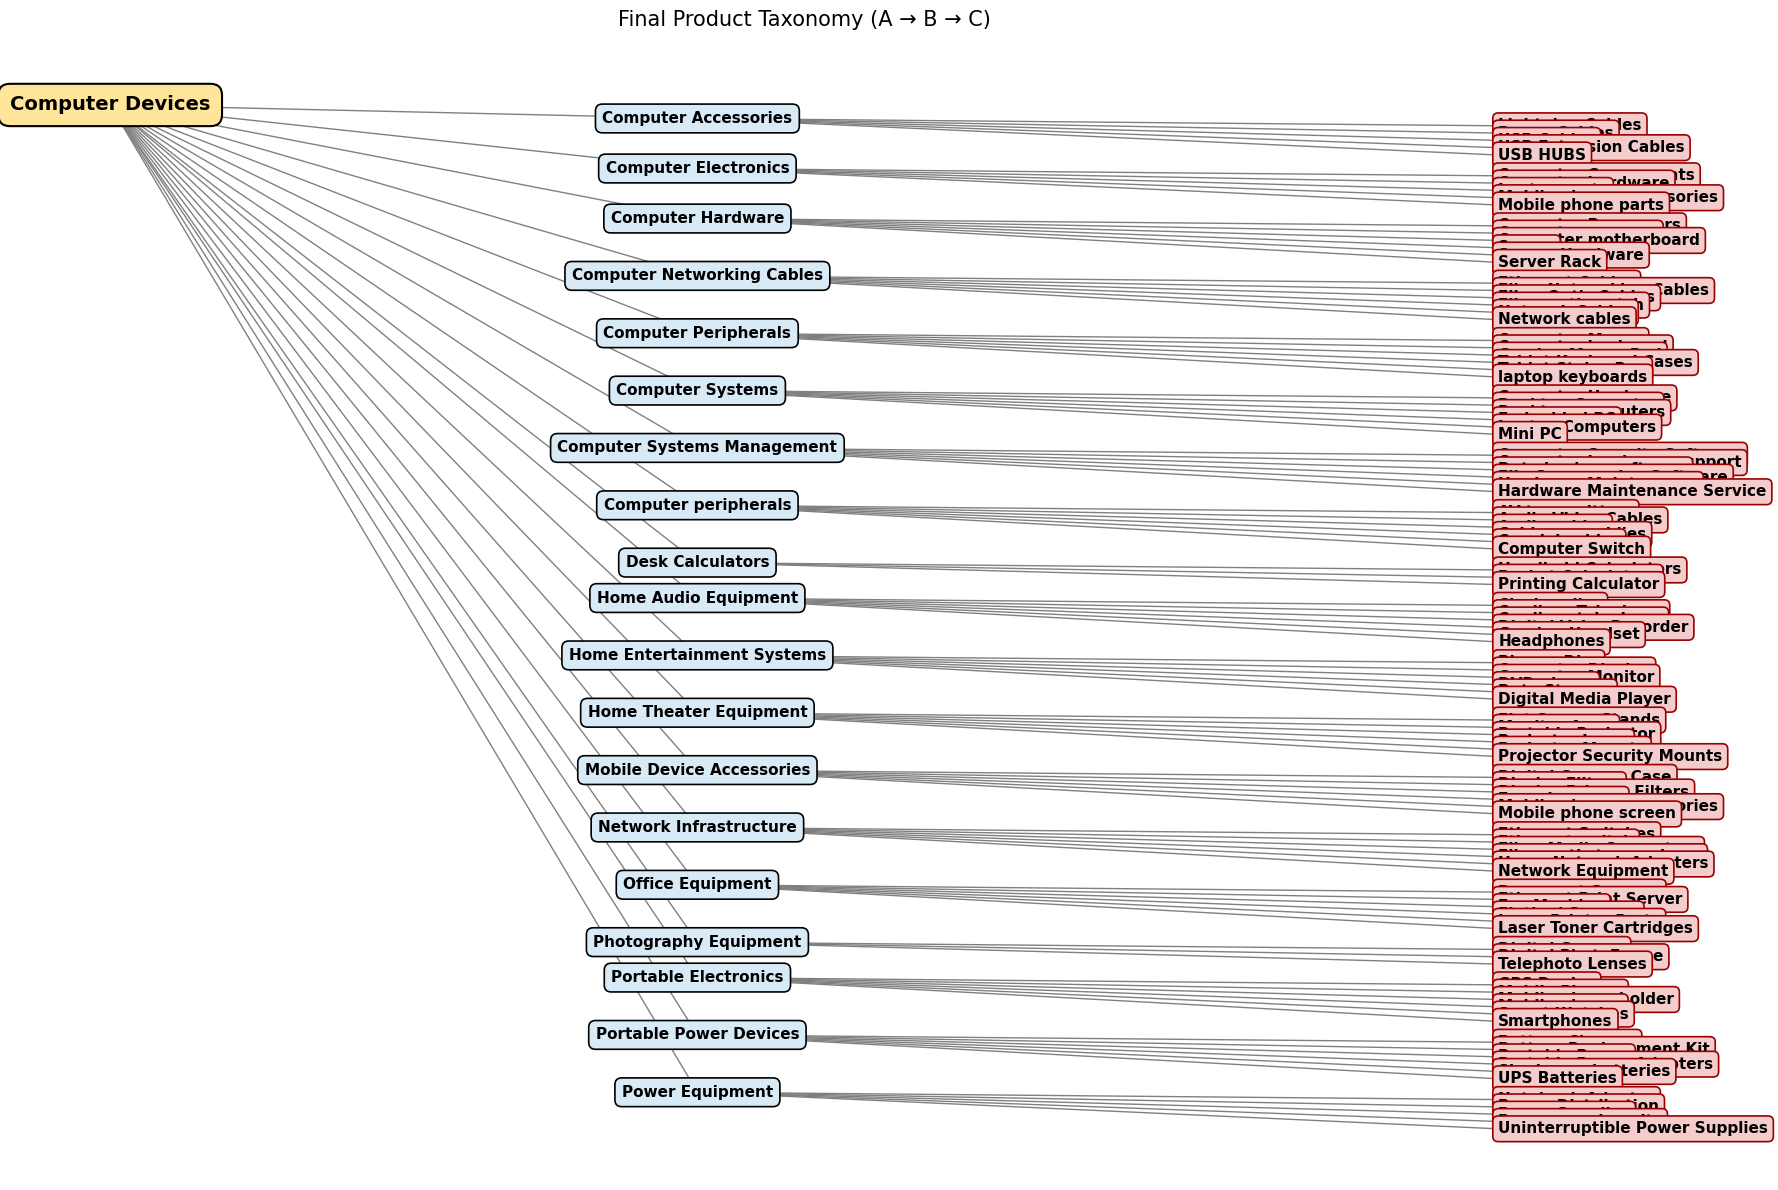

In [244]:
import matplotlib.pyplot as plt
import pandas as pd

# ==============================
# CONFIG
# ==============================
MAX_C_PER_B = 6          # show top C per B for readability
x_A, x_B, x_C = 0, 2.2, 5.2

# ==============================
# CLEAN DATA (REMOVE NaN)
# ==============================
tree_df = (
    df_clean[["A_name", "B_name", "C_name"]]
    .dropna()
    .drop_duplicates()
)

A_name = tree_df["A_name"].iloc[0]

B_to_C = (
    tree_df
    .groupby("B_name")["C_name"]
    .apply(list)
    .to_dict()
)

# ==============================
# FIGURE SETUP
# ==============================
plt.figure(figsize=(18, 12))
plt.axis("off")

y = 0

# ==============================
# A-LEVEL NODE
# ==============================
plt.text(
    x_A, y, A_name,
    ha="center", va="center",
    fontsize=14, fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.6", fc="#FFE599", ec="black", lw=1.5)
)

# ==============================
# B-LEVEL + C-LEVEL NODES
# ==============================
for B_name, C_list in sorted(B_to_C.items()):
    if not isinstance(B_name, str) or not B_name.strip():
        continue

    y -= 1.2

    # ---- B NODE ----
    plt.text(
        x_B, y, B_name,
        ha="center", va="center",
        fontsize=11, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.45", fc="#D9EAF7", ec="black", lw=1.2)
    )

    # Edge A → B
    plt.plot([x_A, x_B], [0, y], color="gray", lw=1)

    # ---- C NODES ----
    valid_C = [c for c in C_list if isinstance(c, str) and c.strip()]
    valid_C = sorted(valid_C)[:MAX_C_PER_B]

    for i, c_name in enumerate(valid_C):
        y_C = y - (i + 1) * 0.65

        plt.text(
            x_C, y_C, c_name,
            ha="left", va="center",
            fontsize=11, fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.35",
                fc="#F4CCCC",
                ec="#990000",
                lw=1.2
            )
        )

        # Edge B → C
        plt.plot([x_B, x_C], [y, y_C], color="gray", lw=1)

    # spacing after each B block
    y -= max(1, len(valid_C)) * 0.65

plt.title("Final Product Taxonomy (A → B → C)", fontsize=15, pad=20)
plt.tight_layout()
plt.show()


In [245]:
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# cluster_cosine_scores = []

# for cid in df_clean["C_id"].unique():
#     if cid == -1:
#         continue

#     idxs = df_clean[df_clean["C_id"] == cid].index
#     if len(idxs) < 2:
#         continue

#     embs = embeddings[idxs]
#     sim_matrix = cosine_similarity(embs)
    
#     # mean of upper triangle (excluding diagonal)
#     mean_sim = sim_matrix[np.triu_indices_from(sim_matrix, k=1)].mean()

#     cluster_cosine_scores.append({
#         "C_id": cid,
#         "mean_cosine_similarity": mean_sim
#     })

# cosine_df = pd.DataFrame(cluster_cosine_scores)
# cosine_df.describe()


In [246]:
# from bert_score import score

# bert_results = []

# for cid in df_clean["C_id"].unique():
#     if cid == -1:
#         continue

#     subset = df_clean[df_clean["C_id"] == cid]
#     if len(subset) < 5:
#         continue

#     label = subset["C_name"].iloc[0]
#     texts = subset["metadata_text_clean"].sample(5, random_state=42).tolist()

#     P, R, F1 = score(
#         texts,
#         [label]*len(texts),
#         lang="en",
#         verbose=False
#     )

#     bert_results.append({
#         "C_id": cid,
#         "BERTScore_F1": F1.mean().item()
#     })

# bert_df = pd.DataFrame(bert_results)
# bert_df.describe()


In [247]:
# Evaluation Metrics

# Clustering quality is primarily evaluated using purity and impurity metrics at
# the C and B levels. In addition, auxiliary semantic evaluation is performed using
# SBERT cosine similarity and BERTScore to assess alignment between predicted
# taxonomy labels and original Icecat labels. Noise clusters are excluded from all
# evaluation steps.

In [248]:
# =========================================================
# EVALUATION PIPELINE (NO NOISE)
# =========================================================

import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from bert_score import score as bertscore_score

# ---------------------------------------------------------
# 1. REMOVE NOISE CLUSTERS
# ---------------------------------------------------------
df_eval = df_clean[df_clean["C_id"] != -1].copy()

# print("Evaluation rows (no noise):", len(df_eval))

# ---------------------------------------------------------
# 2. TEXT NORMALIZATION
# ---------------------------------------------------------
def normalize_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# Gold labels (Icecat)
df_eval["gold_A"] = df_eval["A"].apply(normalize_text)
df_eval["gold_B"] = df_eval["B"].apply(normalize_text)
df_eval["gold_C"] = df_eval["C"].apply(normalize_text)
df_eval["gold_path"] = df_eval["path_3"].apply(normalize_text)

# Predicted labels (Clustering + LLM)
df_eval["pred_A"] = df_eval["A_name"].apply(normalize_text)
df_eval["pred_B"] = df_eval["B_name"].apply(normalize_text)
df_eval["pred_C"] = df_eval["C_name"].apply(normalize_text)
df_eval["pred_path"] = (
    df_eval["A_name"].fillna("") + " > " +
    df_eval["B_name"].fillna("") + " > " +
    df_eval["C_name"].fillna("")
).apply(normalize_text)

# ---------------------------------------------------------
# 3. SBERT COSINE SIMILARITY (SEMANTIC ALIGNMENT)
# ---------------------------------------------------------
# st = SentenceTransformer("all-MiniLM-L6-v2")
st = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# st = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1")

def mean_cosine(gold, pred):
    gold = [g if isinstance(g, str) else "" for g in gold]
    pred = [p if isinstance(p, str) else "" for p in pred]

    g_emb = st.encode(gold, normalize_embeddings=True, convert_to_numpy=True)
    p_emb = st.encode(pred, normalize_embeddings=True, convert_to_numpy=True)

    return float(np.sum(g_emb * p_emb, axis=1).mean())

print("\n===== SBERT COSINE SIMILARITY (NO NOISE) =====")
print("A-level:", mean_cosine(df_eval["gold_A"], df_eval["pred_A"]))
print("B-level:", mean_cosine(df_eval["gold_B"], df_eval["pred_B"]))
print("C-level:", mean_cosine(df_eval["gold_C"], df_eval["pred_C"]))
print("Full path:", mean_cosine(df_eval["gold_path"], df_eval["pred_path"]))

# ---------------------------------------------------------
# 4. BERTSCORE (LABEL QUALITY)
# ---------------------------------------------------------
def compute_bertscore(refs, cands):
    refs  = ["none" if not r else r for r in refs]
    cands = ["none" if not c else c for c in cands]

    P, R, F1 = bertscore_score(
        cands,
        refs,
        model_type="bert-base-uncased",
        lang="en",
        rescale_with_baseline=False
    )
    return float(P.mean()), float(R.mean()), float(F1.mean())

print("\n===== BERTSCORE (NO NOISE) =====")
print("A-level:", compute_bertscore(df_eval["gold_A"], df_eval["pred_A"]))
print("B-level:", compute_bertscore(df_eval["gold_B"], df_eval["pred_B"]))
print("C-level:", compute_bertscore(df_eval["gold_C"], df_eval["pred_C"]))
print("Full path:", compute_bertscore(df_eval["gold_path"], df_eval["pred_path"]))

# ---------------------------------------------------------
# 5. PRIMARY METRIC: PRODUCT-WEIGHTED PURITY (C-LEVEL)
# ---------------------------------------------------------
cluster_stats = []

for cid in sorted(df_eval["C_id"].unique()):
    subset = df_eval[df_eval["C_id"] == cid]
    size = len(subset)

    c_counts = subset["C"].value_counts()
    dominant_count = c_counts.max()

    cluster_stats.append({
        "cluster_size": size,
        "right": dominant_count
    })

cluster_df = pd.DataFrame(cluster_stats)

product_weighted_purity = (
    cluster_df["right"].sum() / cluster_df["cluster_size"].sum()
) * 100

print("\n===== PRIMARY EVALUATION METRIC =====")
print("C-level Product-weighted Purity (%):", round(product_weighted_purity, 2))
print("C-level Product-weighted Impurity (%):", round(100 - product_weighted_purity, 2))


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]


===== SBERT COSINE SIMILARITY (NO NOISE) =====
A-level: 0.7180596590042114
B-level: 0.5347192883491516
C-level: 0.6466220617294312
Full path: 0.7362439632415771

===== BERTSCORE (NO NOISE) =====


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

A-level: (0.7193294763565063, 0.7193294763565063, 0.7193294763565063)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

B-level: (0.6324934363365173, 0.6596972942352295, 0.6445900201797485)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

C-level: (0.7065364718437195, 0.700444221496582, 0.7008061408996582)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Full path: (0.7329573035240173, 0.7269235253334045, 0.7288265228271484)

===== PRIMARY EVALUATION METRIC =====
C-level Product-weighted Purity (%): 83.11
C-level Product-weighted Impurity (%): 16.89


In [251]:
# ---------------------------------------------------------
# 6. AVERAGE COSINE (A, B, C)
# ---------------------------------------------------------

cos_A = mean_cosine(df_eval["gold_A"], df_eval["pred_A"])
cos_B = mean_cosine(df_eval["gold_B"], df_eval["pred_B"])
cos_C = mean_cosine(df_eval["gold_C"], df_eval["pred_C"])

avg_cosine_ABC = (cos_A + cos_B + cos_C) / 3

print("\n===== Train AVERAGE COSINE (A–C) =====")
print("Average Cosine (A,B,C):", round(avg_cosine_ABC, 4))



===== Train AVERAGE COSINE (A–C) =====
Average Cosine (A,B,C): 0.6331


In [252]:
# ---------------------------------------------------------
# 7. AVERAGE BERTSCORE (A, B, C)
# ---------------------------------------------------------

P_A, R_A, F1_A = compute_bertscore(df_eval["gold_A"], df_eval["pred_A"])
P_B, R_B, F1_B = compute_bertscore(df_eval["gold_B"], df_eval["pred_B"])
P_C, R_C, F1_C = compute_bertscore(df_eval["gold_C"], df_eval["pred_C"])

avg_bertscore_F1 = (F1_A + F1_B + F1_C) / 3

print("\n===== Train AVERAGE BERTSCORE (A–C) =====")
print("Average BERTScore F1 (A,B,C):", round(avg_bertscore_F1, 4))


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]


===== Train AVERAGE BERTSCORE (A–C) =====
Average BERTScore F1 (A,B,C): 0.6882


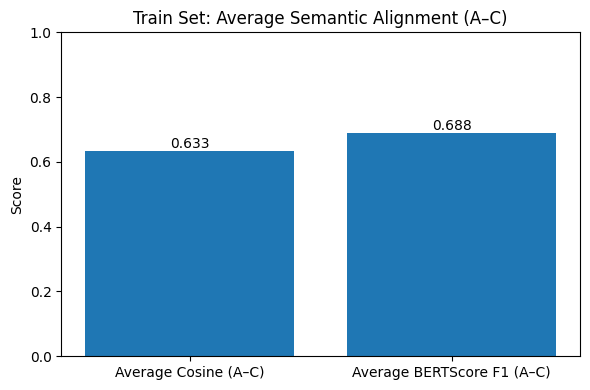

In [253]:
# ---------------------------------------------------------
# 8. SIMPLE VISUALIZATION (TRAIN AVERAGES)
# ---------------------------------------------------------

import matplotlib.pyplot as plt

metrics = ["Average Cosine (A–C)", "Average BERTScore F1 (A–C)"]
values = [avg_cosine_ABC, avg_bertscore_F1]

plt.figure(figsize=(6,4))

bars = plt.bar(metrics, values)

plt.ylabel("Score")
plt.title("Train Set: Average Semantic Alignment (A–C)")

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha='center',
        va='bottom'
    )

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [254]:
# Normalized Mutual Information (NMI) is reported as an additional clustering
# agreement metric between discovered clusters and original Icecat categories at
# the C and B levels. Noise points are excluded prior to calculation.

In [255]:
from sklearn.metrics import normalized_mutual_info_score

# -----------------------------
# Remove noise for evaluation
# -----------------------------
df_eval = df_clean[df_clean["C_id"] != -1].copy()

# -----------------------------
# C-level NMI
# gold = Icecat C, pred = OPTICS C_id
# -----------------------------
nmi_C = normalized_mutual_info_score(
    df_eval["C"].astype(str),
    df_eval["C_id"].astype(int),
    average_method="arithmetic"
)

# -----------------------------
# B-level NMI
# gold = Icecat B, pred = discovered B_id
# -----------------------------
df_eval_B = df_eval.dropna(subset=["B_id"]).copy()

nmi_B = normalized_mutual_info_score(
    df_eval_B["B"].astype(str),
    df_eval_B["B_id"].astype(int),
    average_method="arithmetic"
)

print("NMI (C-level):", round(nmi_C, 4))
print("NMI (B-level):", round(nmi_B, 4))


NMI (C-level): 0.8563
NMI (B-level): 0.6626


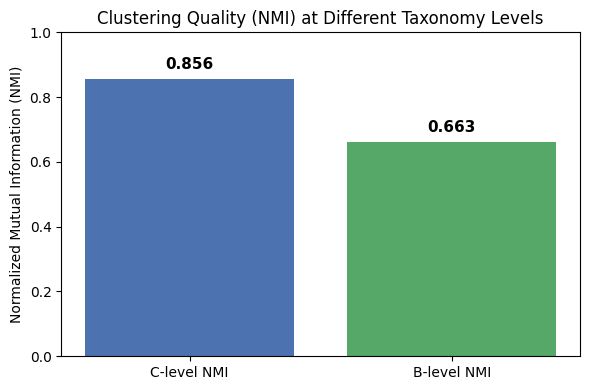

In [256]:
import matplotlib.pyplot as plt

# NMI values
levels = ["C-level NMI", "B-level NMI"]
nmi_values = [nmi_C, nmi_B]

plt.figure(figsize=(6, 4))

bars = plt.bar(
    levels,
    nmi_values,
    color=["#4C72B0", "#55A868"]
)

plt.ylim(0, 1)
plt.ylabel("Normalized Mutual Information (NMI)")
plt.title("Clustering Quality (NMI) at Different Taxonomy Levels")

# ---- Data labels on bars ----
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


In [257]:
#---#how similar is our generated tree to the test data---

In [258]:
# “We reserve approximately 20% of the data (11,989 samples) for testing.” (Approx 12000 records of test)

In [259]:
df_test = pd.read_json("icecat_data_test.json")

# Work only with first 12000 rows from the beginning
df_test = df_test.iloc[:12000].copy()

print("Raw sample size:", len(df_test))


Raw sample size: 12000


In [260]:
# Test-Set Generalization Evaluation (Frozen Taxonomy)

# To evaluate generalization, the taxonomy learned on the training set is applied
# to a held-out test set. No clustering or naming is performed on test data.
# Instead, each test product is assigned to the nearest training C-cluster centroid
# in SBERT embedding space (cosine similarity). The predicted hierarchy (C→B→A)
# is then evaluated using purity, NMI, and ARI, and optionally semantic similarity
# metrics.


In [261]:
# Path Parsing and Label Extraction
# A-, B-, and C-level ground-truth labels are extracted using the same logic as
# training to ensure consistency.


In [262]:
def split_path(path):
    if not isinstance(path, str):
        return []
    return [p.strip() for p in path.split(">") if p.strip()]

def make_3_and_4(path):
    parts = split_path(path)
    path_3, level_4 = None, None
    if len(parts) >= 3:
        path_3 = " > ".join(parts[:3])
    if len(parts) >= 4:
        level_4 = parts[3]
    return pd.Series({"path_3": path_3, "level_4": level_4})

df_test[["path_3", "level_4"]] = df_test["pathlist_names"].apply(make_3_and_4)

df_test[["A", "B", "C"]] = (
    df_test["path_3"]
    .str.split(">", expand=True)
    .apply(lambda col: col.str.strip())
)


In [263]:
# # Metadata Construction
# Product descriptions are combined and cleaned to match the training pipeline.


In [264]:
import re

def build_metadata(row):
    parts = []
    if pd.notna(row["Description.LongProductName"]):
        parts.append(row["Description.LongProductName"])
    if pd.notna(row["SummaryDescription.LongSummaryDescription"]):
        parts.append(row["SummaryDescription.LongSummaryDescription"])
    if pd.notna(row["Description.LongDesc"]):
        parts.append(row["Description.LongDesc"])
    return " ".join(parts)

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = t.lower() 
    t = re.sub(r"<[^>]+>", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

df_test["metadata_text"] = df_test.apply(build_metadata, axis=1)
df_test["metadata_text_clean"] = df_test["metadata_text"].apply(clean_text)


In [265]:
df_test.head(2)

,Brand,BrandInfo.BrandLocalName,BrandInfo.BrandLogo,BrandInfo.BrandName,BrandLogo,BrandPartCode,BulletPoints,Category.CategoryID,Category.Name.Language,Category.Name.Value,...,SummaryDescription,pathlist_ids,pathlist_names,path_3,level_4,A,B,C,metadata_text,metadata_text_clean
500081,Fujitsu,,https://images.icecat.biz/img/brand/thumb/15_b...,Fujitsu,https://images.icecat.biz/img/brand/thumb/15_b...,FSP:G-SW3Z560PRE0S,[],788,EN,Warranty & Support Extensions,...,NaN,2833>839>788,Computers & Electronics>Warranty & Support>War...,Computers & Electronics > Warranty & Support >...,None,Computers & Electronics,Warranty & Support,Warranty & Support Extensions,"SP 3y TS Sub & Upgr, 9x5, 4h Rm Rt f/ CS200c A...","sp 3y ts sub & upgr, 9x5, 4h rm rt f/ cs200c a..."
741063,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,5KM83PA,None,151,EN,Notebooks,...,NaN,2833>150>151,Computers & Electronics>Computers>Notebooks,Computers & Electronics > Computers > Notebooks,None,Computers & Electronics,Computers,Notebooks,"Intel® Core™ i7-8565U (1.8 GHz), 16GB DDR4-SDR...","intel® core™ i7-8565u (1.8 ghz), 16gb ddr4-sdr..."


In [266]:
# Compute Test Embeddings (SBERT)
# Test Embedding Generation
# Test products are embedded using the same SBERT model as training.

In [267]:
from sentence_transformers import SentenceTransformer
import numpy as np

#st_model = SentenceTransformer("all-MiniLM-L6-v2")
st_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
#st_model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1")

test_emb = st_model.encode(
    df_test["metadata_text_clean"].fillna("").tolist(),
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print("Test embeddings shape:", test_emb.shape)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Test embeddings shape: (12000, 768)


In [268]:
# Recompute TRAIN SBERT embeddings (ONCE)
from sentence_transformers import SentenceTransformer

#st_model = SentenceTransformer("all-MiniLM-L6-v2")
st_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
#st_model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1")

train_emb = st_model.encode(
    df_clean["metadata_text_clean"].fillna("").tolist(),
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print("Train embeddings shape:", train_emb.shape)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train embeddings shape: (59946, 768)


In [269]:
# Now recompute C-level centroids (your block works)
import numpy as np

valid_cids = sorted(df_clean["C_id"].unique())

C_centroids = []
C_labels = []

for cid in valid_cids:
    if cid == -1:          # skip noise cluster
        continue

    idx = (df_clean["C_id"] == cid).to_numpy()
    C_centroids.append(train_emb[idx].mean(axis=0))
    C_labels.append(cid)

C_centroids = np.vstack(C_centroids)
C_labels = np.array(C_labels)

print("Number of C centroids:", len(C_labels))
print("Centroid matrix shape:", C_centroids.shape)


Number of C centroids: 184
Centroid matrix shape: (184, 768)


In [270]:
# Assign Test Products to C Clusters
# ### Test Assignment via Nearest Centroid
# Each test product is assigned to the nearest training C-cluster using cosine similarity.

In [271]:
# Cosine similarity via dot product (normalized embeddings)
similarity = np.dot(test_emb, C_centroids.T)

best_idx = np.argmax(similarity, axis=1)
df_test["pred_C_id"] = C_labels[best_idx]
df_test["max_sim"] = similarity.max(axis=1)

df_test["pred_C_id"].value_counts().head()


pred_C_id
0     946
81    910
45    509
2     496
99    435
Name: count, dtype: int64

In [272]:
# Attach Predicted Hierarchy (C → B → A)
# Hierarchy Reconstruction
# Predicted C-level clusters inherit B- and A-level names learned during training.

In [273]:
df_test["pred_C_name"] = df_test["pred_C_id"].map(C_name_map)
df_test["pred_B_id"] = df_test["pred_C_id"].map(C_to_B)
df_test["pred_B_name"] = df_test["pred_B_id"].map(B_name_map)
df_test["pred_A_name"] = A_name


In [274]:
df_test.head(5)

,Brand,BrandInfo.BrandLocalName,BrandInfo.BrandLogo,BrandInfo.BrandName,BrandLogo,BrandPartCode,BulletPoints,Category.CategoryID,Category.Name.Language,Category.Name.Value,...,B,C,metadata_text,metadata_text_clean,pred_C_id,max_sim,pred_C_name,pred_B_id,pred_B_name,pred_A_name
500081,Fujitsu,,https://images.icecat.biz/img/brand/thumb/15_b...,Fujitsu,https://images.icecat.biz/img/brand/thumb/15_b...,FSP:G-SW3Z560PRE0S,[],788,EN,Warranty & Support Extensions,...,Warranty & Support,Warranty & Support Extensions,"SP 3y TS Sub & Upgr, 9x5, 4h Rm Rt f/ CS200c A...","sp 3y ts sub & upgr, 9x5, 4h rm rt f/ cs200c a...",31,0.661589,Hardware Support,1,Computer Systems Management,Computer Devices
741063,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,5KM83PA,None,151,EN,Notebooks,...,Computers,Notebooks,"Intel® Core™ i7-8565U (1.8 GHz), 16GB DDR4-SDR...","intel® core™ i7-8565u (1.8 ghz), 16gb ddr4-sdr...",2,0.779186,Laptop Computers,3,Computer Systems,Computer Devices
1091454,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,4NG33EA,[],153,EN,PCs/Workstations,...,Computers,PCs/Workstations,HP OMEN 880-156nf. Processor frequency: 3.2 GH...,hp omen 880-156nf. processor frequency: 3.2 gh...,4,0.805579,Desktop computers,3,Computer Systems,Computer Devices
522928,C2G,,https://images.icecat.biz/img/brand/thumb/2834...,C2G,https://images.icecat.biz/img/brand/thumb/2834...,83061,[],883,EN,Networking Cables,...,Computer Cables,Networking Cables,Cat5E Assembled UTP Patch Cable Green 1m C2G 1...,cat5e assembled utp patch cable green 1m c2g 1...,59,0.828610,Ethernet Cables,8,Computer Networking Cables,Computer Devices
479478,Lenovo,,https://images.icecat.biz/img/brand/thumb/728_...,Lenovo,https://images.icecat.biz/img/brand/thumb/728_...,5PS0A14091,[],788,EN,Warranty & Support Extensions,...,Warranty & Support,Warranty & Support Extensions,3YR Onsite + Keep Your Drive Lenovo 5PS0A14091...,3yr onsite + keep your drive lenovo 5ps0a14091...,31,0.543186,Hardware Support,1,Computer Systems Management,Computer Devices


In [280]:
# Semantic similarity between predicted and ground-truth category names is
# measured to evaluate naming quality.

In [281]:
import re

def normalize_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# Gold (Icecat)
df_test["gold_A_norm"] = df_test["A"].apply(normalize_text)
df_test["gold_B_norm"] = df_test["B"].apply(normalize_text)
df_test["gold_C_norm"] = df_test["C"].apply(normalize_text)
df_test["gold_path_norm"] = df_test["path_3"].apply(normalize_text)

# Predicted (taxonomy)
df_test["pred_A_norm"] = df_test["pred_A_name"].apply(normalize_text)
df_test["pred_B_norm"] = df_test["pred_B_name"].apply(normalize_text)
df_test["pred_C_norm"] = df_test["pred_C_name"].apply(normalize_text)
df_test["pred_path_norm"] = (
    df_test["pred_A_name"] + " > " +
    df_test["pred_B_name"] + " > " +
    df_test["pred_C_name"]
).apply(normalize_text)


In [282]:
df_test.head()

,Brand,BrandInfo.BrandLocalName,BrandInfo.BrandLogo,BrandInfo.BrandName,BrandLogo,BrandPartCode,BulletPoints,Category.CategoryID,Category.Name.Language,Category.Name.Value,...,pred_B_name,pred_A_name,gold_A_norm,gold_B_norm,gold_C_norm,gold_path_norm,pred_A_norm,pred_B_norm,pred_C_norm,pred_path_norm
500081,Fujitsu,,https://images.icecat.biz/img/brand/thumb/15_b...,Fujitsu,https://images.icecat.biz/img/brand/thumb/15_b...,FSP:G-SW3Z560PRE0S,[],788,EN,Warranty & Support Extensions,...,Computer Systems Management,Computer Devices,computers electronics,warranty support,warranty support extensions,computers electronics warranty support warrant...,computer devices,computer systems management,hardware support,computer devices computer systems management h...
741063,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,5KM83PA,None,151,EN,Notebooks,...,Computer Systems,Computer Devices,computers electronics,computers,notebooks,computers electronics computers notebooks,computer devices,computer systems,laptop computers,computer devices computer systems laptop compu...
1091454,HP,,https://images.icecat.biz/img/brand/thumb/1_91...,HP,https://images.icecat.biz/img/brand/thumb/1_91...,4NG33EA,[],153,EN,PCs/Workstations,...,Computer Systems,Computer Devices,computers electronics,computers,pcs workstations,computers electronics computers pcs workstations,computer devices,computer systems,desktop computers,computer devices computer systems desktop comp...
522928,C2G,,https://images.icecat.biz/img/brand/thumb/2834...,C2G,https://images.icecat.biz/img/brand/thumb/2834...,83061,[],883,EN,Networking Cables,...,Computer Networking Cables,Computer Devices,computers electronics,computer cables,networking cables,computers electronics computer cables networki...,computer devices,computer networking cables,ethernet cables,computer devices computer networking cables et...
479478,Lenovo,,https://images.icecat.biz/img/brand/thumb/728_...,Lenovo,https://images.icecat.biz/img/brand/thumb/728_...,5PS0A14091,[],788,EN,Warranty & Support Extensions,...,Computer Systems Management,Computer Devices,computers electronics,warranty support,warranty support extensions,computers electronics warranty support warrant...,computer devices,computer systems management,hardware support,computer devices computer systems management h...


In [283]:
# Cosine similarity using SBERT embeddings evaluates semantic similarity between
# predicted and ground-truth labels on the test set.

In [284]:
import numpy as np
from sentence_transformers import SentenceTransformer


#st = SentenceTransformer("all-MiniLM-L6-v2")
st = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
#st = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1")


def mean_cosine(gold_list, pred_list):
    gold_emb = st.encode(gold_list, normalize_embeddings=True, convert_to_numpy=True)
    pred_emb = st.encode(pred_list, normalize_embeddings=True, convert_to_numpy=True)
    return float((gold_emb * pred_emb).sum(axis=1).mean())

print("\n===== TEST COSINE SIMILARITY =====")
print("A-level:",   mean_cosine(df_test["gold_A_norm"].tolist(),
                                df_test["pred_A_norm"].tolist()))
print("B-level:",   mean_cosine(df_test["gold_B_norm"].tolist(),
                                df_test["pred_B_norm"].tolist()))
print("C-level:",   mean_cosine(df_test["gold_C_norm"].tolist(),
                                df_test["pred_C_norm"].tolist()))
print("Full-path:", mean_cosine(df_test["gold_path_norm"].tolist(),
                                df_test["pred_path_norm"].tolist()))


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]


===== TEST COSINE SIMILARITY =====
A-level: 0.7180597186088562
B-level: 0.5613431930541992
C-level: 0.5485550761222839
Full-path: 0.714342474937439


In [286]:
from bert_score import score as bertscore_score

def compute_bertscore(refs, cands, model_type="bert-base-uncased"):
    refs  = ["none" if not r else r for r in refs]
    cands = ["none" if not c else c for c in cands]

    P, R, F1 = bertscore_score(
        cands,
        refs,
        model_type=model_type,
        lang="en",
        rescale_with_baseline=False
    )
    return float(P.mean()), float(R.mean()), float(F1.mean())

print("\n===== TEST BERTSCORE =====")
print("A-level:", compute_bertscore(
    df_test["A"].astype(str).tolist(),
    df_test["pred_A_name"].astype(str).tolist()
))
print("B-level:", compute_bertscore(
    df_test["B"].astype(str).tolist(),
    df_test["pred_B_name"].astype(str).tolist()
))
print("C-level:", compute_bertscore(
    df_test["C"].astype(str).tolist(),
    df_test["pred_C_name"].astype(str).tolist()
))
print("Full-path:", compute_bertscore(
    df_test["path_3"].astype(str).tolist(),
    (df_test["pred_A_name"] + " > " +
     df_test["pred_B_name"] + " > " +
     df_test["pred_C_name"]).astype(str).tolist()
))



===== TEST BERTSCORE =====


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

A-level: (0.6666616797447205, 0.5644649863243103, 0.6113215088844299)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

B-level: (0.5907363295555115, 0.6302127838134766, 0.6070263385772705)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

C-level: (0.6161201596260071, 0.5813549160957336, 0.5958418250083923)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Full-path: (0.7434013485908508, 0.6935558319091797, 0.716977059841156)


In [287]:
# ---------------------------------------------------------
# TEST AVERAGE COSINE (A–C)
# ---------------------------------------------------------

cos_A_test = mean_cosine(
    df_test["gold_A_norm"].tolist(),
    df_test["pred_A_norm"].tolist()
)

cos_B_test = mean_cosine(
    df_test["gold_B_norm"].tolist(),
    df_test["pred_B_norm"].tolist()
)

cos_C_test = mean_cosine(
    df_test["gold_C_norm"].tolist(),
    df_test["pred_C_norm"].tolist()
)

avg_cosine_test = (cos_A_test + cos_B_test + cos_C_test) / 3

print("\n===== TEST AVERAGE COSINE (A–C) =====")
print("Average Cosine (A,B,C):", round(avg_cosine_test, 4))



===== TEST AVERAGE COSINE (A–C) =====
Average Cosine (A,B,C): 0.6093


In [288]:
# ---------------------------------------------------------
# TEST AVERAGE BERTSCORE (A–C)
# ---------------------------------------------------------

_, _, F1_A_test = compute_bertscore(
    df_test["A"].astype(str).tolist(),
    df_test["pred_A_name"].astype(str).tolist()
)

_, _, F1_B_test = compute_bertscore(
    df_test["B"].astype(str).tolist(),
    df_test["pred_B_name"].astype(str).tolist()
)

_, _, F1_C_test = compute_bertscore(
    df_test["C"].astype(str).tolist(),
    df_test["pred_C_name"].astype(str).tolist()
)

avg_bertscore_test = (F1_A_test + F1_B_test + F1_C_test) / 3

print("\n===== TEST AVERAGE BERTSCORE (A–C) =====")
print("Average BERTScore F1 (A,B,C):", round(avg_bertscore_test, 4))


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]


===== TEST AVERAGE BERTSCORE (A–C) =====
Average BERTScore F1 (A,B,C): 0.6047


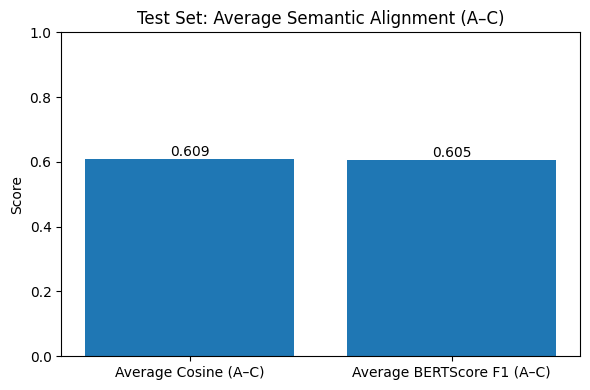

In [289]:
# ---------------------------------------------------------
# TEST AVERAGE VISUALIZATION
# ---------------------------------------------------------

import matplotlib.pyplot as plt

metrics = ["Average Cosine (A–C)", "Average BERTScore F1 (A–C)"]
values = [avg_cosine_test, avg_bertscore_test]

plt.figure(figsize=(6,4))

bars = plt.bar(metrics, values)

plt.ylabel("Score")
plt.title("Test Set: Average Semantic Alignment (A–C)")

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha='center',
        va='bottom'
    )

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [290]:
import numpy as np
import matplotlib.pyplot as plt

levels = ["A-level", "B-level", "C-level", "Full Path"]

# ---------- SBERT cosine ----------
sbert_train = [0.7181, 0.5347, 0.6466, 0.7362]
sbert_test  = [0.7181, 0.5613, 0.5486, 0.7143]

# ---------- BERTScore F1 ----------
bertscore_train = [0.7193, 0.6446, 0.7008, 0.7288]
bertscore_test  = [0.6113, 0.6070, 0.5958, 0.7170]

# ---------- Purity ----------
purity_train = 83.11
purity_test  = None   # add later if you compute test purity


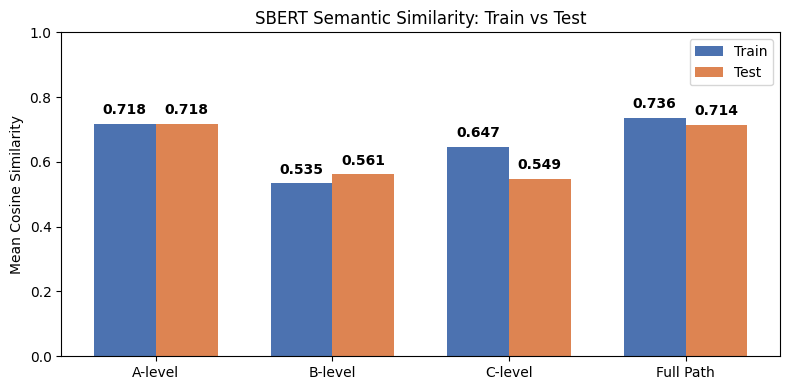

In [291]:
x = np.arange(len(levels))
width = 0.35

plt.figure(figsize=(8,4))
bars_train = plt.bar(x - width/2, sbert_train, width, label="Train", color="#4C72B0")
bars_test  = plt.bar(x + width/2, sbert_test,  width, label="Test",  color="#DD8452")

plt.xticks(x, levels)
plt.ylim(0,1)
plt.ylabel("Mean Cosine Similarity")
plt.title("SBERT Semantic Similarity: Train vs Test")
plt.legend()

# ---- data labels ----
for bars in [bars_train, bars_test]:
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width()/2,
            h + 0.02,
            f"{h:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

plt.tight_layout()
plt.show()


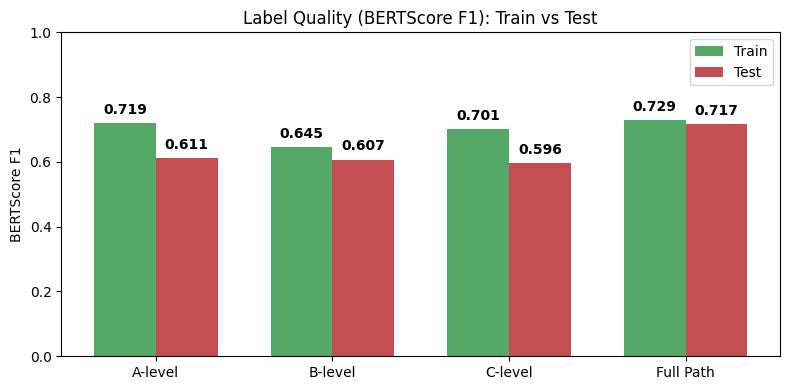

In [292]:
plt.figure(figsize=(8,4))
bars_train = plt.bar(x - width/2, bertscore_train, width, label="Train", color="#55A868")
bars_test  = plt.bar(x + width/2, bertscore_test,  width, label="Test",  color="#C44E52")

plt.xticks(x, levels)
plt.ylim(0,1)
plt.ylabel("BERTScore F1")
plt.title("Label Quality (BERTScore F1): Train vs Test")
plt.legend()

# ---- data labels ----
for bars in [bars_train, bars_test]:
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width()/2,
            h + 0.02,
            f"{h:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

plt.tight_layout()
plt.show()


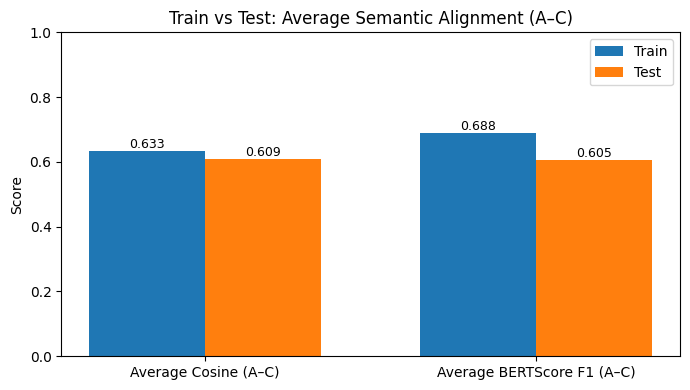

In [294]:
# ---------------------------------------------------------
# COMBINED TRAIN VS TEST VISUALIZATION
# ---------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

labels = ["Average Cosine (A–C)", "Average BERTScore F1 (A–C)"]

train_values = [avg_cosine_ABC, avg_bertscore_F1]
test_values  = [avg_cosine_test, avg_bertscore_test]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,4))

bars1 = plt.bar(x - width/2, train_values, width, label="Train")
bars2 = plt.bar(x + width/2, test_values, width, label="Test")

plt.ylabel("Score")
plt.title("Train vs Test: Average Semantic Alignment (A–C)")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()


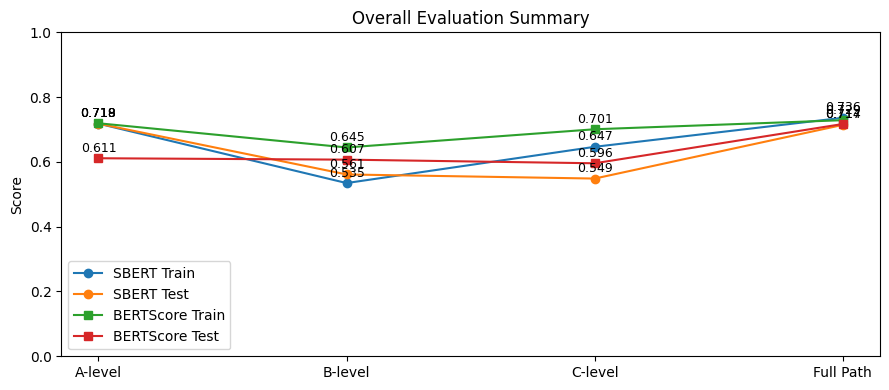

In [293]:
plt.figure(figsize=(9,4))

plt.plot(levels, sbert_train, marker="o", label="SBERT Train")
plt.plot(levels, sbert_test,  marker="o", label="SBERT Test")
plt.plot(levels, bertscore_train, marker="s", label="BERTScore Train")
plt.plot(levels, bertscore_test,  marker="s", label="BERTScore Test")

# ---- data labels ----
for vals in [sbert_train, sbert_test, bertscore_train, bertscore_test]:
    for x_i, y_i in zip(levels, vals):
        plt.text(x_i, y_i + 0.02, f"{y_i:.3f}", ha="center", fontsize=9)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Overall Evaluation Summary")
plt.legend()
plt.tight_layout()
plt.show()
